In [419]:
import re
from enum import Enum
from typing import List, Tuple, Dict, Set, Optional, Union, Any, Callable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [420]:
def replace_multiple_spaces_by_one(s):
    return re.sub(r" +", " ", s)

In [421]:
class Unit(Enum):
    ns = 1000000000
    us = 1000000
    ms = 1000
    s = 1
    nop = 0

    def __str__(self):
        return self.name

def get_unit(s):
    unit = s.replace("/op", "")
    if unit == "ns":
        return Unit.ns
    elif unit == "us":
        return Unit.us
    elif unit == "ms":
        return Unit.ms
    elif unit == "s":
        return Unit.s
    else:
        raise Exception("Unknown unit")
    
def convert(n:float, current_unit:Unit, new_unit:Unit) -> float:
    return n * current_unit.value / new_unit.value

def verify_unit_or_convert(data: Tuple[Unit, List[Tuple[int, float, float]]], other_data: Tuple[Unit, List[Tuple[int, float, float]]] = ()) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    unit = data[0] if other_data == () else other_data[0]
    u = data[0]
    res = [(x, convert(avg, u, unit), convert(err, u, unit)) for x, avg, err in data[1]]
    res.sort()
    return (unit, res)

In [422]:
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

def plot_data_with_error(plot_name: str, data1: Tuple[str, List[Tuple[int, float, float]]], data1_name: str, data2: Tuple[str, List[Tuple[int, float, float]]], data2_name: str, data3_name: Optional[str], data3: Optional[Tuple[str, List[Tuple[int, float, float]]]] = None, x_line_at: int = 0, show_avg: bool = False, output_folder = ""):
    unit1, dat1 = data1
    unit2, dat2 = data2
    dat3 = None
    if data3 is not None:
        unit3, dat3 = data3
        assert unit1 == unit3
    assert unit1 == unit2

    fig, ax = plt.subplots()

    # Choose colorblind-friendly colors
    color1 = 'tab:blue'  
    color2 = 'tab:orange'  
    color3 = 'tab:cyan'  

    # the error bar is shown in another color, and it the 99% CI
    # The y-axis always starts at 0
    ax.errorbar([x for x, _, _ in dat1], [y for _, y, _ in dat1], yerr=[y for _, _, y in dat1], label=data1_name, color=color1)
    ax.errorbar([x for x, _, _ in dat2], [y for _, y, _ in dat2], yerr=[y for _, _, y in dat2], label=data2_name, color=color2)
    if data3 is not None:
        assert dat3 is not None
        ax.errorbar([x for x, _, _ in dat3], [y for _, y, _ in dat3], yerr=[y for _, _, y in dat3], label=data3_name, color=color3)

    avg_1 = sum([y for _, y, _ in dat1]) / len(dat1)
    avg_2 = sum([y for _, y, _ in dat2]) / len(dat2)
    avg_3 = None

    max_y_value = max([y for _, y, _ in dat1] + [y for _, y, _ in dat2])
    if data3 is not None:
        assert dat3 is not None
        max_y_value = max(max_y_value, max([y for _, y, _ in dat3]))
        avg_3 = sum([y for _, y, _ in dat3]) / len(dat3)

    max_y_value = max_y_value + 0.15 * max_y_value
    ax.set_xlabel("N")
    ax.set_ylabel(f"Time ({unit1})")

    # Add a vertical line at x = x_line_at if not 0
    if x_line_at != 0:
        ax.axvline(x=x_line_at, color='black', linestyle='--')

    if show_avg:
        ax.axhline(y=avg_1, color=color1, linestyle='--')
        print(f"Average of {data1_name}: {avg_1}")
        ax.axhline(y=avg_2, color=color2, linestyle='--')
        print(f"Average of {data2_name}: {avg_2}")
        if data3 is not None:
            assert dat3 is not None
            assert avg_3 is not None
            ax.axhline(y=avg_3, color=color3, linestyle='--')
            print(f"Average of {data3_name}: {avg_3}")

    ax.legend()
    ax.set_title(plot_name)
    
    if output_folder != "":
        # fig.savefig(f"{output_folder}/{plot_name}.png", format='png', dpi=1200)
        file_name = plot_name.replace(" - ", "_").replace(" ", "_").replace("^", "to").replace("&", "and").replace(",", "").replace("(", "").replace(")", "").replace(":", "").replace("/", "_")
        fig.savefig(f"{output_folder}/{file_name}.eps", format='eps')

    plt.show()


In [423]:
def extract_data(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg), float(err)) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy()])

def extract_data_normalised_per_op(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg)/float(param), float(err)/float(param) ) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy() if int(param) != 0] )

def normalise_data_wrt_value(data: Tuple[Unit, List[Tuple[int, float, float]]], value: float)-> Tuple[Unit, List[Tuple[int, float, float]]]:
    return (Unit.nop, [(x, avg/value, err/value) for x, avg, err in data[1]])


In [424]:
def create_plots(benchmark_classes: List[str], benchmark_names: Dict[str, List[str]],  df: pd.DataFrame, variable_names: Dict[str, str] = {}, show_avg_for: str = "never", show_opti: bool = False, pretty_benchmark_names: Dict[str, str] = {}, output_folder = ""):
    for c in benchmark_classes:
        benchmark_func_names = benchmark_names[c]
        for n in benchmark_func_names:
            if variable_names != {}:
                variable_name = variable_names[c]
            else:
                # Only for legacy reasons
                variable_name = "n" if "LongListMapBenchmark" in c else "keysListName"
            map1_name = "Verified"
            map2_name = "ListMap" if "LongListMapBenchmark" in c else "Original"
            map3_name = "Opti"

            benchm_name = f"{c}.{n}"
            
            bench_name_pretty = f"{n}"
            if benchm_name in pretty_benchmark_names:
                bench_name_pretty = pretty_benchmark_names[benchm_name]
            
            map1_data = verify_unit_or_convert(extract_data(df, benchm_name, map1_name, variable_name))
            map2_data = verify_unit_or_convert(extract_data(df, benchm_name, map2_name, variable_name), map1_data)

            map3_data = None
            if show_opti:
                map3_data = verify_unit_or_convert(extract_data(df, benchm_name, map3_name, variable_name), map1_data) if len(df[df["Benchmark"].str.contains(map3_name)].values.tolist()) > 0 else None

            if  "LongListMapBenchmark" in c:
                map2_data = (map2_data[0], [(2**x, i, err) for (x, i, err) in map2_data[1]])
                map1_data = (map1_data[0], [(2**x, i, err) for (x, i, err) in map1_data[1]])
                map3_data = None
        # print("Test = " + n + "\nOriginal: " + str(originalRetrieve) + "\nVerified: " + str(verifiedRetrieve))
            x_line_at = 0
            if "MutableLongMapBenchmarkBig" in c:
                x_line_at = 2**22
            elif "MutableLongMapBenchmark" in c:
                x_line_at = 2**15

            plot_data_with_error(bench_name_pretty, map1_data, map1_name, map2_data, map2_name, map3_name, map3_data, x_line_at, show_avg_for == "always", output_folder = output_folder)

            # Create the same plot but normalised with respect to the first value of the baseline
            val_normalised_against = map2_data[1][0][1]

            map1_data = normalise_data_wrt_value(map1_data, val_normalised_against)
            map2_data = normalise_data_wrt_value(map2_data, val_normalised_against)
            if map3_data is not None:
                map3_data = normalise_data_wrt_value(map3_data, val_normalised_against)
            plot_data_with_error(bench_name_pretty + " (normalised)", map1_data, map1_name, map2_data, map2_name, map3_name, map3_data, x_line_at, show_avg_for == "always", output_folder = output_folder)

            if "lookupn" in n.lower():
            # plot the data normalised per operation
                map1_data = verify_unit_or_convert(extract_data_normalised_per_op(df, benchm_name, map1_name, variable_name))
                map2_data = verify_unit_or_convert(extract_data_normalised_per_op(df, benchm_name, map2_name, variable_name), map1_data)

                map3_data = None
                if show_opti:
                    map3_data = verify_unit_or_convert(extract_data_normalised_per_op(df, benchm_name, map3_name, variable_name), map1_data) if len(df[df["Benchmark"].str.contains(map3_name)].values.tolist()) > 0 else None
                if "LongListMapBenchmark" in c:
                    map2_data = (map2_data[0], [(2**x, i, err) for (x, i, err) in map2_data[1]])
                    map1_data = (map1_data[0], [(2**x, i, err) for (x, i, err) in map1_data[1]])
                    map3_data = None
                
                plot_data_with_error(bench_name_pretty + " (normalised per operation)", map1_data, map1_name, map2_data, map2_name, map3_name, map3_data, x_line_at, show_avg_for == "normalised", output_folder = output_folder)
                
                # Create the same plot but normalised with respect to the avg value of the baseline
                val_normalised_against = sum([y for _, y, _ in map2_data[1]]) / len(map2_data[1])

                map1_data = normalise_data_wrt_value(map1_data, val_normalised_against)
                map2_data = normalise_data_wrt_value(map2_data, val_normalised_against)
                if map3_data is not None:
                    map3_data = normalise_data_wrt_value(map3_data, val_normalised_against)
                
                plot_data_with_error(bench_name_pretty + " (normalised per operation, normalised)", map1_data, map1_name, map2_data, map2_name, map3_name, map3_data, x_line_at, show_avg_for == "normalised", output_folder = output_folder)


In [425]:
data = """[info] Benchmark                                                                                            (keysListName)  (n)  Mode  Cnt          Score         Error  Units
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    1  avgt   10          0.617 ±       0.005  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    2  avgt   10          2.781 ±       0.028  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    3  avgt   10         17.324 ±       0.094  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    4  avgt   10        170.439 ±       1.155  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    5  avgt   10       1783.279 ±       5.124  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    6  avgt   10      23927.023 ±      90.400  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    7  avgt   10     324689.489 ±    7525.859  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    8  avgt   10    5337855.024 ±   84222.990  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    9  avgt   10  107125015.783 ± 1814628.395  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    1  avgt   10          0.094 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    2  avgt   10          0.134 ±       0.006  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    3  avgt   10          0.299 ±       0.003  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    4  avgt   10          0.679 ±       0.012  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    5  avgt   10          1.279 ±       0.010  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    6  avgt   10          2.696 ±       0.020  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    7  avgt   10          5.666 ±       0.046  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    8  avgt   10         12.124 ±       0.094  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    9  avgt   10         28.459 ±       0.256  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    1  avgt   10          0.416 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    2  avgt   10          0.475 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    3  avgt   10          0.759 ±       0.006  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    4  avgt   10          1.257 ±       0.011  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    5  avgt   10          2.192 ±       0.019  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    6  avgt   10          4.195 ±       0.026  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    7  avgt   10          8.064 ±       0.084  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    8  avgt   10         16.763 ±       0.173  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    9  avgt   10         33.834 ±       0.311  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    3  avgt   10          7.511 ±       0.014  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    4  avgt   10         81.357 ±       0.166  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    5  avgt   10       1016.327 ±       1.946  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    6  avgt   10      13316.241 ±      67.743  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    7  avgt   10     200335.062 ±   21733.473  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    8  avgt   10    3378464.058 ±   82948.525  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    9  avgt   10   68990208.101 ± 4435369.062  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    1  avgt   10          0.044 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    2  avgt   10          0.053 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    3  avgt   10          0.055 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    4  avgt   10          0.094 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    5  avgt   10          0.159 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    6  avgt   10          0.306 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    7  avgt   10          0.584 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    8  avgt   10          1.460 ±       0.004  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    9  avgt   10          3.302 ±       0.013  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    1  avgt   10          0.040 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    2  avgt   10          0.054 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    3  avgt   10          0.066 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    4  avgt   10          0.121 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    5  avgt   10          0.239 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    6  avgt   10          0.439 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    7  avgt   10          0.896 ±       0.007  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    8  avgt   10          2.101 ±       0.003  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    9  avgt   10          4.800 ±       0.496  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         2048  N/A  avgt   10       3029.903 ±     702.482  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         4096  N/A  avgt   10       2834.240 ±     680.793  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         6144  N/A  avgt   10       3168.219 ±     559.656  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         8192  N/A  avgt   10       2648.301 ±      71.102  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        10240  N/A  avgt   10       2581.860 ±      62.649  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        12288  N/A  avgt   10       2271.928 ±      31.666  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        14336  N/A  avgt   10       2325.730 ±      43.088  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        16384  N/A  avgt   10       2422.748 ±     268.758  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        18432  N/A  avgt   10       2387.688 ±      27.699  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        20480  N/A  avgt   10       2408.004 ±      32.366  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        22528  N/A  avgt   10       2439.081 ±      17.008  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        24576  N/A  avgt   10       2486.667 ±      24.333  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        26624  N/A  avgt   10       2593.913 ±      19.997  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        28672  N/A  avgt   10       2565.403 ±      12.971  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        30720  N/A  avgt   10       2586.063 ±      15.959  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        32768  N/A  avgt   10       2722.841 ±      27.643  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        34816  N/A  avgt   10       2712.775 ±      42.763  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        36864  N/A  avgt   10       2681.312 ±      13.169  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        38912  N/A  avgt   10       2645.737 ±      18.099  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        40960  N/A  avgt   10       2685.153 ±      33.186  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        43008  N/A  avgt   10       2769.537 ±      47.091  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        45056  N/A  avgt   10       2708.059 ±      19.668  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        47104  N/A  avgt   10       2694.873 ±      12.955  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        49152  N/A  avgt   10       2638.900 ±      13.804  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        51200  N/A  avgt   10       2667.042 ±      60.812  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        53248  N/A  avgt   10       2757.245 ±      77.147  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        55296  N/A  avgt   10       2646.818 ±      59.989  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        57344  N/A  avgt   10       3605.704 ±    1116.395  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        59392  N/A  avgt   10       3511.809 ±     798.976  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        61440  N/A  avgt   10       3729.349 ±     703.480  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        63488  N/A  avgt   10       3262.584 ±     304.915  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        65536  N/A  avgt   10       3102.288 ±      92.266  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         2048  N/A  avgt   10       3321.921 ±      71.039  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         4096  N/A  avgt   10       3392.466 ±      38.399  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         6144  N/A  avgt   10       3403.846 ±      26.130  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         8192  N/A  avgt   10       3438.374 ±      48.210  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        10240  N/A  avgt   10       3448.130 ±      51.345  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        12288  N/A  avgt   10       3536.797 ±      42.871  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        14336  N/A  avgt   10       3639.633 ±      49.134  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        16384  N/A  avgt   10       3706.376 ±      68.808  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        18432  N/A  avgt   10       3738.777 ±      24.974  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        20480  N/A  avgt   10       3708.853 ±      60.587  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        22528  N/A  avgt   10       3785.489 ±      34.835  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        24576  N/A  avgt   10       3801.270 ±      21.114  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        26624  N/A  avgt   10       3962.131 ±      47.395  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        28672  N/A  avgt   10       3954.545 ±      35.110  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        30720  N/A  avgt   10       3977.213 ±      32.395  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        32768  N/A  avgt   10       4080.788 ±      23.148  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        34816  N/A  avgt   10       4146.605 ±      40.563  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        36864  N/A  avgt   10       4165.053 ±      25.376  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        38912  N/A  avgt   10       4124.604 ±      54.549  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        40960  N/A  avgt   10       4191.546 ±      38.434  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        43008  N/A  avgt   10       4108.144 ±      56.722  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        45056  N/A  avgt   10       4094.593 ±      46.481  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        47104  N/A  avgt   10       4191.340 ±      41.819  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        49152  N/A  avgt   10       4105.793 ±      49.549  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        51200  N/A  avgt   10       4067.034 ±      20.812  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        53248  N/A  avgt   10       4146.503 ±      16.457  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        55296  N/A  avgt   10       4103.702 ±      46.446  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        57344  N/A  avgt   10       4026.546 ±      34.310  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        59392  N/A  avgt   10       4151.541 ±      57.520  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        61440  N/A  avgt   10       4153.666 ±      39.434  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        63488  N/A  avgt   10       4124.194 ±      48.936  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        65536  N/A  avgt   10       4129.328 ±      39.881  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      2048  N/A  avgt   10       1489.361 ±      16.800  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      4096  N/A  avgt   10       1573.786 ±      20.060  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      6144  N/A  avgt   10       1641.652 ±      14.636  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      8192  N/A  avgt   10       1551.687 ±      20.362  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     10240  N/A  avgt   10       1632.429 ±      20.806  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     12288  N/A  avgt   10       1661.546 ±      12.418  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     14336  N/A  avgt   10       1628.939 ±      12.000  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     16384  N/A  avgt   10       1693.215 ±       8.058  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     18432  N/A  avgt   10       1712.966 ±      10.803  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     20480  N/A  avgt   10       1781.061 ±      13.530  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     22528  N/A  avgt   10       1771.645 ±      10.468  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     24576  N/A  avgt   10       1817.270 ±      16.108  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     26624  N/A  avgt   10       1871.285 ±       8.611  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     28672  N/A  avgt   10       2112.988 ±     302.147  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     30720  N/A  avgt   10       2011.250 ±     245.319  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     32768  N/A  avgt   10       2100.256 ±     445.121  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     34816  N/A  avgt   10       1880.229 ±      29.018  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     36864  N/A  avgt   10       1897.312 ±      26.096  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     38912  N/A  avgt   10       1875.894 ±       6.476  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     40960  N/A  avgt   10       1888.230 ±       8.826  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     43008  N/A  avgt   10       1935.941 ±      34.732  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     45056  N/A  avgt   10       1917.001 ±      36.632  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     47104  N/A  avgt   10       1916.315 ±      34.291  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     49152  N/A  avgt   10       1848.995 ±      37.829  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     51200  N/A  avgt   10       1893.162 ±       9.149  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     53248  N/A  avgt   10       1957.628 ±      25.876  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     55296  N/A  avgt   10       1935.693 ±      39.332  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     57344  N/A  avgt   10       1981.091 ±      28.232  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     59392  N/A  avgt   10       1921.354 ±      10.147  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     61440  N/A  avgt   10       1873.598 ±      26.049  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     63488  N/A  avgt   10       1969.106 ±      10.060  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     65536  N/A  avgt   10       1878.163 ±      22.401  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      2048  N/A  avgt   10       4135.596 ±      48.052  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      4096  N/A  avgt   10       4245.360 ±      46.159  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      6144  N/A  avgt   10       4282.969 ±      59.990  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      8192  N/A  avgt   10       4358.910 ±      43.852  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     10240  N/A  avgt   10       4354.857 ±      20.090  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     12288  N/A  avgt   10       4460.780 ±      89.164  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     14336  N/A  avgt   10       4422.891 ±      66.391  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     16384  N/A  avgt   10       4601.487 ±      54.983  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     18432  N/A  avgt   10       4565.427 ±      36.903  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     20480  N/A  avgt   10       4694.088 ±      32.797  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     22528  N/A  avgt   10       4744.190 ±      62.199  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     24576  N/A  avgt   10       4708.267 ±      62.484  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     26624  N/A  avgt   10       4835.686 ±      61.328  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     28672  N/A  avgt   10       4942.032 ±      27.503  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     30720  N/A  avgt   10       4987.890 ±      28.413  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     32768  N/A  avgt   10       5130.721 ±      49.193  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     34816  N/A  avgt   10       5006.648 ±      61.552  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     36864  N/A  avgt   10       5048.614 ±      77.807  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     38912  N/A  avgt   10       5088.569 ±      54.717  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     40960  N/A  avgt   10       5023.945 ±      29.661  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     43008  N/A  avgt   10       5060.934 ±      53.601  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     45056  N/A  avgt   10       5123.406 ±      50.910  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     47104  N/A  avgt   10       5062.768 ±      27.830  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     49152  N/A  avgt   10       5004.645 ±      60.860  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     51200  N/A  avgt   10       5039.316 ±      86.595  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     53248  N/A  avgt   10       5016.653 ±      23.592  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     55296  N/A  avgt   10       5162.540 ±      83.285  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     57344  N/A  avgt   10       5044.565 ±      39.960  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     59392  N/A  avgt   10       5054.480 ±      68.151  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     61440  N/A  avgt   10       5166.598 ±      26.836  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     63488  N/A  avgt   10       5024.190 ±      46.357  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     65536  N/A  avgt   10       5040.732 ±      26.470  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             2048  N/A  avgt   10       4711.378 ±      24.773  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             4096  N/A  avgt   10       4721.236 ±      33.375  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             6144  N/A  avgt   10       4734.070 ±      23.535  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             8192  N/A  avgt   10       4724.195 ±      28.801  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            10240  N/A  avgt   10       4787.427 ±      82.488  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            12288  N/A  avgt   10       4824.616 ±      90.221  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            14336  N/A  avgt   10       4906.664 ±      24.827  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            16384  N/A  avgt   10       4960.406 ±      47.111  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            18432  N/A  avgt   10       4944.008 ±      68.892  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            20480  N/A  avgt   10       4899.467 ±      24.580  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            22528  N/A  avgt   10       5069.116 ±     143.477  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            24576  N/A  avgt   10       5003.895 ±      59.109  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            26624  N/A  avgt   10       4982.129 ±      58.038  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            28672  N/A  avgt   10       5034.678 ±      62.514  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            30720  N/A  avgt   10       5173.725 ±      48.171  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            32768  N/A  avgt   10       5161.757 ±      34.610  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            34816  N/A  avgt   10       5243.560 ±      72.175  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            36864  N/A  avgt   10       5133.533 ±      45.382  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            38912  N/A  avgt   10       5161.778 ±      39.231  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            40960  N/A  avgt   10       5150.147 ±      29.700  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            43008  N/A  avgt   10       5103.610 ±      27.639  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            45056  N/A  avgt   10       5220.236 ±      25.417  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            47104  N/A  avgt   10       5200.227 ±      39.060  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            49152  N/A  avgt   10       5166.722 ±      27.703  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            51200  N/A  avgt   10       5289.958 ±      63.176  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            53248  N/A  avgt   10       5114.252 ±      55.901  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            55296  N/A  avgt   10       5148.430 ±      27.756  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            57344  N/A  avgt   10       5242.576 ±      62.628  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            59392  N/A  avgt   10       5260.776 ±      37.634  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            61440  N/A  avgt   10       5278.143 ±      74.632  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            63488  N/A  avgt   10       5141.489 ±      41.852  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            65536  N/A  avgt   10       5104.360 ±      37.463  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             2048  N/A  avgt   10    3036116.265 ±   10922.820  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             4096  N/A  avgt   10    3038649.804 ±   14610.873  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             6144  N/A  avgt   10    3045497.049 ±   17073.626  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             8192  N/A  avgt   10    3051699.070 ±   11669.642  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            10240  N/A  avgt   10    3009138.313 ±   14257.072  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            12288  N/A  avgt   10    3041509.078 ±   16553.332  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            14336  N/A  avgt   10    3041500.816 ±   12736.173  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            16384  N/A  avgt   10    3012199.022 ±    7517.617  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            18432  N/A  avgt   10    3027443.698 ±   12321.537  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            20480  N/A  avgt   10    3023955.942 ±   12572.595  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            22528  N/A  avgt   10    3047507.659 ±   19379.334  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            24576  N/A  avgt   10    3037831.425 ±   12182.131  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            26624  N/A  avgt   10    3022297.125 ±   12116.694  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            28672  N/A  avgt   10    3020372.732 ±   15494.644  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            30720  N/A  avgt   10    3034980.639 ±   15842.090  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            32768  N/A  avgt   10    3094305.979 ±   90338.488  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            34816  N/A  avgt   10    3049388.280 ±   16195.519  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            36864  N/A  avgt   10    3040226.834 ±   12465.477  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            38912  N/A  avgt   10    3313041.223 ±  234555.589  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            40960  N/A  avgt   10    3110753.860 ±   80397.360  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            43008  N/A  avgt   10    3084077.979 ±   75997.037  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            45056  N/A  avgt   10    3333377.009 ±  421372.335  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            47104  N/A  avgt   10    3072605.759 ±   64075.232  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            49152  N/A  avgt   10    3377952.181 ±  114465.634  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            51200  N/A  avgt   10    3420750.913 ±  200113.192  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            53248  N/A  avgt   10    3397933.380 ±   61076.061  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            55296  N/A  avgt   10    3097222.139 ±   52868.576  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            57344  N/A  avgt   10    3062303.438 ±   10976.246  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            59392  N/A  avgt   10    3161583.424 ±  178798.241  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            61440  N/A  avgt   10    3073417.965 ±   43161.833  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            63488  N/A  avgt   10    3186906.989 ±  171040.679  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            65536  N/A  avgt   10    3580745.887 ±  157608.734  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             2048  N/A  avgt   10         25.403 ±       1.308  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             4096  N/A  avgt   10         51.328 ±       5.067  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             6144  N/A  avgt   10         78.130 ±       7.044  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             8192  N/A  avgt   10         97.516 ±       5.406  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            10240  N/A  avgt   10        116.959 ±       1.316  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            12288  N/A  avgt   10        139.290 ±       1.977  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            14336  N/A  avgt   10        161.954 ±       1.613  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            16384  N/A  avgt   10        199.943 ±      13.483  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            18432  N/A  avgt   10        224.075 ±      18.177  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            20480  N/A  avgt   10        253.484 ±      12.374  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            22528  N/A  avgt   10        290.082 ±       3.306  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            24576  N/A  avgt   10        338.538 ±      26.848  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            26624  N/A  avgt   10        364.054 ±       1.785  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            28672  N/A  avgt   10        456.328 ±      14.529  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            30720  N/A  avgt   10        465.629 ±       7.909  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            32768  N/A  avgt   10        512.558 ±       6.078  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            34816  N/A  avgt   10        519.985 ±       2.437  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            36864  N/A  avgt   10        502.139 ±       5.504  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            38912  N/A  avgt   10        507.654 ±       3.724  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            40960  N/A  avgt   10        519.913 ±       2.977  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            43008  N/A  avgt   10        498.054 ±       3.991  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            45056  N/A  avgt   10        497.654 ±       2.908  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            47104  N/A  avgt   10        500.172 ±       9.039  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            49152  N/A  avgt   10        512.155 ±       9.151  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            51200  N/A  avgt   10        516.313 ±      12.527  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            53248  N/A  avgt   10        520.475 ±       8.700  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            55296  N/A  avgt   10        512.016 ±       7.396  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            57344  N/A  avgt   10        494.873 ±       2.264  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            59392  N/A  avgt   10        508.538 ±       5.179  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            61440  N/A  avgt   10        502.980 ±       5.656  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            63488  N/A  avgt   10        509.265 ±       4.118  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            65536  N/A  avgt   10        502.895 ±       3.335  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             2048  N/A  avgt   10         42.424 ±       0.330  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             4096  N/A  avgt   10         86.728 ±       0.754  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             6144  N/A  avgt   10        134.922 ±       1.309  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             8192  N/A  avgt   10        183.153 ±       3.534  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            10240  N/A  avgt   10        213.233 ±       1.418  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            12288  N/A  avgt   10        269.652 ±       1.850  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            14336  N/A  avgt   10        307.486 ±       1.896  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            16384  N/A  avgt   10        370.487 ±       2.089  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            18432  N/A  avgt   10        408.407 ±       2.860  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            20480  N/A  avgt   10        450.975 ±       6.796  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            22528  N/A  avgt   10        487.324 ±       6.528  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            24576  N/A  avgt   10        535.587 ±       3.462  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            26624  N/A  avgt   10        597.095 ±       6.168  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            28672  N/A  avgt   10        705.106 ±      21.621  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            30720  N/A  avgt   10        735.788 ±       5.044  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            32768  N/A  avgt   10       1023.885 ±       4.146  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            34816  N/A  avgt   10        769.263 ±      11.338  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            36864  N/A  avgt   10        794.195 ±       4.505  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            38912  N/A  avgt   10        809.616 ±       6.536  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            40960  N/A  avgt   10        801.077 ±       5.525  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            43008  N/A  avgt   10        821.541 ±       7.202  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            45056  N/A  avgt   10        787.602 ±       7.497  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            47104  N/A  avgt   10        814.748 ±      11.670  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            49152  N/A  avgt   10        809.242 ±       9.589  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            51200  N/A  avgt   10        813.850 ±       7.076  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            53248  N/A  avgt   10        807.116 ±       4.965  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            55296  N/A  avgt   10        788.938 ±       6.120  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            57344  N/A  avgt   10        812.694 ±       8.831  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            59392  N/A  avgt   10        779.475 ±       5.423  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            61440  N/A  avgt   10        769.963 ±       4.913  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            63488  N/A  avgt   10        808.343 ±      10.652  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            65536  N/A  avgt   10        798.220 ±       5.699  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    1  avgt   10          0.513 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    2  avgt   10          2.440 ±       0.019  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    3  avgt   10         15.225 ±       0.098  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    4  avgt   10        172.849 ±       1.505  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    5  avgt   10       1716.817 ±       4.151  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    6  avgt   10      21332.720 ±     105.063  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    7  avgt   10     331942.942 ±    1228.520  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    8  avgt   10    5541064.241 ±   92994.976  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    9  avgt   10   99111281.842 ± 6614184.376  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    1  avgt   10          0.092 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    2  avgt   10          0.126 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    3  avgt   10          0.300 ±       0.004  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    4  avgt   10          0.688 ±       0.004  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    5  avgt   10          1.292 ±       0.006  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    6  avgt   10          2.820 ±       0.014  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    7  avgt   10          5.716 ±       0.088  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    8  avgt   10         12.165 ±       0.964  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    9  avgt   10         28.631 ±       0.161  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    1  avgt   10          0.425 ±       0.004  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    2  avgt   10          0.471 ±       0.009  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    3  avgt   10          0.752 ±       0.007  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    4  avgt   10          1.296 ±       0.006  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    5  avgt   10          2.263 ±       0.015  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    6  avgt   10          4.240 ±       0.066  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    7  avgt   10          8.256 ±       0.160  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    8  avgt   10         16.830 ±       0.105  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    9  avgt   10         34.016 ±       0.227  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    3  avgt   10          7.388 ±       0.020  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    4  avgt   10         81.284 ±       0.379  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    5  avgt   10       1016.310 ±       3.660  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    6  avgt   10      13329.198 ±       9.808  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    7  avgt   10     187321.641 ±    3168.469  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    8  avgt   10    3381250.877 ±   17916.270  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    9  avgt   10   64520804.995 ±  586548.700  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    1  avgt   10          0.039 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    2  avgt   10          0.052 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    3  avgt   10          0.054 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    4  avgt   10          0.091 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    5  avgt   10          0.157 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    6  avgt   10          0.303 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    7  avgt   10          0.570 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    8  avgt   10          1.463 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    9  avgt   10          3.755 ±       0.430  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    1  avgt   10          0.040 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    2  avgt   10          0.054 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    3  avgt   10          0.067 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    4  avgt   10          0.122 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    5  avgt   10          0.240 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    6  avgt   10          0.452 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    7  avgt   10          0.887 ±       0.007  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    8  avgt   10          2.097 ±       0.008  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    9  avgt   10          4.430 ±       0.017  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        4096  N/A  avgt   10       2192.338 ±      15.893  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        8192  N/A  avgt   10       2222.089 ±       8.921  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       12288  N/A  avgt   10       2290.412 ±      16.169  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       16384  N/A  avgt   10       2341.246 ±      12.479  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       20480  N/A  avgt   10       2396.171 ±      19.471  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       24576  N/A  avgt   10       2544.883 ±      10.817  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       28672  N/A  avgt   10       2614.641 ±      12.938  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       32768  N/A  avgt   10       2685.907 ±      12.317  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       36864  N/A  avgt   10       2632.213 ±      20.125  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       40960  N/A  avgt   10       2702.952 ±       7.783  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       45056  N/A  avgt   10       2650.885 ±      12.535  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       49152  N/A  avgt   10       2644.702 ±       9.303  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       53248  N/A  avgt   10       2644.236 ±      25.408  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       57344  N/A  avgt   10       2648.359 ±      21.368  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       61440  N/A  avgt   10       2694.219 ±      14.853  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       65536  N/A  avgt   10       2659.852 ±      11.235  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        4096  N/A  avgt   10       3305.419 ±      16.267  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        8192  N/A  avgt   10       3406.400 ±      15.239  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       12288  N/A  avgt   10       3518.101 ±      21.040  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       16384  N/A  avgt   10       3719.833 ±      40.901  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       20480  N/A  avgt   10       3760.376 ±      19.969  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       24576  N/A  avgt   10       3896.396 ±      21.259  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       28672  N/A  avgt   10       3934.719 ±      21.733  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       32768  N/A  avgt   10       4614.411 ±     813.527  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       36864  N/A  avgt   10       6825.862 ±    3469.301  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       40960  N/A  avgt   10       4455.717 ±     597.985  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       45056  N/A  avgt   10       4093.361 ±      21.938  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       49152  N/A  avgt   10       4159.941 ±      18.248  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       53248  N/A  avgt   10       4187.398 ±     185.849  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       57344  N/A  avgt   10       4122.769 ±      18.852  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       61440  N/A  avgt   10       4165.630 ±      21.768  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       65536  N/A  avgt   10       4201.189 ±      36.871  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     4096  N/A  avgt   10       1521.319 ±      11.637  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     8192  N/A  avgt   10       1595.576 ±       9.952  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    12288  N/A  avgt   10       1703.508 ±      16.161  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    16384  N/A  avgt   10       1688.195 ±      23.108  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    20480  N/A  avgt   10       1736.134 ±      14.912  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    24576  N/A  avgt   10       1816.373 ±      12.946  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    28672  N/A  avgt   10       1875.597 ±       8.380  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    32768  N/A  avgt   10       1979.542 ±      38.040  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    36864  N/A  avgt   10       1896.801 ±      32.506  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    40960  N/A  avgt   10       1950.656 ±      14.453  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    45056  N/A  avgt   10       1911.946 ±      12.453  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    49152  N/A  avgt   10       1935.995 ±      14.959  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    53248  N/A  avgt   10       1908.073 ±      25.448  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    57344  N/A  avgt   10       1916.004 ±      10.802  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    61440  N/A  avgt   10       1876.169 ±      14.166  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    65536  N/A  avgt   10       1920.524 ±      15.812  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     4096  N/A  avgt   10       4166.064 ±      24.361  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     8192  N/A  avgt   10       4436.626 ±      81.414  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    12288  N/A  avgt   10       4474.868 ±      27.666  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    16384  N/A  avgt   10       4601.493 ±      48.926  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    20480  N/A  avgt   10       4686.337 ±      68.641  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    24576  N/A  avgt   10       4832.372 ±     104.048  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    28672  N/A  avgt   10       5438.969 ±    1118.677  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    32768  N/A  avgt   10       6630.269 ±    1099.903  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    36864  N/A  avgt   10       5669.032 ±    1308.570  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    40960  N/A  avgt   10       6429.931 ±    1793.761  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    45056  N/A  avgt   10       5605.241 ±     662.962  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    49152  N/A  avgt   10       6765.611 ±    1314.875  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    53248  N/A  avgt   10       7261.862 ±    2551.576  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    57344  N/A  avgt   10       5789.753 ±     607.328  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    61440  N/A  avgt   10       9693.920 ±    1338.313  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    65536  N/A  avgt   10       8125.959 ±    1814.702  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            4096  N/A  avgt   10       6058.593 ±     289.056  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            8192  N/A  avgt   10       6362.707 ±     342.251  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           12288  N/A  avgt   10       4931.523 ±     167.421  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           16384  N/A  avgt   10       4992.915 ±      96.001  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           20480  N/A  avgt   10       5128.933 ±      24.071  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           24576  N/A  avgt   10       7691.433 ±    2080.449  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           28672  N/A  avgt   10       8755.302 ±     661.725  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           32768  N/A  avgt   10       5192.536 ±      63.330  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           36864  N/A  avgt   10       5209.911 ±     109.375  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           40960  N/A  avgt   10       5236.954 ±      98.966  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           45056  N/A  avgt   10       5236.894 ±      39.574  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           49152  N/A  avgt   10       5159.299 ±      36.976  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           53248  N/A  avgt   10       5203.248 ±      31.296  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           57344  N/A  avgt   10       5151.117 ±      31.195  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           61440  N/A  avgt   10       5224.916 ±      55.825  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           65536  N/A  avgt   10       5197.144 ±      29.785  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            4096  N/A  avgt   10    3134132.388 ±  187521.310  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            8192  N/A  avgt   10    3079350.058 ±   34385.463  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           12288  N/A  avgt   10    3091456.774 ±  146152.208  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           16384  N/A  avgt   10    3041321.425 ±   21118.403  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           20480  N/A  avgt   10    3489491.184 ±  153922.446  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           24576  N/A  avgt   10    3415674.614 ±  231983.445  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           28672  N/A  avgt   10    3605799.239 ±  165187.964  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           32768  N/A  avgt   10    3588231.609 ±  241477.594  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           36864  N/A  avgt   10    3314270.378 ±  260087.293  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           40960  N/A  avgt   10    3044309.634 ±   20722.758  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           45056  N/A  avgt   10    3046125.617 ±   10069.446  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           49152  N/A  avgt   10    3046294.504 ±   12079.673  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           53248  N/A  avgt   10    3059564.994 ±   31426.809  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           57344  N/A  avgt   10    3056550.292 ±   20773.096  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           61440  N/A  avgt   10    3043411.504 ±   18341.666  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           65536  N/A  avgt   10    3035608.328 ±   12808.346  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                            4096  N/A  avgt   10         43.482 ±       0.251  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                            8192  N/A  avgt   10         89.118 ±       0.477  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           12288  N/A  avgt   10        138.570 ±       0.893  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           16384  N/A  avgt   10        190.515 ±       1.311  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           20480  N/A  avgt   10        246.860 ±       1.736  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           24576  N/A  avgt   10        314.068 ±       2.317  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           28672  N/A  avgt   10        405.631 ±       3.384  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           32768  N/A  avgt   10        506.161 ±       3.930  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           36864  N/A  avgt   10        498.423 ±       4.645  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           40960  N/A  avgt   10        501.446 ±       3.817  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           45056  N/A  avgt   10        509.674 ±      17.260  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           49152  N/A  avgt   10        509.569 ±       3.276  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           53248  N/A  avgt   10        511.390 ±      14.875  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           57344  N/A  avgt   10        508.263 ±       5.474  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           61440  N/A  avgt   10        508.568 ±       7.135  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           65536  N/A  avgt   10        511.935 ±       6.101  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                            4096  N/A  avgt   10         74.670 ±       0.423  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                            8192  N/A  avgt   10        155.603 ±       0.734  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           12288  N/A  avgt   10        245.530 ±       1.536  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           16384  N/A  avgt   10        341.214 ±       2.143  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           20480  N/A  avgt   10        439.544 ±       2.599  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           24576  N/A  avgt   10        527.711 ±       3.415  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           28672  N/A  avgt   10        647.801 ±       3.975  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           32768  N/A  avgt   10        778.934 ±       3.666  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           36864  N/A  avgt   10        769.188 ±      13.076  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           40960  N/A  avgt   10        771.278 ±      12.816  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           45056  N/A  avgt   10        763.811 ±       3.708  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           49152  N/A  avgt   10        778.555 ±       2.619  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           53248  N/A  avgt   10        778.801 ±       4.172  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           57344  N/A  avgt   10        775.308 ±       3.475  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           61440  N/A  avgt   10        775.216 ±       9.836  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           65536  N/A  avgt   10        765.479 ±      11.651  us/op""".strip().split("\n")


data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["benchmark.MutableLongMapBenchmark", "benchmark.LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if n in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

{'benchmark.MutableLongMapBenchmark': ['lookupN',
  'createUpdateRemoveUpdateLookup_16Buffer',
  'createUpdateLookup_2to17Buffer',
  'createUpdateLookup_16Buffer'],
 'benchmark.LongListMapBenchmark': ['lookup', 'createUpdateLookup']}

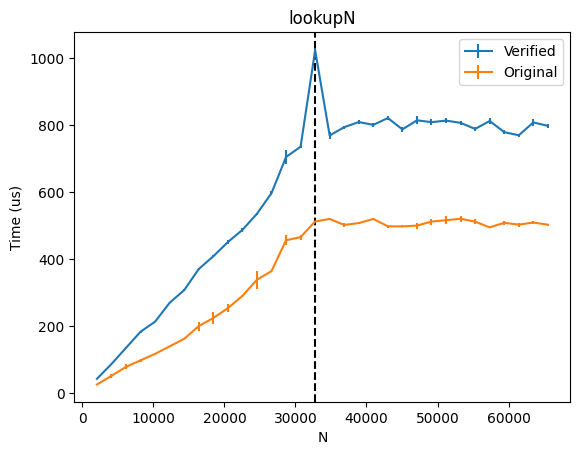

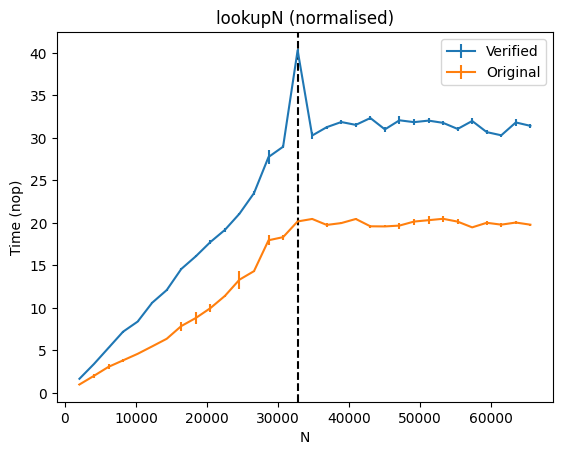

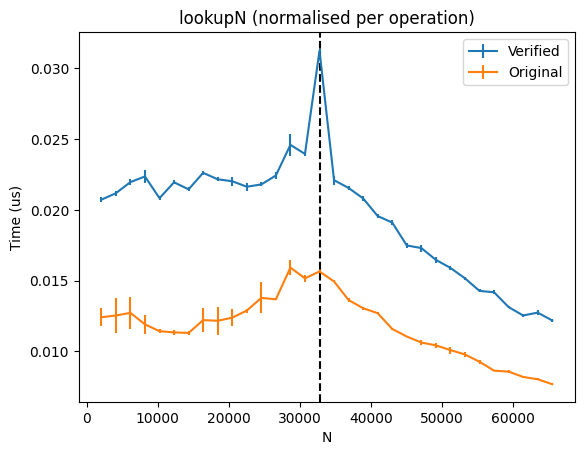

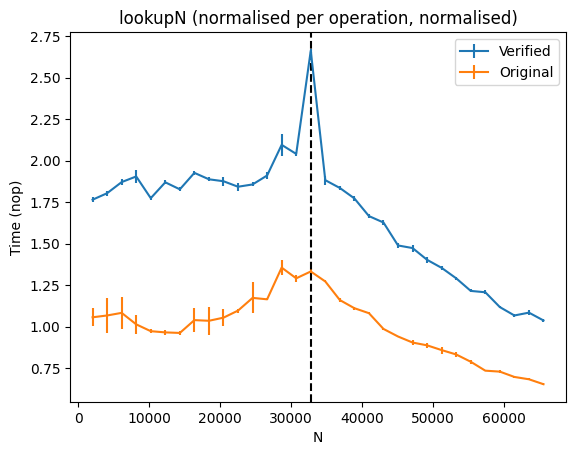

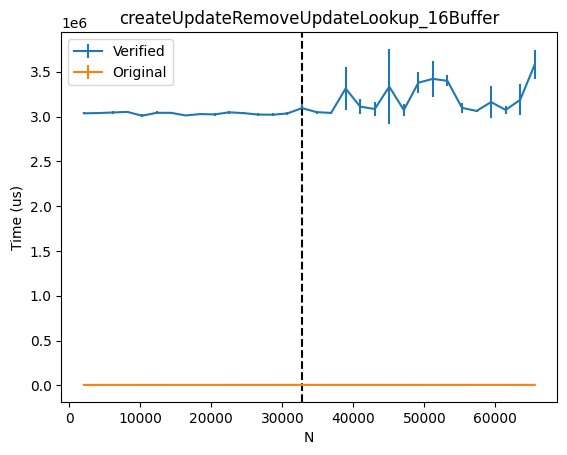

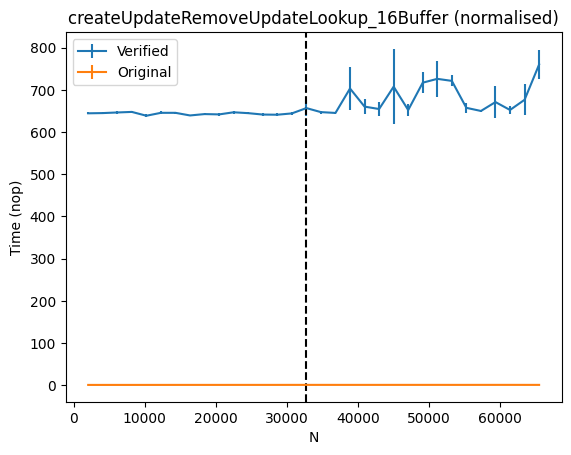

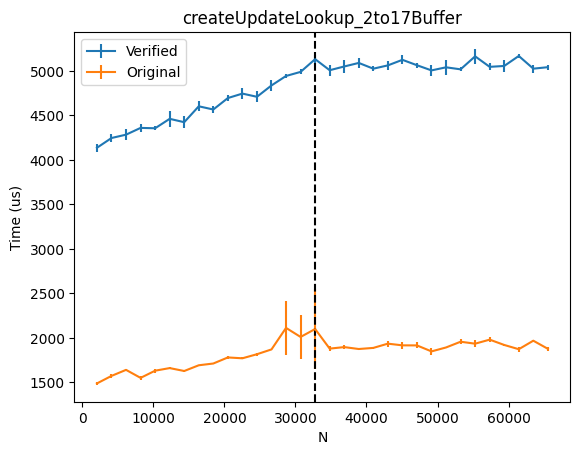

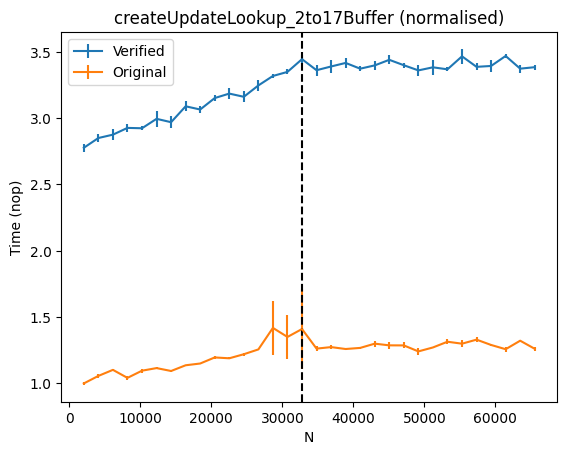

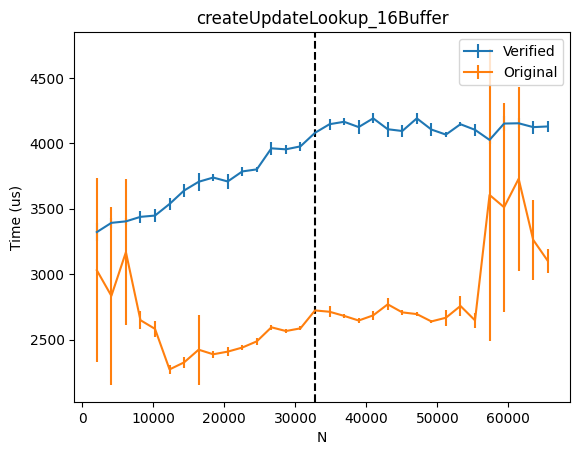

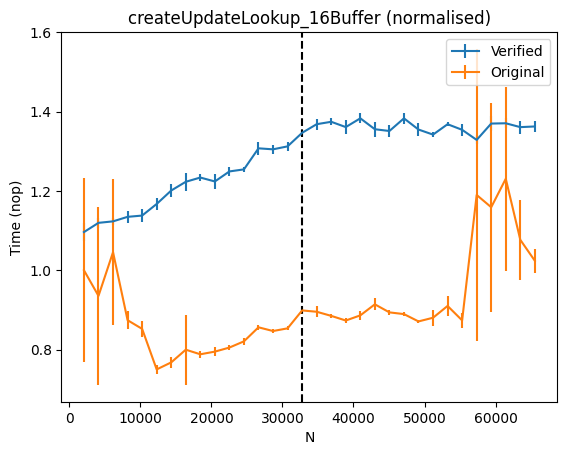

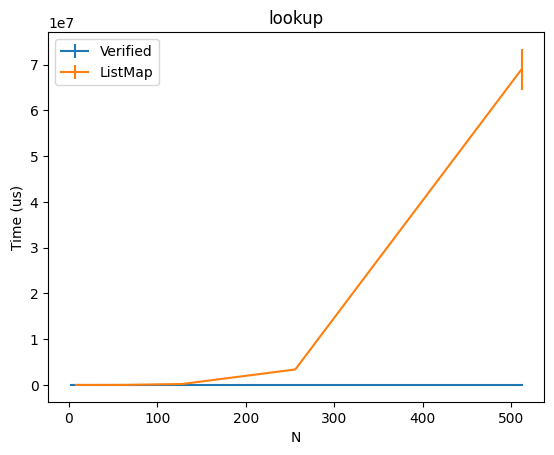

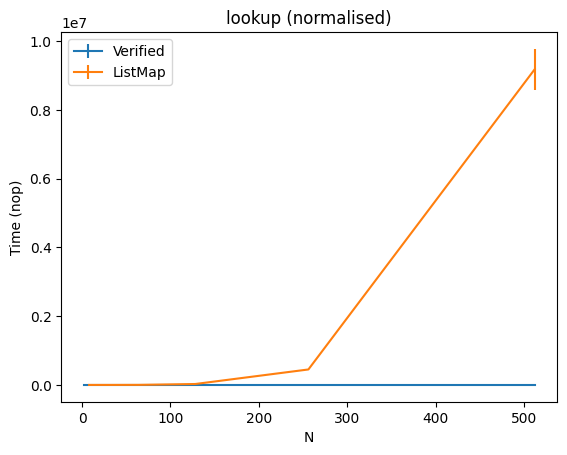

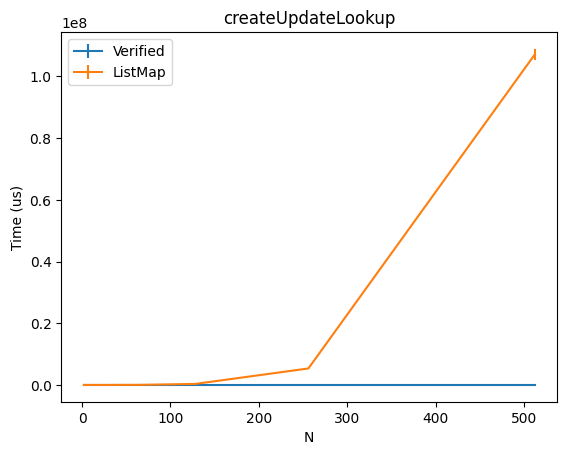

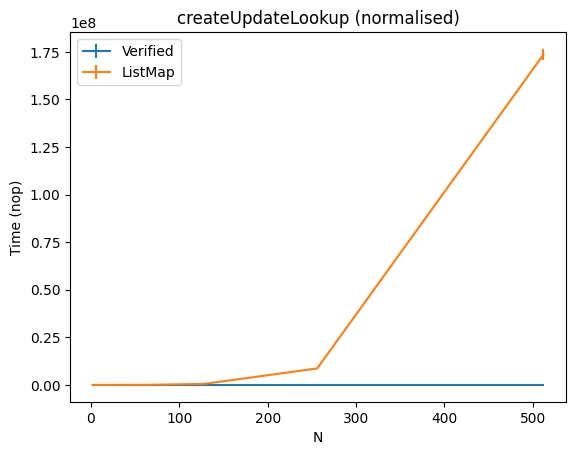

In [426]:
create_plots(benchmark_classes, benchmark_names, df, show_avg_for="lookup")

In [427]:
data = """[info] Benchmark                                                                 (keysListName)  (n)  Mode  Cnt     Score     Error  Units
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    1  avgt   10     0.115 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    2  avgt   10     0.237 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    3  avgt   10     0.588 ±   0.007  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    4  avgt   10     1.655 ±   0.016  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    5  avgt   10     5.118 ±   0.050  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    6  avgt   10    20.158 ±   0.106  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    7  avgt   10    76.503 ±   0.669  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    8  avgt   10   304.751 ±   2.763  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    9  avgt   10  1385.114 ±  10.554  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    1  avgt   10     0.090 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    2  avgt   10     0.124 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    3  avgt   10     0.292 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    4  avgt   10     0.646 ±   0.005  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    5  avgt   10     1.278 ±   0.016  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    6  avgt   10     2.777 ±   0.015  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    7  avgt   10     5.723 ±   0.037  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    8  avgt   10    12.019 ±   0.134  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    9  avgt   10    28.450 ±   0.188  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    1  avgt   10     0.184 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    2  avgt   10     0.236 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    3  avgt   10     0.333 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    4  avgt   10     0.848 ±   0.011  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    5  avgt   10     1.816 ±   0.013  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    6  avgt   10     3.789 ±   0.029  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    7  avgt   10     7.723 ±   0.045  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    8  avgt   10    16.037 ±   0.159  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    9  avgt   10    32.881 ±   0.223  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    3  avgt   10     0.094 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    4  avgt   10     0.308 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    5  avgt   10     1.151 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    6  avgt   10     4.940 ±   0.007  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    7  avgt   10    19.225 ±   0.083  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    8  avgt   10    83.202 ±   0.032  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    9  avgt   10   418.341 ±   0.239  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    1  avgt   10     0.036 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    2  avgt   10     0.047 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    3  avgt   10     0.051 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    4  avgt   10     0.088 ±   0.002  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    5  avgt   10     0.154 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    6  avgt   10     0.295 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    7  avgt   10     0.580 ±   0.009  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    8  avgt   10     1.423 ±   0.005  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    9  avgt   10     3.362 ±   0.022  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    1  avgt   10     0.036 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    2  avgt   10     0.050 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    3  avgt   10     0.062 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    4  avgt   10     0.120 ±   0.002  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    5  avgt   10     0.234 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    6  avgt   10     0.458 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    7  avgt   10     0.878 ±   0.011  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    8  avgt   10     2.129 ±   0.015  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    9  avgt   10     4.648 ±   0.019  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        2048  N/A  avgt   10  2187.650 ±  50.961  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        4096  N/A  avgt   10  2202.499 ±  11.125  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        6144  N/A  avgt   10  2227.342 ±  26.762  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        8192  N/A  avgt   10  2266.720 ±  57.035  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       10240  N/A  avgt   10  2221.805 ±  20.011  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       12288  N/A  avgt   10  2278.365 ±  10.919  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       14336  N/A  avgt   10  2321.459 ±  52.886  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       16384  N/A  avgt   10  2361.788 ±  17.685  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       18432  N/A  avgt   10  2353.412 ±   9.914  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       20480  N/A  avgt   10  2408.610 ±  32.196  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       22528  N/A  avgt   10  2436.588 ±  14.310  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       24576  N/A  avgt   10  2522.113 ±  14.485  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       26624  N/A  avgt   10  2529.343 ±  57.550  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       28672  N/A  avgt   10  2544.208 ±  22.547  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       30720  N/A  avgt   10  2571.295 ±  13.375  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       32768  N/A  avgt   10  2653.015 ±  73.546  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       34816  N/A  avgt   10  2627.542 ±  18.041  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       36864  N/A  avgt   10  2708.427 ±  15.036  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       38912  N/A  avgt   10  2662.364 ±  52.020  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       40960  N/A  avgt   10  2668.776 ±  30.494  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       43008  N/A  avgt   10  2705.043 ±  17.212  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       45056  N/A  avgt   10  2731.419 ±  48.736  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       47104  N/A  avgt   10  2705.249 ±  16.520  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       49152  N/A  avgt   10  2674.882 ±  49.739  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       51200  N/A  avgt   10  2658.975 ±  65.198  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       53248  N/A  avgt   10  2636.538 ±  18.323  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       55296  N/A  avgt   10  2682.003 ±  26.154  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       57344  N/A  avgt   10  2721.203 ±  41.620  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       59392  N/A  avgt   10  2660.279 ±  33.864  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       61440  N/A  avgt   10  2690.948 ±  21.849  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       63488  N/A  avgt   10  2653.237 ±  27.995  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       65536  N/A  avgt   10  2710.423 ±  12.752  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        2048  N/A  avgt   10  3250.668 ±  27.028  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        4096  N/A  avgt   10  3330.675 ±  48.990  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        6144  N/A  avgt   10  3375.708 ±  40.515  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        8192  N/A  avgt   10  3423.369 ±  44.415  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       10240  N/A  avgt   10  3476.466 ±  27.501  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       12288  N/A  avgt   10  3498.156 ±  51.071  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       14336  N/A  avgt   10  3544.034 ±  53.371  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       16384  N/A  avgt   10  3621.155 ±  23.501  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       18432  N/A  avgt   10  3642.732 ±  23.651  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       20480  N/A  avgt   10  3704.422 ±  25.605  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       22528  N/A  avgt   10  3762.221 ±  37.377  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       24576  N/A  avgt   10  3804.814 ±  49.366  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       26624  N/A  avgt   10  3792.507 ±  24.485  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       28672  N/A  avgt   10  3966.547 ±  39.937  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       30720  N/A  avgt   10  3948.180 ±  48.978  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       32768  N/A  avgt   10  4062.683 ±  23.321  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       34816  N/A  avgt   10  4067.776 ±  28.463  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       36864  N/A  avgt   10  4043.244 ±  45.643  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       38912  N/A  avgt   10  4010.519 ±  33.236  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       40960  N/A  avgt   10  3998.972 ±  38.073  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       43008  N/A  avgt   10  4023.377 ±  52.257  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       45056  N/A  avgt   10  4045.731 ±  60.896  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       47104  N/A  avgt   10  4108.775 ±  66.648  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       49152  N/A  avgt   10  4085.733 ±  42.190  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       51200  N/A  avgt   10  4104.523 ±  21.007  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       53248  N/A  avgt   10  4012.906 ±  33.780  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       55296  N/A  avgt   10  4007.256 ±  36.128  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       57344  N/A  avgt   10  4016.081 ±  21.200  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       59392  N/A  avgt   10  4074.817 ±  90.763  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       61440  N/A  avgt   10  3971.166 ±  51.427  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       63488  N/A  avgt   10  4045.289 ±  48.655  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       65536  N/A  avgt   10  4042.604 ±  29.123  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     2048  N/A  avgt   10  1501.094 ±  18.494  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     4096  N/A  avgt   10  1533.200 ±  33.818  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     6144  N/A  avgt   10  1608.941 ±  30.409  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     8192  N/A  avgt   10  1606.618 ±   7.683  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    10240  N/A  avgt   10  1590.798 ±   7.624  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    12288  N/A  avgt   10  1623.794 ±  20.359  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    14336  N/A  avgt   10  1652.405 ±  11.197  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    16384  N/A  avgt   10  1694.000 ±  28.131  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    18432  N/A  avgt   10  1731.186 ±  11.876  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    20480  N/A  avgt   10  1799.258 ±  15.549  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    22528  N/A  avgt   10  1779.078 ±  14.729  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    24576  N/A  avgt   10  2287.277 ± 895.419  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    26624  N/A  avgt   10  2451.172 ± 794.477  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    28672  N/A  avgt   10  3343.483 ± 892.772  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    30720  N/A  avgt   10  2610.290 ± 311.095  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    32768  N/A  avgt   10  2847.515 ± 201.734  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    34816  N/A  avgt   10  2230.682 ± 391.022  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    36864  N/A  avgt   10  2079.579 ±  53.798  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    38912  N/A  avgt   10  3375.307 ± 499.232  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    40960  N/A  avgt   10  3104.652 ± 526.497  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    43008  N/A  avgt   10  2367.708 ± 522.760  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    45056  N/A  avgt   10  1927.038 ±  23.477  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    47104  N/A  avgt   10  2281.786 ± 268.255  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    49152  N/A  avgt   10  1917.997 ±   8.797  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    51200  N/A  avgt   10  2468.230 ± 411.001  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    53248  N/A  avgt   10  1968.970 ±  48.020  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    55296  N/A  avgt   10  2062.849 ± 204.336  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    57344  N/A  avgt   10  2234.650 ± 193.161  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    59392  N/A  avgt   10  1878.079 ±  16.579  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    61440  N/A  avgt   10  1893.204 ±  16.386  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    63488  N/A  avgt   10  1912.473 ±  22.127  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    65536  N/A  avgt   10  1967.785 ±  22.624  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     2048  N/A  avgt   10  2000.803 ±  11.399  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     4096  N/A  avgt   10  2042.041 ±  41.877  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     6144  N/A  avgt   10  2101.616 ±  17.327  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     8192  N/A  avgt   10  2110.882 ±  17.003  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    10240  N/A  avgt   10  2218.447 ±  35.251  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    12288  N/A  avgt   10  2211.536 ±  38.309  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    14336  N/A  avgt   10  2285.196 ±  18.984  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    16384  N/A  avgt   10  2311.855 ±  48.411  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    18432  N/A  avgt   10  2350.854 ±  26.125  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    20480  N/A  avgt   10  2416.731 ±  12.462  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    22528  N/A  avgt   10  2433.255 ±  26.059  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    24576  N/A  avgt   10  2537.658 ±  34.073  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    26624  N/A  avgt   10  2588.508 ±  18.037  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    28672  N/A  avgt   10  2658.136 ±  48.924  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    30720  N/A  avgt   10  2678.702 ±  34.131  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    32768  N/A  avgt   10  2747.263 ±  35.718  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    34816  N/A  avgt   10  2741.936 ±  26.261  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    36864  N/A  avgt   10  2706.337 ±  16.172  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    38912  N/A  avgt   10  2714.965 ±  20.902  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    40960  N/A  avgt   10  2712.941 ±  41.391  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    43008  N/A  avgt   10  2712.597 ±  37.134  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    45056  N/A  avgt   10  2714.636 ±  28.373  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    47104  N/A  avgt   10  2755.320 ±  45.058  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    49152  N/A  avgt   10  2699.964 ±  31.386  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    51200  N/A  avgt   10  2741.093 ±  19.835  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    53248  N/A  avgt   10  2710.041 ±  23.859  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    55296  N/A  avgt   10  2707.903 ±  35.877  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    57344  N/A  avgt   10  2746.064 ±  29.444  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    59392  N/A  avgt   10  2744.795 ±  27.671  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    61440  N/A  avgt   10  2701.461 ±  17.858  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    63488  N/A  avgt   10  2755.948 ±  53.327  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    65536  N/A  avgt   10  2703.847 ±  59.372  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            2048  N/A  avgt   10  4649.186 ±  37.089  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            4096  N/A  avgt   10  4707.537 ±  27.241  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            6144  N/A  avgt   10  4755.847 ±  63.848  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            8192  N/A  avgt   10  4761.286 ±  23.854  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           10240  N/A  avgt   10  4883.495 ±  43.817  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           12288  N/A  avgt   10  4874.568 ±  93.530  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           14336  N/A  avgt   10  4868.028 ±  53.792  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           16384  N/A  avgt   10  4968.983 ±  65.027  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           18432  N/A  avgt   10  4885.579 ±  83.392  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           20480  N/A  avgt   10  4917.991 ±  25.967  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           22528  N/A  avgt   10  5003.039 ±  30.618  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           24576  N/A  avgt   10  5033.583 ±  41.308  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           26624  N/A  avgt   10  5123.543 ±  36.744  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           28672  N/A  avgt   10  5086.828 ± 119.886  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           30720  N/A  avgt   10  5187.900 ±  35.054  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           32768  N/A  avgt   10  5233.783 ± 104.868  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           34816  N/A  avgt   10  5231.128 ± 202.591  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           36864  N/A  avgt   10  5138.395 ±  43.795  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           38912  N/A  avgt   10  5616.021 ±  36.742  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           40960  N/A  avgt   10  5144.281 ±  33.734  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           43008  N/A  avgt   10  5135.435 ±  19.390  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           45056  N/A  avgt   10  5125.161 ±  54.310  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           47104  N/A  avgt   10  5149.763 ±  37.123  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           49152  N/A  avgt   10  5239.285 ±  67.855  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           51200  N/A  avgt   10  5223.983 ±  43.748  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           53248  N/A  avgt   10  5139.727 ±  28.293  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           55296  N/A  avgt   10  5340.468 ±  58.825  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           57344  N/A  avgt   10  5226.320 ±  27.760  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           59392  N/A  avgt   10  5241.053 ±  86.475  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           61440  N/A  avgt   10  5199.472 ±  65.323  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           63488  N/A  avgt   10  5278.117 ±  24.175  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           65536  N/A  avgt   10  5179.800 ±  71.818  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            2048  N/A  avgt   10  5725.986 ±  66.077  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            4096  N/A  avgt   10  5736.851 ±  83.319  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            6144  N/A  avgt   10  5844.569 ±  75.874  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            8192  N/A  avgt   10  5813.438 ±  49.306  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           10240  N/A  avgt   10  5998.963 ± 108.578  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           12288  N/A  avgt   10  6066.798 ±  99.161  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           14336  N/A  avgt   10  6184.481 ±  95.789  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           16384  N/A  avgt   10  6368.380 ±  82.197  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           18432  N/A  avgt   10  6233.460 ±  33.225  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           20480  N/A  avgt   10  6390.362 ±  81.857  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           22528  N/A  avgt   10  6529.438 ±  47.538  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           24576  N/A  avgt   10  6600.744 ±  37.299  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           26624  N/A  avgt   10  6635.387 ±  69.194  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           28672  N/A  avgt   10  6708.067 ±  39.999  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           30720  N/A  avgt   10  8168.239 ±  92.124  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           32768  N/A  avgt   10  6817.251 ±  55.377  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           34816  N/A  avgt   10  6831.992 ±  91.881  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           36864  N/A  avgt   10  6886.936 ±  35.278  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           38912  N/A  avgt   10  6870.885 ±  47.384  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           40960  N/A  avgt   10  6868.453 ±  39.540  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           43008  N/A  avgt   10  6791.316 ±  40.148  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           45056  N/A  avgt   10  6843.422 ±  75.657  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           47104  N/A  avgt   10  6807.955 ±  90.155  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           49152  N/A  avgt   10  6866.423 ±  38.055  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           51200  N/A  avgt   10  6927.436 ±  62.973  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           53248  N/A  avgt   10  6882.524 ±  42.096  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           55296  N/A  avgt   10  6888.785 ±  98.023  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           57344  N/A  avgt   10  6942.363 ± 156.795  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           59392  N/A  avgt   10  6808.143 ±  54.222  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           61440  N/A  avgt   10  6759.329 ±  33.689  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           63488  N/A  avgt   10  6863.639 ±  48.409  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           65536  N/A  avgt   10  6860.029 ±  44.052  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            2048  N/A  avgt   10    21.352 ±   0.108  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            4096  N/A  avgt   10    45.639 ±   0.903  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            6144  N/A  avgt   10    67.594 ±   0.364  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            8192  N/A  avgt   10    88.308 ±   0.647  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           10240  N/A  avgt   10   111.415 ±   0.907  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           12288  N/A  avgt   10   138.226 ±   0.818  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           14336  N/A  avgt   10   164.822 ±   1.000  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           16384  N/A  avgt   10   191.925 ±   1.776  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           18432  N/A  avgt   10   218.539 ±   1.441  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           20480  N/A  avgt   10   244.779 ±   2.433  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           22528  N/A  avgt   10   288.818 ±   2.411  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           24576  N/A  avgt   10   330.781 ±   2.068  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           26624  N/A  avgt   10   367.324 ±   2.548  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           28672  N/A  avgt   10   411.955 ±   3.786  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           30720  N/A  avgt   10   458.663 ±   2.945  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           32768  N/A  avgt   10   503.482 ±   6.155  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           34816  N/A  avgt   10   507.660 ±   3.269  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           36864  N/A  avgt   10   504.268 ±   7.919  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           38912  N/A  avgt   10   508.096 ±   2.939  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           40960  N/A  avgt   10   700.181 ±   5.566  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           43008  N/A  avgt   10   509.064 ±   3.685  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           45056  N/A  avgt   10   501.864 ±   2.720  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           47104  N/A  avgt   10   499.338 ±   5.424  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           49152  N/A  avgt   10   511.777 ±   3.038  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           51200  N/A  avgt   10   500.470 ±   2.965  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           53248  N/A  avgt   10   507.609 ±   7.382  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           55296  N/A  avgt   10   499.647 ±   7.300  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           57344  N/A  avgt   10   514.749 ±   3.405  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           59392  N/A  avgt   10   509.426 ±   6.155  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           61440  N/A  avgt   10   516.185 ±   3.295  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           63488  N/A  avgt   10   506.313 ±   2.822  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           65536  N/A  avgt   10   494.647 ±   4.273  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            2048  N/A  avgt   10    44.765 ±   0.291  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            4096  N/A  avgt   10    90.803 ±   0.537  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            6144  N/A  avgt   10   123.486 ±   0.768  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            8192  N/A  avgt   10   184.353 ±   1.151  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           10240  N/A  avgt   10   211.052 ±   3.167  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           12288  N/A  avgt   10   275.333 ±   2.424  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           14336  N/A  avgt   10   330.395 ±   2.509  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           16384  N/A  avgt   10   372.355 ±   3.003  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           18432  N/A  avgt   10   423.982 ±   2.396  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           20480  N/A  avgt   10   440.336 ±   3.396  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           22528  N/A  avgt   10   490.277 ±  13.121  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           24576  N/A  avgt   10   554.877 ±   7.673  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           26624  N/A  avgt   10   650.501 ±   3.915  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           28672  N/A  avgt   10   682.779 ±   4.202  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           30720  N/A  avgt   10   701.805 ±   6.179  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           32768  N/A  avgt   10   820.166 ±   4.342  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           34816  N/A  avgt   10   805.784 ±   4.634  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           36864  N/A  avgt   10   829.968 ±   6.867  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           38912  N/A  avgt   10   789.245 ±   5.021  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           40960  N/A  avgt   10   790.411 ±  14.535  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           43008  N/A  avgt   10   814.142 ±   5.133  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           45056  N/A  avgt   10   803.403 ±   4.609  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           47104  N/A  avgt   10   818.104 ±  10.316  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           49152  N/A  avgt   10   823.571 ±   4.798  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           51200  N/A  avgt   10   816.962 ±   5.012  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           53248  N/A  avgt   10   804.999 ±   4.437  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           55296  N/A  avgt   10   822.569 ±   4.568  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           57344  N/A  avgt   10   799.514 ±   4.384  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           59392  N/A  avgt   10   789.516 ±  10.551  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           61440  N/A  avgt   10   826.785 ±   7.387  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           63488  N/A  avgt   10   778.836 ±   4.362  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           65536  N/A  avgt   10   819.363 ±   5.763  us/op""".strip().split("\n")

data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["MutableLongMapBenchmark", "LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if n in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

{'MutableLongMapBenchmark': ['lookupN',
  'createUpdateRemoveUpdateLookup_16Buffer',
  'createUpdateLookup_2to17Buffer',
  'createUpdateLookup_16Buffer'],
 'LongListMapBenchmark': ['lookup', 'createUpdateLookup']}

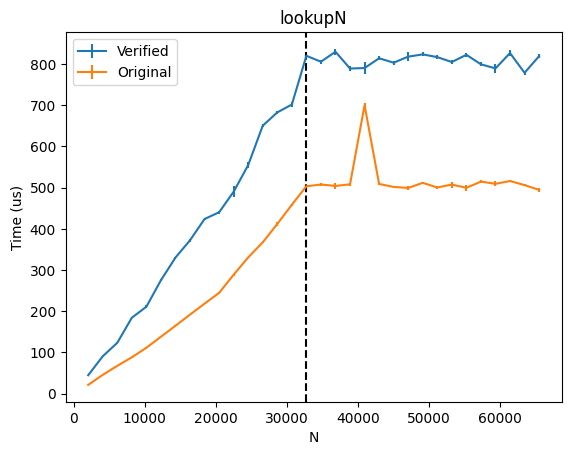

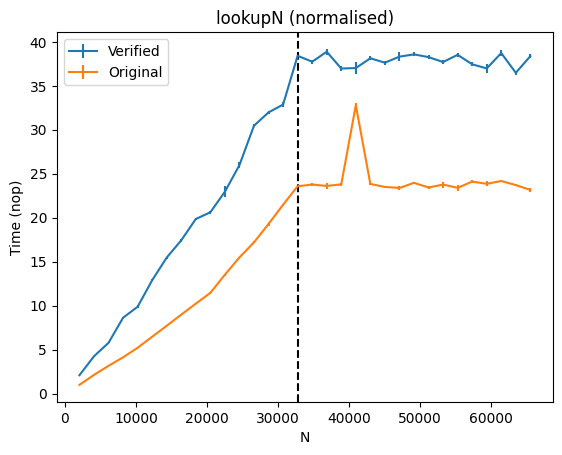

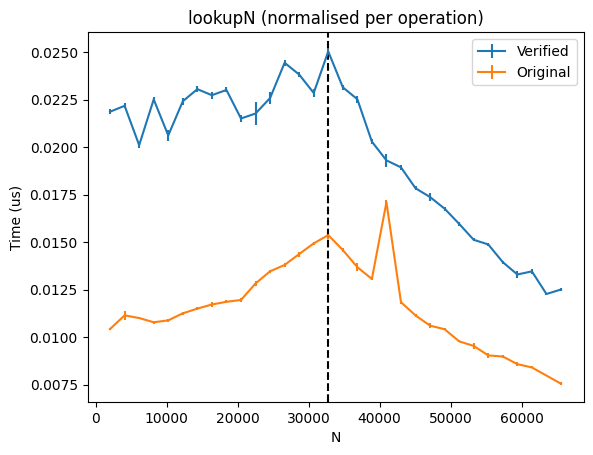

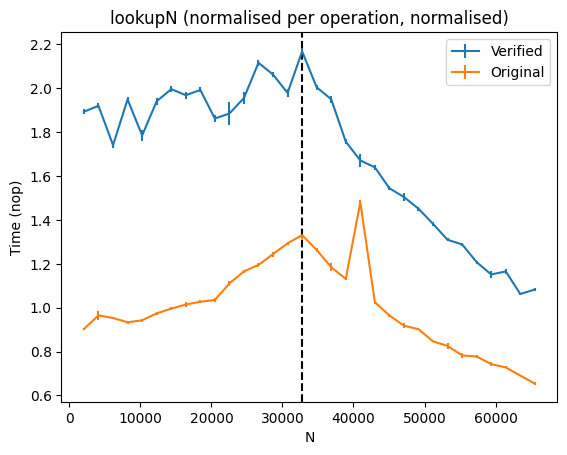

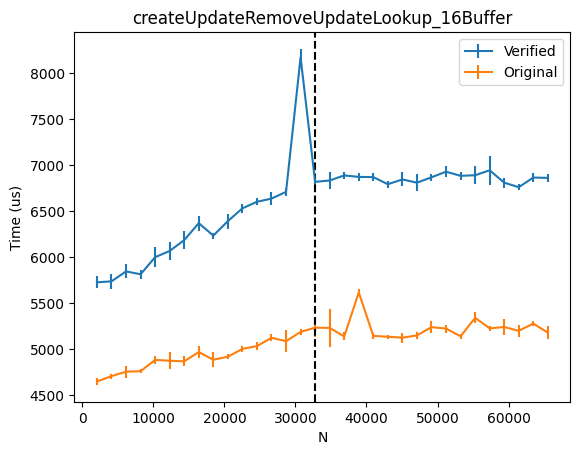

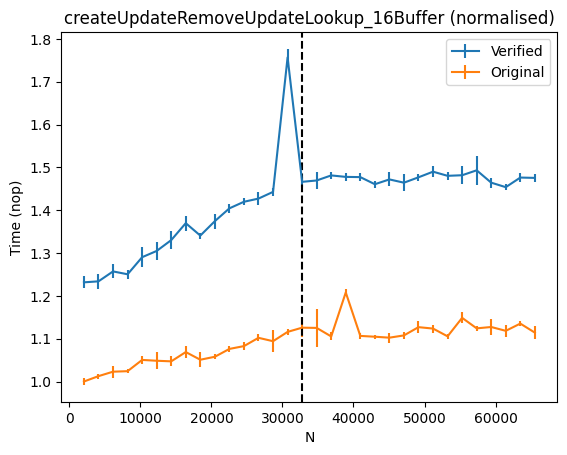

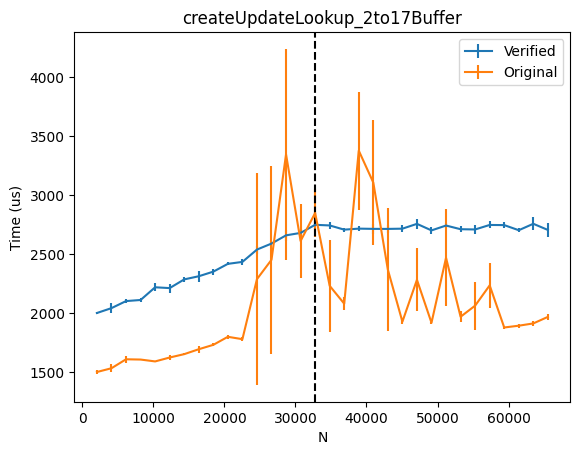

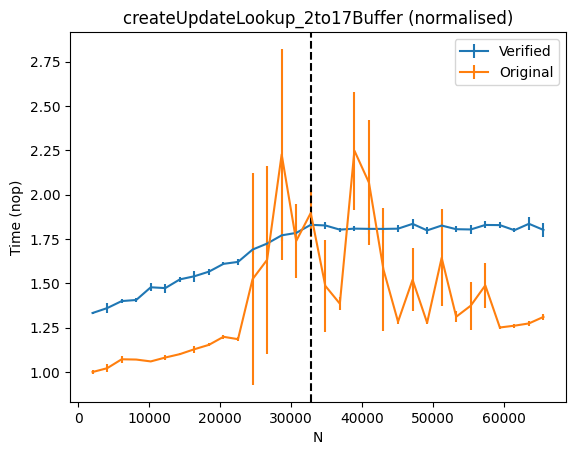

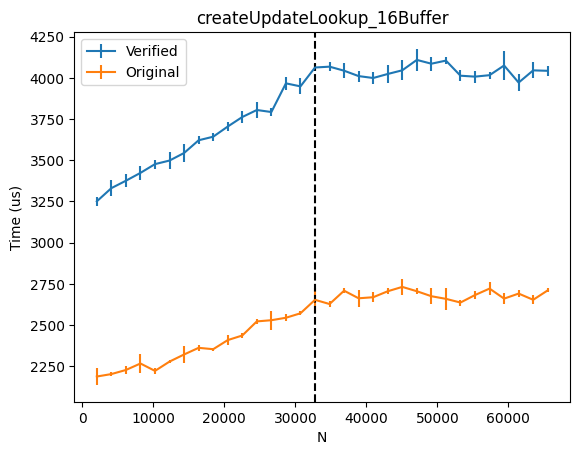

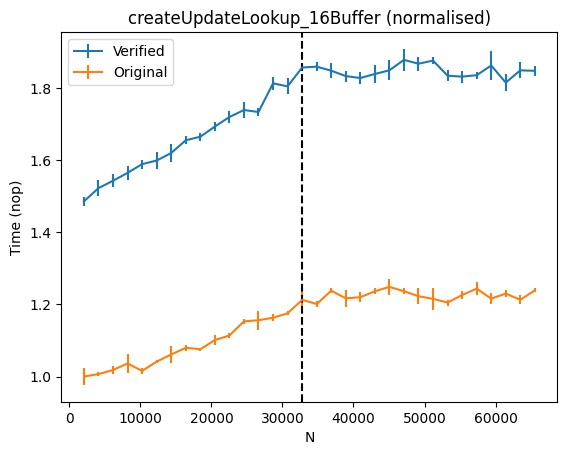

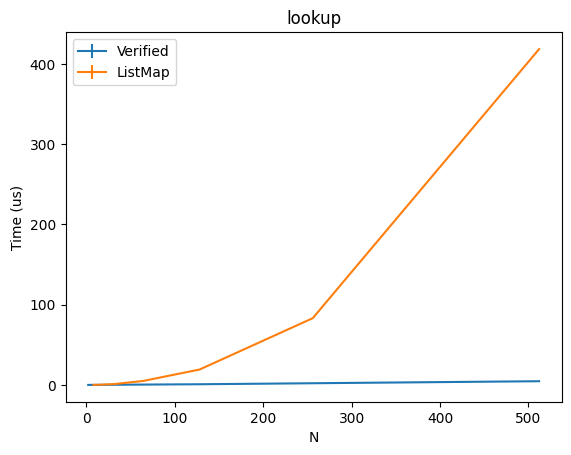

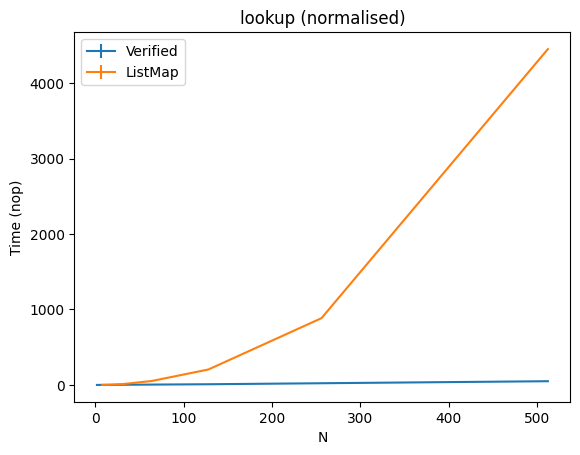

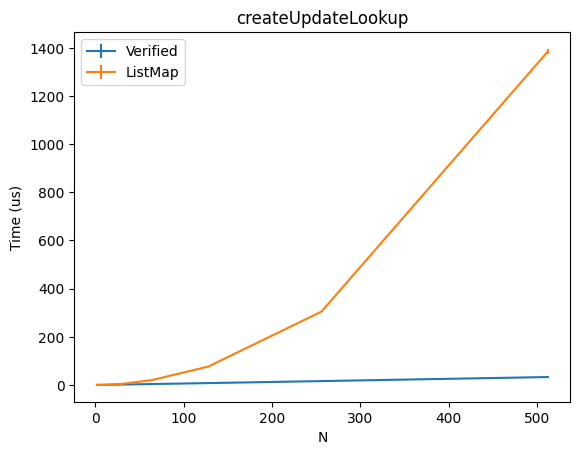

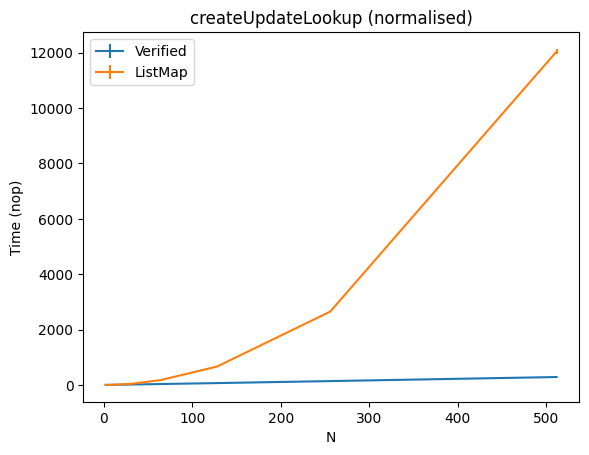

In [428]:
create_plots(benchmark_classes, benchmark_names, df)

In [429]:
data = """[info] Benchmark                                                                 (keysListName)  Mode  Cnt     Score   Error  Units
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        2048  avgt   1    2364.363    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        4096  avgt   1    2345.803    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        6144  avgt   1    2307.094    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        8192  avgt   1    2381.257    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       10240  avgt   1    2385.823    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       12288  avgt   1    2392.297    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       14336  avgt   1    2469.214    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       16384  avgt   1    2413.072    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       18432  avgt   1    2498.515    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       20480  avgt   1    2504.337    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       22528  avgt   1    2561.860    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       24576  avgt   1    2625.225    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       26624  avgt   1    2992.137    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       28672  avgt   1    2714.972    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       30720  avgt   1    2794.663    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       32768  avgt   1    2846.969    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       34816  avgt   1    2770.211    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       36864  avgt   1    2816.504    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       38912  avgt   1    2739.701    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       40960  avgt   1    2779.288    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       43008  avgt   1    2802.126    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       45056  avgt   1    2818.447    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       47104  avgt   1    2818.127    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       49152  avgt   1    2733.944    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       51200  avgt   1    2781.941    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       53248  avgt   1    2814.954    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       55296  avgt   1    2829.873    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       57344  avgt   1    2887.388    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       59392  avgt   1    3093.572    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       61440  avgt   1    2770.084    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       63488  avgt   1    2762.057    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       65536  avgt   1    2773.013    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        2048  avgt   1    3734.575    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        4096  avgt   1    3638.325    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        6144  avgt   1    3776.421    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        8192  avgt   1    3719.821    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       10240  avgt   1    3777.432    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       12288  avgt   1    3851.432    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       14336  avgt   1    3913.391    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       16384  avgt   1    3939.075    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       18432  avgt   1    3974.127    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       20480  avgt   1    4062.238    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       22528  avgt   1    4096.975    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       24576  avgt   1    4199.826    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       26624  avgt   1    4278.750    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       28672  avgt   1    4304.741    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       30720  avgt   1    4336.152    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       32768  avgt   1    4402.900    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       34816  avgt   1    4388.345    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       36864  avgt   1    4436.245    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       38912  avgt   1    4349.732    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       40960  avgt   1    4373.127    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       43008  avgt   1    4463.891    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       45056  avgt   1    4374.031    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       47104  avgt   1    4533.931    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       49152  avgt   1    4439.463    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       51200  avgt   1    4452.594    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       53248  avgt   1    4407.166    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       55296  avgt   1    4399.948    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       57344  avgt   1    4475.490    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       59392  avgt   1    4438.497    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       61440  avgt   1    4421.922    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       63488  avgt   1    4367.382    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       65536  avgt   1    4405.149    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     2048  avgt   1    1568.502    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     4096  avgt   1    1674.264    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     6144  avgt   1    1567.871    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     8192  avgt   1    1644.539    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    10240  avgt   1    1771.205    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    12288  avgt   1    1703.358    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    14336  avgt   1    1779.538    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    16384  avgt   1    1839.867    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    18432  avgt   1    1768.470    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    20480  avgt   1    1795.392    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    22528  avgt   1    1869.433    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    24576  avgt   1    1939.821    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    26624  avgt   1    1902.170    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    28672  avgt   1    1917.859    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    30720  avgt   1    1907.242    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    32768  avgt   1    2011.940    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    34816  avgt   1    1959.155    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    36864  avgt   1    2044.842    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    38912  avgt   1    2001.365    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    40960  avgt   1    1994.949    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    43008  avgt   1    1973.104    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    45056  avgt   1    1955.890    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    47104  avgt   1    2021.464    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    49152  avgt   1    1996.414    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    51200  avgt   1    1966.157    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    53248  avgt   1    1988.610    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    55296  avgt   1    1975.337    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    57344  avgt   1    2041.567    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    59392  avgt   1    2036.239    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    61440  avgt   1    1991.771    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    63488  avgt   1    2001.185    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    65536  avgt   1    1961.109    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     2048  avgt   1    2151.452    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     4096  avgt   1    2209.786    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     6144  avgt   1    2178.835    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     8192  avgt   1    2224.942    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    10240  avgt   1    2297.038    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    12288  avgt   1    2373.589    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    14336  avgt   1    2440.132    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    16384  avgt   1    2481.470    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    18432  avgt   1    2493.104    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    20480  avgt   1    2539.622    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    22528  avgt   1    2639.278    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    24576  avgt   1    2648.954    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    26624  avgt   1    2745.196    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    28672  avgt   1    2853.469    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    30720  avgt   1    2759.931    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    32768  avgt   1    2890.197    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    34816  avgt   1    2844.661    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    36864  avgt   1    2840.995    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    38912  avgt   1    2893.935    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    40960  avgt   1    2916.180    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    43008  avgt   1    2834.331    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    45056  avgt   1    2880.589    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    47104  avgt   1    2797.776    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    49152  avgt   1    2808.113    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    51200  avgt   1    2928.776    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    53248  avgt   1    2878.234    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    55296  avgt   1    2860.002    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    57344  avgt   1    2919.146    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    59392  avgt   1    2894.606    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    61440  avgt   1    2842.042    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    63488  avgt   1    2876.043    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    65536  avgt   1    2892.867    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            2048  avgt   1    5170.790    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            4096  avgt   1    4997.840    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            6144  avgt   1    5066.545    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            8192  avgt   1    4987.791    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           10240  avgt   1    5184.813    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           12288  avgt   1    5163.015    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           14336  avgt   1    5104.380    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           16384  avgt   1    5132.464    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           18432  avgt   1    5062.723    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           20480  avgt   1    5277.378    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           22528  avgt   1    5297.574    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           24576  avgt   1    5302.404    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           26624  avgt   1    5369.644    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           28672  avgt   1    5359.811    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           30720  avgt   1    5565.335    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           32768  avgt   1    5458.085    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           34816  avgt   1    5369.544    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           36864  avgt   1    5647.591    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           38912  avgt   1    5675.121    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           40960  avgt   1    5539.023    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           43008  avgt   1    5568.739    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           45056  avgt   1    5577.389    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           47104  avgt   1    5605.575    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           49152  avgt   1    5288.733    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           51200  avgt   1    5569.031    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           53248  avgt   1    5420.211    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           55296  avgt   1    5488.810    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           57344  avgt   1    5560.899    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           59392  avgt   1    5423.416    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           61440  avgt   1    5425.463    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           63488  avgt   1    5542.590    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           65536  avgt   1    5488.176    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            2048  avgt   1    6185.689    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            4096  avgt   1    6320.454    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            6144  avgt   1    6683.723    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            8192  avgt   1    6329.692    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           10240  avgt   1    6374.873    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           12288  avgt   1    6390.680    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           14336  avgt   1    6610.885    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           16384  avgt   1    6562.301    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           18432  avgt   1    6625.560    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           20480  avgt   1    6785.125    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           22528  avgt   1    6933.380    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           24576  avgt   1    6963.173    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           26624  avgt   1    6909.360    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           28672  avgt   1    7002.177    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           30720  avgt   1    7064.501    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           32768  avgt   1    7101.279    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           34816  avgt   1    7074.563    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           36864  avgt   1    7194.725    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           38912  avgt   1    7143.758    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           40960  avgt   1    7052.342    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           43008  avgt   1    7255.982    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           45056  avgt   1    7357.363    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           47104  avgt   1    7274.660    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           49152  avgt   1    7180.152    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           51200  avgt   1    6955.563    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           53248  avgt   1    7132.039    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           55296  avgt   1    7035.408    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           57344  avgt   1    7090.624    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           59392  avgt   1    7437.625    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           61440  avgt   1    7168.142    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           63488  avgt   1    7117.588    ± 0.005      us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           65536  avgt   1    7097.973    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            2048  avgt   1      22.604    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            4096  avgt   1      46.721    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            6144  avgt   1      70.585    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            8192  avgt   1      94.713    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           10240  avgt   1     117.738    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           12288  avgt   1     142.705    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           14336  avgt   1     169.055    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           16384  avgt   1     202.541    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           18432  avgt   1     226.329    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           20480  avgt   1     259.844    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           22528  avgt   1     284.011    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           24576  avgt   1     339.283    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           26624  avgt   1     379.600    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           28672  avgt   1     421.143    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           30720  avgt   1     484.824    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           32768  avgt   1     540.287    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           34816  avgt   1     519.977    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           36864  avgt   1     533.713    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           38912  avgt   1     539.261    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           40960  avgt   1     521.127    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           43008  avgt   1     522.813    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           45056  avgt   1     527.283    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           47104  avgt   1     527.974    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           49152  avgt   1     535.580    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           51200  avgt   1     511.915    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           53248  avgt   1     535.914    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           55296  avgt   1     512.207    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           57344  avgt   1     513.247    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           59392  avgt   1     561.508    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           61440  avgt   1     520.005    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           63488  avgt   1     508.235    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           65536  avgt   1     515.721    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            2048  avgt   1      49.312    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            4096  avgt   1      91.314    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            6144  avgt   1     145.282    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            8192  avgt   1     162.370    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           10240  avgt   1     247.887    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           12288  avgt   1     302.783    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           14336  avgt   1     350.672    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           16384  avgt   1     408.776    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           18432  avgt   1     459.147    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           20480  avgt   1     507.345    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           22528  avgt   1     581.164    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           24576  avgt   1     610.808    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           26624  avgt   1     652.305    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           28672  avgt   1     720.858    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           30720  avgt   1     804.368    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           32768  avgt   1     864.890    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           34816  avgt   1    1205.219    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           36864  avgt   1     867.415    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           38912  avgt   1     897.599    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           40960  avgt   1     875.447    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           43008  avgt   1     860.022    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           45056  avgt   1     869.093    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           47104  avgt   1     833.958    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           49152  avgt   1     864.714    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           51200  avgt   1     869.178    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           53248  avgt   1     858.724    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           55296  avgt   1     869.533    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           57344  avgt   1     885.228    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           59392  avgt   1     857.288    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           61440  avgt   1     873.900    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           63488  avgt   1     866.223    ± 0.005      us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           65536  avgt   1     873.342    ± 0.005      us/op
""".strip().split("\n")

data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["MutableLongMapBenchmark", "LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if n in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

{'MutableLongMapBenchmark': ['lookupN',
  'createUpdateRemoveUpdateLookup_16Buffer',
  'createUpdateLookup_2to17Buffer',
  'createUpdateLookup_16Buffer'],
 'LongListMapBenchmark': []}

## With Array.fill + indirection

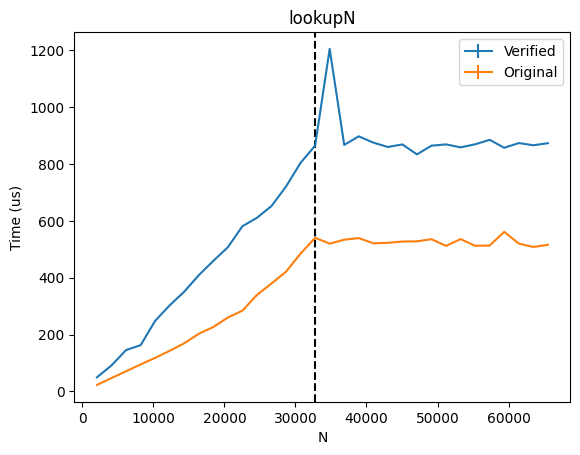

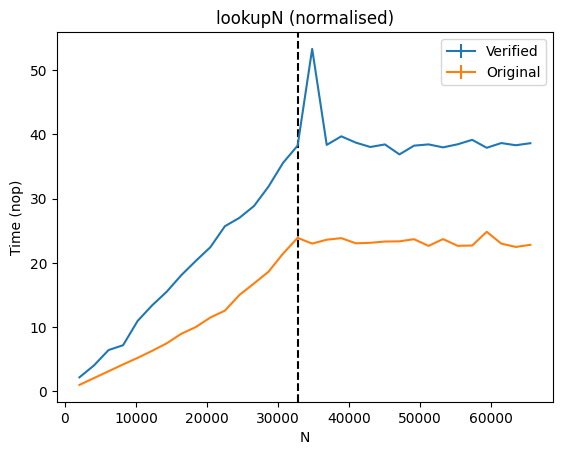

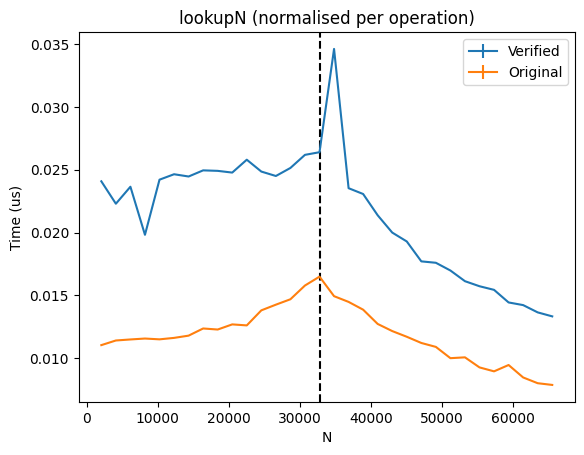

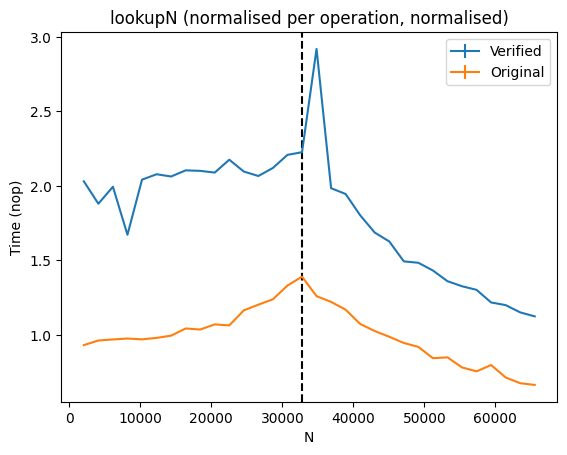

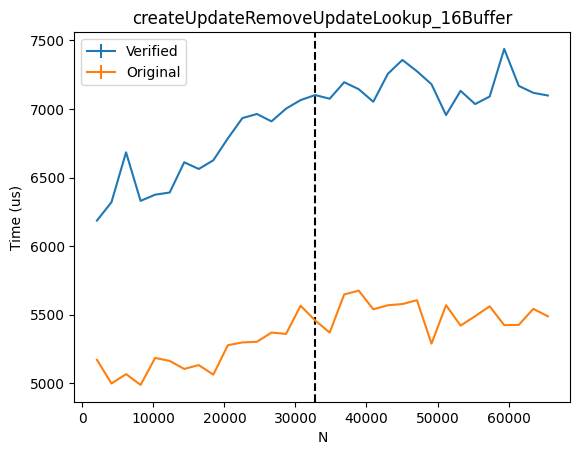

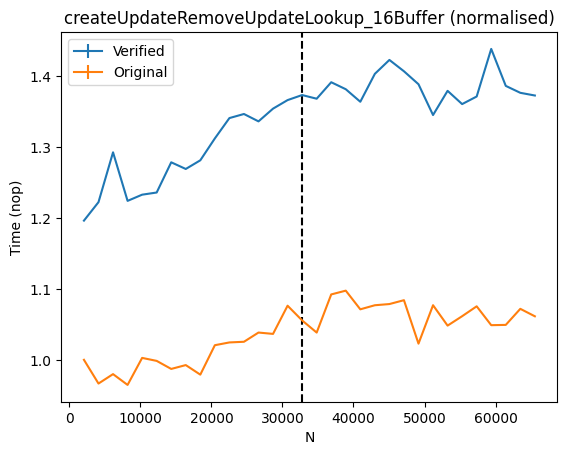

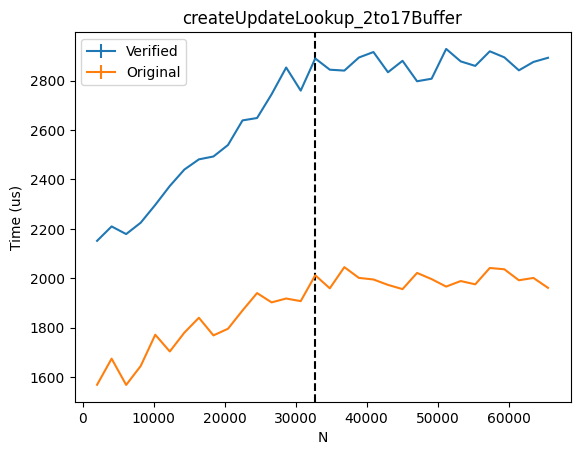

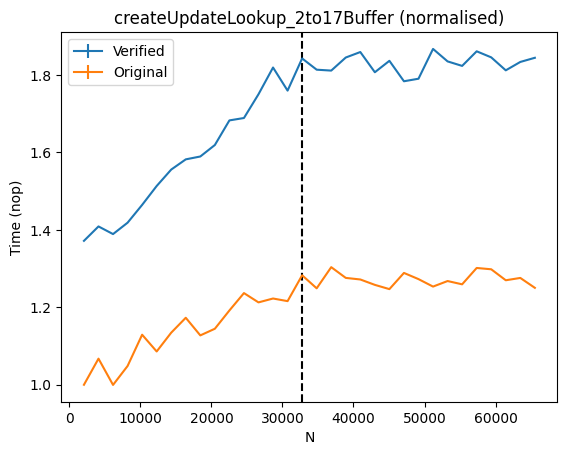

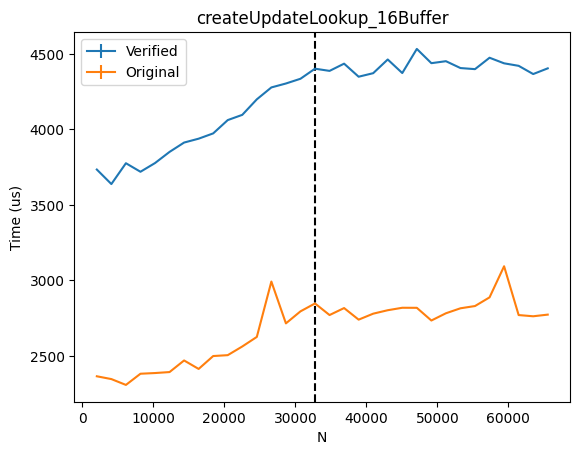

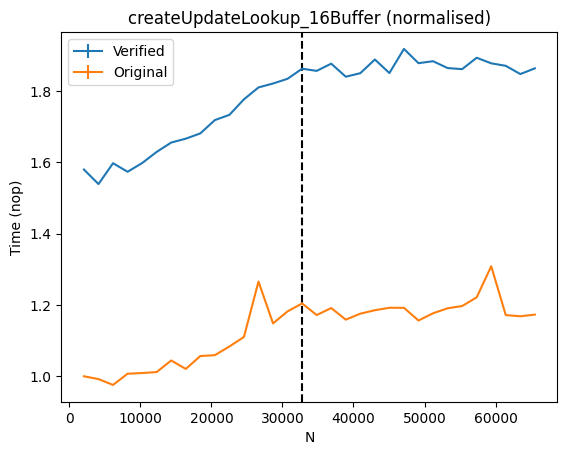

In [430]:
create_plots(benchmark_classes, benchmark_names, df)

## With new Array of null and asInstanceOf

In [431]:
data = """[info] Benchmark                                                                 (keysListName)  Mode  Cnt     Score   Error  Units
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        4096  avgt   1    2385.683 ± 0.005         us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        8192  avgt   1    2372.056   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       12288  avgt   1    2330.256   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       16384  avgt   1    2463.047   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       20480  avgt   1    2510.383   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       24576  avgt   1    2602.808   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       28672  avgt   1    2942.499   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       32768  avgt   1    4336.837   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       36864  avgt   1    3009.545   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       40960  avgt   1    3094.867   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       45056  avgt   1    2997.882   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       49152  avgt   1    3138.352   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       53248  avgt   1    3485.722   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       57344  avgt   1    6406.636   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       61440  avgt   1    3927.437   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       65536  avgt   1    3245.392   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        4096  avgt   1    3029.851   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        8192  avgt   1    4177.352   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       12288  avgt   1    3851.197   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       16384  avgt   1    3372.584   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       20480  avgt   1    3517.600   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       24576  avgt   1    3548.339   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       28672  avgt   1    4001.358   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       32768  avgt   1    4440.110   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       36864  avgt   1    5852.156   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       40960  avgt   1    4852.416   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       45056  avgt   1    4838.379   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       49152  avgt   1    3961.473   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       53248  avgt   1    4280.372   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       57344  avgt   1    4524.884   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       61440  avgt   1    5254.938   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       65536  avgt   1    4384.839   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     4096  avgt   1    1934.499   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     8192  avgt   1    2096.936   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    12288  avgt   1    2611.926   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    16384  avgt   1    3536.500   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    20480  avgt   1    3645.884   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    24576  avgt   1    3922.240   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    28672  avgt   1    3330.068   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    32768  avgt   1    2666.977   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    36864  avgt   1    2496.112   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    40960  avgt   1    2844.856   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    45056  avgt   1    2969.642   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    49152  avgt   1    2569.271   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    53248  avgt   1    2494.157   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    57344  avgt   1    2564.394   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    61440  avgt   1    2491.880   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    65536  avgt   1    2408.185   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     4096  avgt   1    2013.049   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     8192  avgt   1    2074.406   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    12288  avgt   1    2220.199   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    16384  avgt   1    2131.743   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    20480  avgt   1    2446.587   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    24576  avgt   1    2835.005   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    28672  avgt   1    2226.895   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    32768  avgt   1    2129.059   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    36864  avgt   1    2201.058   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    40960  avgt   1    2109.620   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    45056  avgt   1    2186.301   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    49152  avgt   1    2160.571   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    53248  avgt   1    2133.668   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    57344  avgt   1    2142.493   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    61440  avgt   1    2169.960   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    65536  avgt   1    2161.811   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            4096  avgt   1    4917.267   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            8192  avgt   1    5032.282   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           12288  avgt   1    5032.276   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           16384  avgt   1    5197.244   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           20480  avgt   1    5339.782   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           24576  avgt   1    5140.840   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           28672  avgt   1    5306.909   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           32768  avgt   1    5292.733   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           36864  avgt   1    5362.125   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           40960  avgt   1    5279.343   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           45056  avgt   1    5397.935   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           49152  avgt   1    5428.427   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           53248  avgt   1    5445.969   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           57344  avgt   1    5307.036   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           61440  avgt   1    5370.195   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           65536  avgt   1    5462.845   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            4096  avgt   1    4622.322   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            8192  avgt   1    4675.926   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           12288  avgt   1    4958.498   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           16384  avgt   1    5070.775   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           20480  avgt   1    5277.204   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           24576  avgt   1    5116.641   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           28672  avgt   1    5439.176   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           32768  avgt   1    5564.227   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           36864  avgt   1    5558.022   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           40960  avgt   1    5493.558   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           45056  avgt   1    5498.620   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           49152  avgt   1    5528.846   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           53248  avgt   1    5515.661   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           57344  avgt   1    5493.673   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           61440  avgt   1    5780.782   ± 0.005       us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           65536  avgt   1    5467.946   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            4096  avgt   1      43.599   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            8192  avgt   1      92.411   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           12288  avgt   1     143.227   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           16384  avgt   1     201.117   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           20480  avgt   1     256.278   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           24576  avgt   1     350.820   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           28672  avgt   1     422.863   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           32768  avgt   1     519.744   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           36864  avgt   1     519.570   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           40960  avgt   1     530.283   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           45056  avgt   1     520.865   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           49152  avgt   1     528.865   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           53248  avgt   1     525.027   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           57344  avgt   1     520.426   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           61440  avgt   1     522.224   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           65536  avgt   1     520.659   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            4096  avgt   1      59.872   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            8192  avgt   1     161.339   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           12288  avgt   1     192.132   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           16384  avgt   1     259.966   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           20480  avgt   1     338.407   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           24576  avgt   1     427.806   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           28672  avgt   1     528.956   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           32768  avgt   1     638.820   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           36864  avgt   1     640.579   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           40960  avgt   1     638.005   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           45056  avgt   1     770.070   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           49152  avgt   1     637.518   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           53248  avgt   1     648.024   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           57344  avgt   1     649.677   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           61440  avgt   1     639.411   ± 0.005       us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           65536  avgt   1     668.488   ± 0.005       us/op""".strip().split("\n")

data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["MutableLongMapBenchmark", "LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if n in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

{'MutableLongMapBenchmark': ['lookupN',
  'createUpdateRemoveUpdateLookup_16Buffer',
  'createUpdateLookup_2to17Buffer',
  'createUpdateLookup_16Buffer'],
 'LongListMapBenchmark': []}

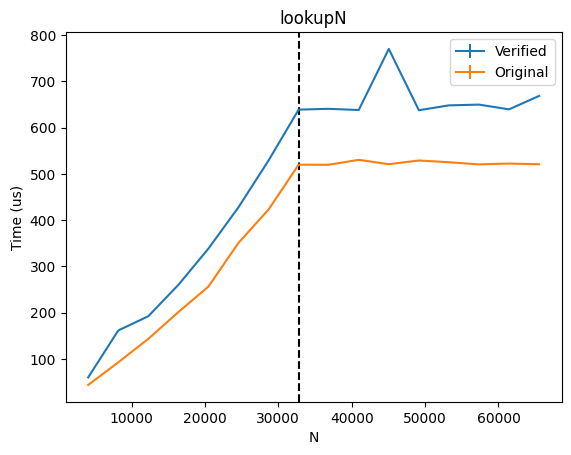

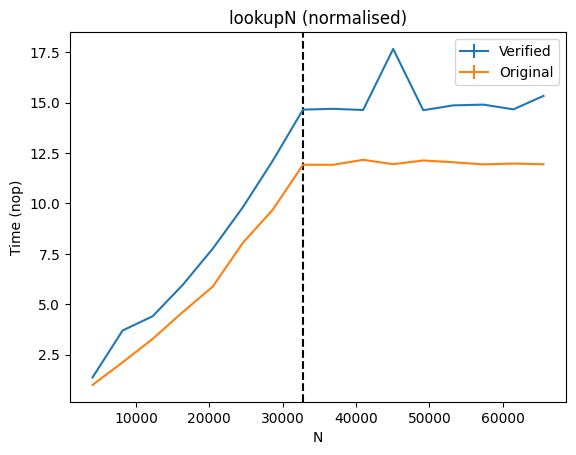

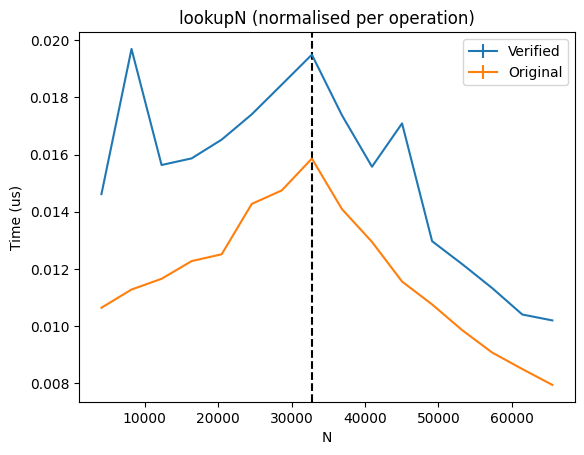

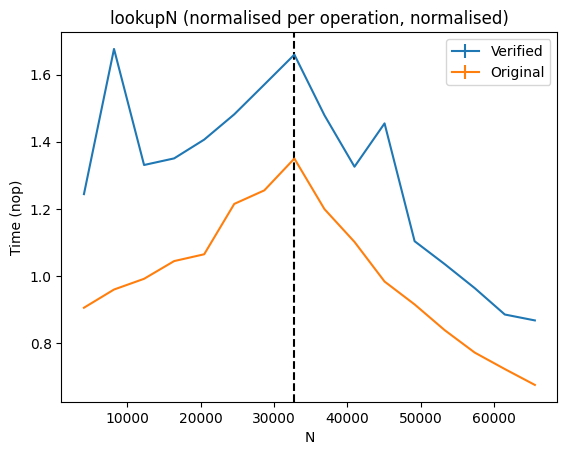

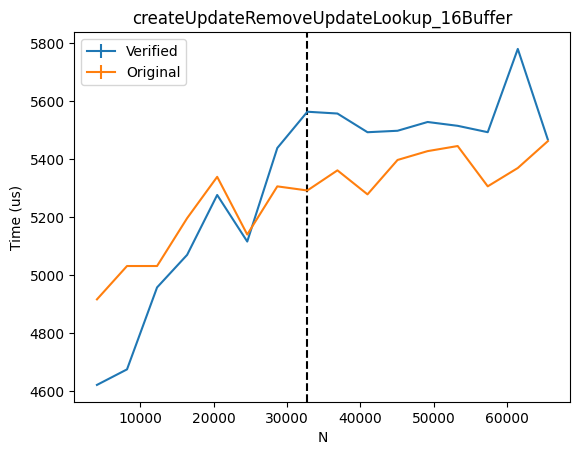

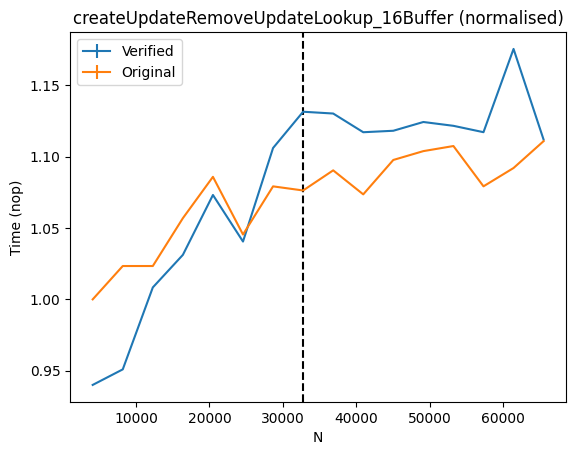

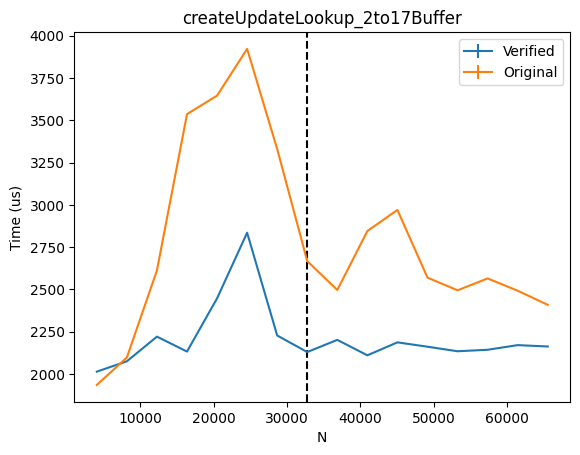

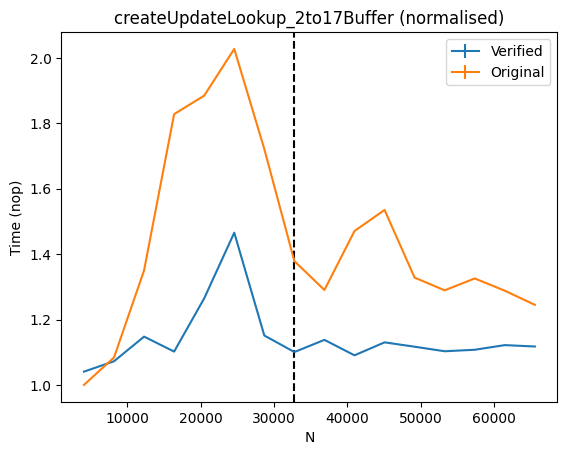

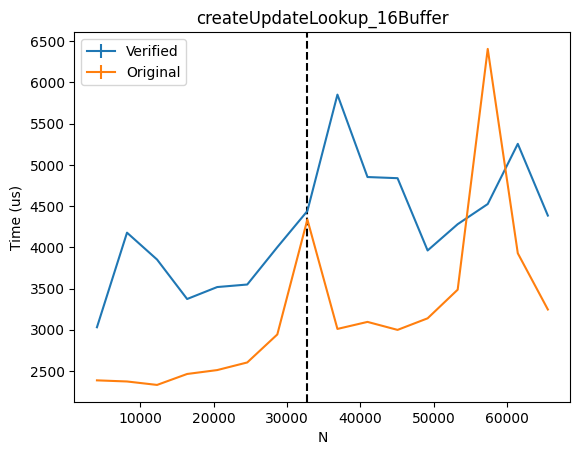

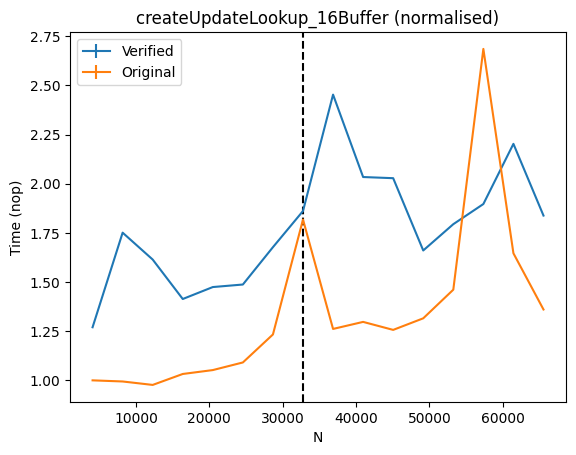

In [432]:
create_plots(benchmark_classes, benchmark_names, df)

# Big benchmark
with 2^22 values

In [433]:
data = """[info] Benchmark                                    (keysListName)  Mode  Cnt       Score   Error  Units
[info] MutableLongMapBenchmarkBig.lookupN_Opti              262144  avgt   1     28040.923  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti              786432  avgt   1     98895.032  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             1310720  avgt   1    123735.808  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             1835008  avgt   1    196303.091  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             2359296  avgt   1    265249.173  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             2883584  avgt   1    380871.776  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             3407872  avgt   1    481856.009  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             3932160  avgt   1    484298.425  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             4456448  avgt   1    539467.578  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             4980736  avgt   1    527530.769  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             5505024  avgt   1    579929.627  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             6029312  avgt   1    667009.389  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             6553600  avgt   1    589549.537  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             7077888  avgt   1    583147.883  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             7602176  avgt   1    575035.888  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             8126464  avgt   1    493237.584  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti             8388608  avgt   1    572203.502  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original          262144  avgt   1     22562.732  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original          786432  avgt   1     70081.367  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         1310720  avgt   1    127622.524  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         1835008  avgt   1    171372.335  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         2359296  avgt   1    245572.773  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         2883584  avgt   1    290983.915  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         3407872  avgt   1    353043.927  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         3932160  avgt   1    396511.920  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         4456448  avgt   1    373930.281  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         4980736  avgt   1    508209.739  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         5505024  avgt   1    480896.370  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         6029312  avgt   1    376915.477  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         6553600  avgt   1    517153.718  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         7077888  avgt   1    450363.024  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         7602176  avgt   1    440937.276  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         8126464  avgt   1    443872.116  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original         8388608  avgt   1    415811.764  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified          262144  avgt   1     37513.231  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified          786432  avgt   1    120628.703  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         1310720  avgt   1    211821.367  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         1835008  avgt   1    286492.766  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         2359296  avgt   1    398230.052  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         2883584  avgt   1    402625.779  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         3407872  avgt   1    527800.456  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         3932160  avgt   1    618262.868  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         4456448  avgt   1    685668.624  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         4980736  avgt   1    589561.211  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         5505024  avgt   1    732042.140  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         6029312  avgt   1    648285.327  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         6553600  avgt   1    775550.694  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         7077888  avgt   1    779646.543  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         7602176  avgt   1    755626.045  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         8126464  avgt   1    733684.554  ± 0.0001       us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified         8388608  avgt   1    627016.148  ± 0.0001       us/op""".strip().split("\n")

data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["MutableLongMapBenchmark", "MutableLongMapBenchmarkBig", "LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if f"{n}." in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "").replace("_Opti", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names



{'MutableLongMapBenchmark': [],
 'MutableLongMapBenchmarkBig': ['lookupN'],
 'LongListMapBenchmark': []}

In [434]:
df["Benchmark"].unique().tolist()

['MutableLongMapBenchmarkBig.lookupN_Opti',
 'MutableLongMapBenchmarkBig.lookupN_Original',
 'MutableLongMapBenchmarkBig.lookupN_Verified']

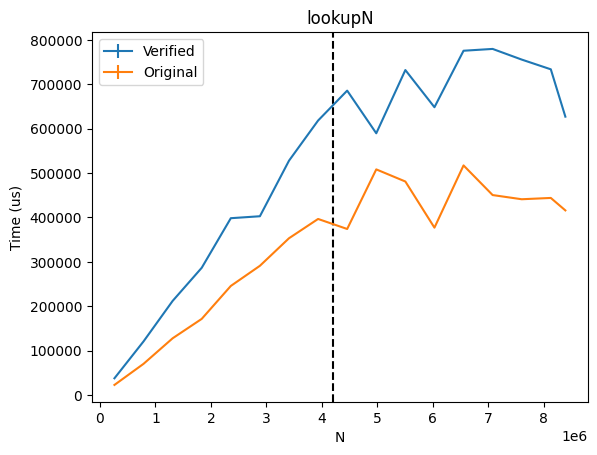

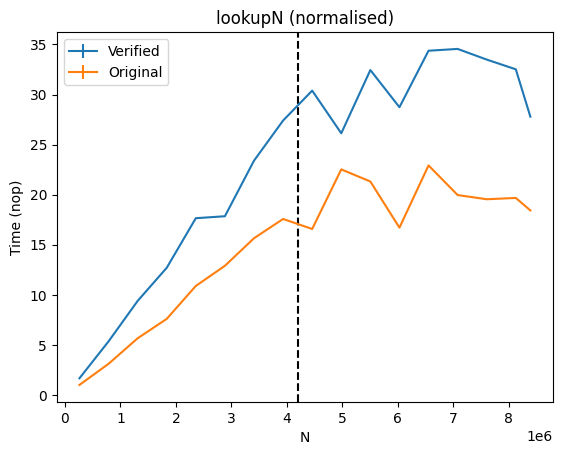

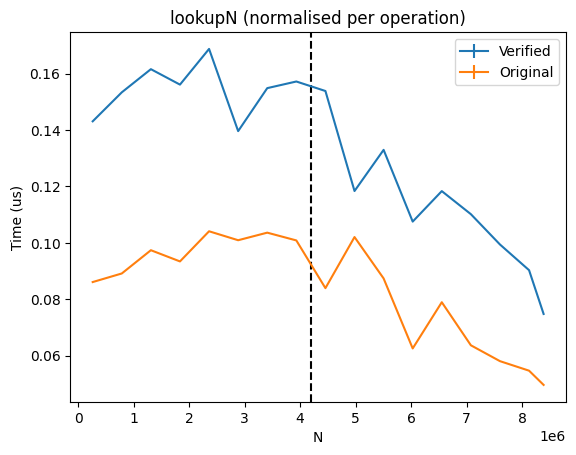

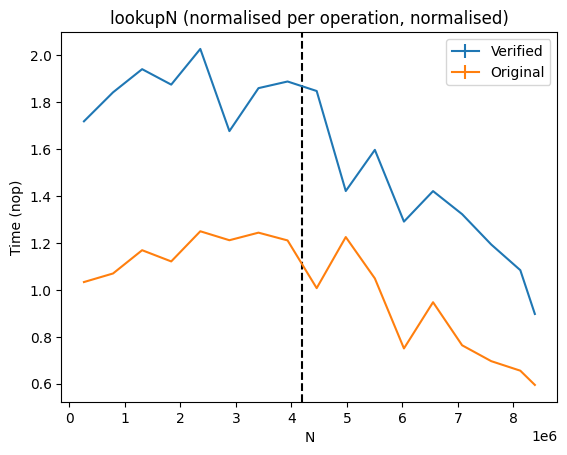

In [435]:
create_plots(benchmark_classes, benchmark_names, df)

# Benchmark 20.11.2023

In [436]:
data = """[info] Benchmark                                                                    (n)  (nKeys)  Mode  Cnt        Score         Error  Units
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                1      N/A  avgt   10        0.118 ±       0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                2      N/A  avgt   10        0.262 ±       0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                3      N/A  avgt   10        0.643 ±       0.009  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                4      N/A  avgt   10        1.761 ±       0.012  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                5      N/A  avgt   10        4.841 ±       0.057  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                6      N/A  avgt   10       18.641 ±       0.278  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                7      N/A  avgt   10       68.046 ±       0.399  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                8      N/A  avgt   10      305.897 ±       2.212  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                9      N/A  avgt   10     1320.518 ±       7.115  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               1      N/A  avgt   10        0.093 ±       0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               2      N/A  avgt   10        0.126 ±       0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               3      N/A  avgt   10        0.302 ±       0.005  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               4      N/A  avgt   10        0.665 ±       0.005  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               5      N/A  avgt   10        1.328 ±       0.006  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               6      N/A  avgt   10        2.915 ±       0.014  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               7      N/A  avgt   10        5.770 ±       0.035  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               8      N/A  avgt   10       11.852 ±       0.085  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                               9      N/A  avgt   10       25.488 ±       0.214  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               1      N/A  avgt   10        0.188 ±       0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               2      N/A  avgt   10        0.234 ±       0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               3      N/A  avgt   10        0.363 ±       0.003  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               4      N/A  avgt   10        0.908 ±       0.007  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               5      N/A  avgt   10        1.917 ±       0.009  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               6      N/A  avgt   10        3.944 ±       0.048  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               7      N/A  avgt   10        8.220 ±       0.499  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               8      N/A  avgt   10       15.930 ±       0.081  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                               9      N/A  avgt   10       33.759 ±       0.151  us/op
[info] LongListMapBenchmark.lookup_ListMap                                            3      N/A  avgt   10        0.105 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_ListMap                                            4      N/A  avgt   10        0.317 ±       0.017  us/op
[info] LongListMapBenchmark.lookup_ListMap                                            5      N/A  avgt   10        1.169 ±       0.006  us/op
[info] LongListMapBenchmark.lookup_ListMap                                            6      N/A  avgt   10        5.004 ±       0.007  us/op
[info] LongListMapBenchmark.lookup_ListMap                                            7      N/A  avgt   10       19.208 ±       0.022  us/op
[info] LongListMapBenchmark.lookup_ListMap                                            8      N/A  avgt   10       83.689 ±       0.338  us/op
[info] LongListMapBenchmark.lookup_ListMap                                            9      N/A  avgt   10      421.016 ±       1.176  us/op
[info] LongListMapBenchmark.lookup_Original                                           1      N/A  avgt   10        0.036 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                           2      N/A  avgt   10        0.051 ±       0.003  us/op
[info] LongListMapBenchmark.lookup_Original                                           3      N/A  avgt   10        0.053 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                           4      N/A  avgt   10        0.091 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                           5      N/A  avgt   10        0.168 ±       0.003  us/op
[info] LongListMapBenchmark.lookup_Original                                           6      N/A  avgt   10        0.312 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                           7      N/A  avgt   10        0.596 ±       0.004  us/op
[info] LongListMapBenchmark.lookup_Original                                           8      N/A  avgt   10        1.489 ±       0.025  us/op
[info] LongListMapBenchmark.lookup_Original                                           9      N/A  avgt   10        3.101 ±       0.019  us/op
[info] LongListMapBenchmark.lookup_Verified                                           1      N/A  avgt   10        0.038 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                           2      N/A  avgt   10        0.053 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                           3      N/A  avgt   10        0.064 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                           4      N/A  avgt   10        0.121 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                           5      N/A  avgt   10        0.235 ±       0.004  us/op
[info] LongListMapBenchmark.lookup_Verified                                           6      N/A  avgt   10        0.452 ±       0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                           7      N/A  avgt   10        0.893 ±       0.004  us/op
[info] LongListMapBenchmark.lookup_Verified                                           8      N/A  avgt   10        2.081 ±       0.038  us/op
[info] LongListMapBenchmark.lookup_Verified                                           9      N/A  avgt   10        4.363 ±       0.022  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A        0  avgt   10     2589.972 ±      32.510  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     1024  avgt   10     2624.569 ±      37.724  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     2048  avgt   10     2616.627 ±      18.072  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     3072  avgt   10     2645.041 ±      14.839  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     4096  avgt   10     2639.504 ±      31.295  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     5120  avgt   10     2690.120 ±      15.045  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     6144  avgt   10     2687.983 ±      14.473  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     7168  avgt   10     2702.986 ±      41.783  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     8192  avgt   10     2696.938 ±      18.443  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A     9216  avgt   10     2681.044 ±      10.441  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    10240  avgt   10     2715.336 ±      22.090  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    11264  avgt   10     2765.599 ±       7.057  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    12288  avgt   10     2736.770 ±      12.205  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    13312  avgt   10     2801.085 ±      21.526  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    14336  avgt   10     2803.864 ±      14.792  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    15360  avgt   10     2823.640 ±      19.036  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    16384  avgt   10     2811.682 ±      29.749  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    17408  avgt   10     2842.381 ±      10.046  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    18432  avgt   10     2885.846 ±      25.903  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    19456  avgt   10     2920.266 ±      15.884  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    20480  avgt   10     2891.703 ±      33.504  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    21504  avgt   10     2929.618 ±      25.607  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    22528  avgt   10     2977.827 ±      18.173  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    23552  avgt   10     2955.031 ±      14.992  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    24576  avgt   10     2965.810 ±      20.040  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    25600  avgt   10     3018.760 ±      28.246  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    26624  avgt   10     3000.487 ±      33.109  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    27648  avgt   10     3015.725 ±      24.040  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    28672  avgt   10     3054.892 ±      72.162  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    29696  avgt   10     3054.900 ±      12.473  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    30720  avgt   10     3056.951 ±       9.958  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    31744  avgt   10     3050.420 ±      16.193  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    32768  avgt   10     3133.390 ±      16.824  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    33792  avgt   10     3152.785 ±      14.653  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    34816  avgt   10     3178.200 ±     116.492  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    35840  avgt   10     3215.187 ±      13.116  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    36864  avgt   10     3206.302 ±      14.047  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    37888  avgt   10     3206.871 ±      19.694  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    38912  avgt   10     3228.228 ±      27.615  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    39936  avgt   10     3283.848 ±      25.201  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    40960  avgt   10     3254.247 ±      26.277  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    41984  avgt   10     3259.213 ±      25.594  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    43008  avgt   10     3280.038 ±      21.745  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    44032  avgt   10     3321.050 ±      46.602  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    45056  avgt   10     3330.790 ±      13.664  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    46080  avgt   10     3324.518 ±      10.183  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    47104  avgt   10     3319.924 ±      46.426  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    48128  avgt   10     3407.327 ±      56.290  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    49152  avgt   10     3377.516 ±      23.717  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    50176  avgt   10     3457.471 ±      65.340  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    51200  avgt   10     3452.613 ±      56.487  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    52224  avgt   10     3473.675 ±      13.435  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    53248  avgt   10     3460.680 ±      27.709  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    54272  avgt   10     3461.509 ±      16.321  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    55296  avgt   10     3495.179 ±      28.538  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    56320  avgt   10     3482.213 ±      29.418  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    57344  avgt   10     3549.426 ±      32.560  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    58368  avgt   10     3620.204 ±     198.116  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    59392  avgt   10     3602.349 ±      23.800  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    60416  avgt   10     3600.911 ±      21.023  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    61440  avgt   10     3588.937 ±      13.970  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    62464  avgt   10     3612.768 ±      26.424  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    63488  avgt   10     3638.667 ±      33.214  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    64512  avgt   10     3690.623 ±      18.069  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                     N/A    65536  avgt   10     3671.255 ±      28.075  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A        0  avgt   10     2262.048 ±      16.846  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     1024  avgt   10     2145.144 ±      10.728  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     2048  avgt   10     2210.612 ±      14.797  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     3072  avgt   10     2241.878 ±      11.878  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     4096  avgt   10     2254.132 ±     110.648  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     5120  avgt   10     2225.696 ±      31.861  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     6144  avgt   10     2315.452 ±      53.197  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     7168  avgt   10     2326.766 ±      23.034  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     8192  avgt   10     2234.268 ±      22.500  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A     9216  avgt   10     2375.095 ±      18.802  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    10240  avgt   10     2378.797 ±      19.288  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    11264  avgt   10     2402.025 ±      20.942  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    12288  avgt   10     2399.721 ±      34.294  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    13312  avgt   10     2370.294 ±      11.033  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    14336  avgt   10     2458.812 ±      12.494  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    15360  avgt   10     2462.276 ±      13.648  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    16384  avgt   10     2424.561 ±      23.194  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    17408  avgt   10     2403.608 ±      11.615  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    18432  avgt   10     2469.844 ±      25.908  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    19456  avgt   10     2500.819 ±      10.527  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    20480  avgt   10     2429.549 ±      18.240  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    21504  avgt   10     2551.563 ±      15.867  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    22528  avgt   10     2551.810 ±      21.112  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    23552  avgt   10     2475.029 ±      27.845  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    24576  avgt   10     2617.644 ±       9.880  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    25600  avgt   10     2541.576 ±      21.052  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    26624  avgt   10     2554.311 ±      13.971  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    27648  avgt   10     2630.787 ±      24.471  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    28672  avgt   10     2557.164 ±      22.768  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    29696  avgt   10     2646.014 ±      13.721  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    30720  avgt   10     2689.209 ±      23.060  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    31744  avgt   10     2692.300 ±      29.997  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    32768  avgt   10     2664.939 ±      19.051  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    33792  avgt   10     2717.532 ±      24.779  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    34816  avgt   10     2697.802 ±      24.374  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    35840  avgt   10     2762.884 ±      30.861  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    36864  avgt   10     2707.215 ±      36.165  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    37888  avgt   10     2751.726 ±      22.768  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    38912  avgt   10     2693.390 ±      27.604  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    39936  avgt   10     2773.391 ±      10.654  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    40960  avgt   10     2811.601 ±      31.556  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    41984  avgt   10     2806.507 ±      32.739  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    43008  avgt   10     2828.943 ±      25.327  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    44032  avgt   10     2860.594 ±      30.124  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    45056  avgt   10     2871.850 ±      21.238  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    46080  avgt   10     2904.245 ±      25.463  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    47104  avgt   10     2924.446 ±      25.231  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    48128  avgt   10     2911.134 ±      19.514  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    49152  avgt   10     2933.382 ±      38.764  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    50176  avgt   10     2864.021 ±      20.039  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    51200  avgt   10     3001.847 ±      19.448  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    52224  avgt   10     2882.885 ±      14.952  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    53248  avgt   10     3014.652 ±      33.040  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    54272  avgt   10     3008.161 ±      17.749  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    55296  avgt   10     3050.616 ±      11.621  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    56320  avgt   10     3013.834 ±      22.557  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    57344  avgt   10     3029.246 ±      13.611  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    58368  avgt   10     3057.851 ±      32.330  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    59392  avgt   10     3112.210 ±       9.337  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    60416  avgt   10     3104.764 ±       6.566  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    61440  avgt   10     3141.985 ±      17.992  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    62464  avgt   10     3078.046 ±      28.397  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    63488  avgt   10     3125.395 ±      24.198  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    64512  avgt   10     3166.858 ±      17.807  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                 N/A    65536  avgt   10     3196.189 ±      25.768  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A        0  avgt   10     3200.309 ±      45.567  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     1024  avgt   10     3217.622 ±      36.595  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     2048  avgt   10     3201.238 ±      28.960  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     3072  avgt   10     3246.947 ±      37.223  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     4096  avgt   10     3281.313 ±      26.966  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     5120  avgt   10     3253.340 ±      26.160  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     6144  avgt   10     3263.975 ±      18.087  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     7168  avgt   10     3311.692 ±      26.004  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     8192  avgt   10     3373.208 ±      28.545  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A     9216  avgt   10     3328.387 ±      16.598  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    10240  avgt   10     3373.442 ±      43.399  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    11264  avgt   10     3380.449 ±      16.736  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    12288  avgt   10     3402.309 ±      16.630  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    13312  avgt   10     3454.636 ±      50.726  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    14336  avgt   10     3476.444 ±      21.107  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    15360  avgt   10     3465.974 ±      20.315  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    16384  avgt   10     3567.419 ±      19.931  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    17408  avgt   10     3546.136 ±      29.316  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    18432  avgt   10     3547.441 ±      19.703  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    19456  avgt   10     3654.785 ±      70.112  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    20480  avgt   10     3600.851 ±      37.211  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    21504  avgt   10     3654.716 ±      27.491  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    22528  avgt   10     3660.029 ±      36.062  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    23552  avgt   10     3697.777 ±      43.707  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    24576  avgt   10     3706.702 ±      36.576  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    25600  avgt   10     3711.198 ±      38.654  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    26624  avgt   10     3756.025 ±      31.051  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    27648  avgt   10     3781.273 ±      18.823  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    28672  avgt   10     3779.601 ±      41.559  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    29696  avgt   10     3844.170 ±      32.576  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    30720  avgt   10     3845.170 ±      45.590  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    31744  avgt   10     3939.755 ±      10.331  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    32768  avgt   10     3937.747 ±      27.177  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    33792  avgt   10     3880.851 ±      33.751  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    34816  avgt   10     3963.033 ±      21.587  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    35840  avgt   10     3976.025 ±      16.423  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    36864  avgt   10     3978.760 ±      39.773  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    37888  avgt   10     4005.921 ±      44.454  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    38912  avgt   10     4005.880 ±      39.997  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    39936  avgt   10     4021.562 ±      31.917  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    40960  avgt   10     4038.550 ±      35.595  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    41984  avgt   10     4087.403 ±      23.651  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    43008  avgt   10     4118.041 ±      32.856  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    44032  avgt   10     4142.629 ±      45.745  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    45056  avgt   10     4153.819 ±      30.551  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    46080  avgt   10     4219.961 ±      40.523  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    47104  avgt   10     4249.830 ±      42.631  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    48128  avgt   10     4215.173 ±      40.429  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    49152  avgt   10     4256.350 ±      34.367  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    50176  avgt   10     4290.237 ±      13.237  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    51200  avgt   10     4386.049 ±      46.877  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    52224  avgt   10     4359.292 ±      36.889  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    53248  avgt   10     4346.531 ±      44.784  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    54272  avgt   10     4336.101 ±      38.726  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    55296  avgt   10     4348.839 ±      22.639  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    56320  avgt   10     4424.435 ±      36.582  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    57344  avgt   10     4429.533 ±      29.699  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    58368  avgt   10     4459.726 ±      36.543  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    59392  avgt   10     4521.386 ±      97.084  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    60416  avgt   10     4513.065 ±      29.751  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    61440  avgt   10     4509.865 ±      56.109  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    62464  avgt   10     4559.698 ±      30.989  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    63488  avgt   10     4633.599 ±      36.485  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    64512  avgt   10     4603.863 ±      27.645  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                 N/A    65536  avgt   10     4687.162 ±      55.571  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A        0  avgt   10     1477.373 ±      31.646  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     1024  avgt   10     1508.710 ±      10.675  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     2048  avgt   10     1558.176 ±      19.546  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     3072  avgt   10     1505.823 ±      13.311  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     4096  avgt   10     1555.292 ±       9.795  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     5120  avgt   10     1555.045 ±      24.983  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     6144  avgt   10     1563.923 ±      21.804  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     7168  avgt   10     1562.157 ±       9.115  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     8192  avgt   10     1592.617 ±      30.547  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A     9216  avgt   10     1638.845 ±      16.569  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    10240  avgt   10     1605.398 ±      12.342  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    11264  avgt   10     1667.282 ±      27.345  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    12288  avgt   10     1649.727 ±      11.747  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    13312  avgt   10     1631.481 ±      19.439  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    14336  avgt   10     1694.568 ±      16.767  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    15360  avgt   10     1699.154 ±      14.413  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    16384  avgt   10     1701.524 ±      10.839  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    17408  avgt   10     1754.220 ±      34.179  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    18432  avgt   10     1711.006 ±      20.831  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    19456  avgt   10     1727.592 ±      21.897  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    20480  avgt   10     1770.624 ±      10.666  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    21504  avgt   10     1756.487 ±      17.919  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    22528  avgt   10     1784.883 ±      23.375  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    23552  avgt   10     1869.041 ±     176.041  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    24576  avgt   10     1812.951 ±      18.720  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    25600  avgt   10     1864.667 ±      13.887  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    26624  avgt   10     1887.875 ±      18.838  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    27648  avgt   10     1894.310 ±      13.472  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    28672  avgt   10     1904.718 ±      16.412  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    29696  avgt   10     1883.247 ±      25.779  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    30720  avgt   10     1932.212 ±      27.571  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    31744  avgt   10     1933.204 ±      21.819  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    32768  avgt   10     1974.913 ±      29.979  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    33792  avgt   10     1977.832 ±      26.044  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    34816  avgt   10     2004.461 ±      10.782  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    35840  avgt   10     2008.301 ±      33.588  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    36864  avgt   10     2031.625 ±      15.146  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    37888  avgt   10     2060.638 ±      22.795  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    38912  avgt   10     2106.493 ±      38.831  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    39936  avgt   10     2073.669 ±       9.185  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    40960  avgt   10     2090.558 ±      21.910  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    41984  avgt   10     2075.011 ±      36.337  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    43008  avgt   10     2108.082 ±      27.363  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    44032  avgt   10     2072.248 ±      15.566  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    45056  avgt   10     2075.650 ±      21.032  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    46080  avgt   10     2208.207 ±      15.800  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    47104  avgt   10     2131.802 ±      10.217  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    48128  avgt   10     2144.145 ±      37.187  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    49152  avgt   10     2149.657 ±      23.011  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    50176  avgt   10     2199.914 ±      20.086  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    51200  avgt   10     2214.553 ±      31.745  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    52224  avgt   10     2324.233 ±      32.750  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    53248  avgt   10     2251.305 ±      16.536  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    54272  avgt   10     2229.323 ±      28.393  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    55296  avgt   10     2307.415 ±      19.863  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    56320  avgt   10     2293.005 ±      17.244  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    57344  avgt   10     2301.344 ±      19.636  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    58368  avgt   10     2332.707 ±      19.508  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    59392  avgt   10     2375.101 ±      11.168  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    60416  avgt   10     2339.844 ±      22.351  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    61440  avgt   10     2371.438 ±      25.609  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    62464  avgt   10     2358.430 ±      18.895  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    63488  avgt   10     2409.140 ±      19.931  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    64512  avgt   10     2440.429 ±      18.368  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                  N/A    65536  avgt   10     2399.050 ±      24.558  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A        0  avgt   10     1609.399 ±      16.950  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     1024  avgt   10     1578.212 ±       6.631  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     2048  avgt   10     1566.534 ±       6.659  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     3072  avgt   10     1521.299 ±      17.969  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     4096  avgt   10     1571.083 ±      11.203  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     5120  avgt   10     1649.987 ±      12.666  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     6144  avgt   10     1609.177 ±      13.605  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     7168  avgt   10     1676.747 ±      25.228  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     8192  avgt   10     1601.796 ±      14.843  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A     9216  avgt   10     1693.070 ±      11.513  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    10240  avgt   10     1668.846 ±      14.016  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    11264  avgt   10     1667.118 ±      13.774  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    12288  avgt   10     1696.444 ±      15.250  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    13312  avgt   10     1705.001 ±      23.152  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    14336  avgt   10     1648.775 ±      23.151  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    15360  avgt   10     1725.032 ±      25.171  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    16384  avgt   10     1708.008 ±      21.874  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    17408  avgt   10     1752.828 ±      42.383  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    18432  avgt   10     1726.044 ±      28.905  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    19456  avgt   10     1787.943 ±      25.556  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    20480  avgt   10     1800.495 ±      11.479  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    21504  avgt   10     1788.909 ±      15.953  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    22528  avgt   10     1818.043 ±       9.038  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    23552  avgt   10     1903.630 ±       8.297  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    24576  avgt   10     1838.156 ±      10.718  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    25600  avgt   10     1862.556 ±      15.071  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    26624  avgt   10     1793.551 ±      24.287  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    27648  avgt   10     1860.190 ±      16.006  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    28672  avgt   10     1932.351 ±      87.765  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    29696  avgt   10     1893.686 ±      29.043  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    30720  avgt   10     1942.392 ±      11.254  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    31744  avgt   10     1854.122 ±      11.851  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    32768  avgt   10     1926.289 ±      19.976  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    33792  avgt   10     1930.964 ±      17.143  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    34816  avgt   10     1991.906 ±       9.487  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    35840  avgt   10     2011.518 ±      15.430  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    36864  avgt   10     1995.572 ±      20.500  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    37888  avgt   10     2045.924 ±      61.237  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    38912  avgt   10     2005.246 ±      23.659  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    39936  avgt   10     2050.893 ±      23.204  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    40960  avgt   10     2064.778 ±      11.075  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    41984  avgt   10     2103.717 ±      11.058  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    43008  avgt   10     2108.381 ±      22.652  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    44032  avgt   10     2094.896 ±      15.924  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    45056  avgt   10     2078.783 ±      17.911  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    46080  avgt   10     2159.881 ±      15.800  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    47104  avgt   10     2179.045 ±      11.350  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    48128  avgt   10     2159.324 ±      16.299  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    49152  avgt   10     2080.825 ±      13.867  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    50176  avgt   10     2206.252 ±      73.760  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    51200  avgt   10     2134.810 ±      25.277  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    52224  avgt   10     2201.496 ±      45.906  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    53248  avgt   10     2198.922 ±      39.717  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    54272  avgt   10     2213.613 ±      12.074  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    55296  avgt   10     2248.680 ±      10.653  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    56320  avgt   10     2213.834 ±      29.712  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    57344  avgt   10     2256.306 ±      24.293  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    58368  avgt   10     2218.417 ±      29.280  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    59392  avgt   10     2305.565 ±      45.155  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    60416  avgt   10     2317.627 ±      17.663  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    61440  avgt   10     2297.950 ±      28.863  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    62464  avgt   10     2248.995 ±      30.034  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    63488  avgt   10     2365.589 ±      14.383  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    64512  avgt   10     2277.468 ±      17.279  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original              N/A    65536  avgt   10     2254.441 ±      25.684  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A        0  avgt   10     1925.580 ±      52.797  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     1024  avgt   10     1929.719 ±      14.298  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     2048  avgt   10     1951.332 ±      13.028  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     3072  avgt   10     1972.520 ±      21.866  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     4096  avgt   10     2001.368 ±      18.514  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     5120  avgt   10     1992.352 ±      23.724  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     6144  avgt   10     1997.243 ±      10.390  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     7168  avgt   10     2054.237 ±      22.742  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     8192  avgt   10     2075.112 ±      21.935  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A     9216  avgt   10     2062.556 ±      20.661  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    10240  avgt   10     2094.826 ±      13.939  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    11264  avgt   10     2129.298 ±      12.906  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    12288  avgt   10     2141.297 ±      28.354  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    13312  avgt   10     2163.620 ±      17.791  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    14336  avgt   10     2172.000 ±      15.891  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    15360  avgt   10     2192.583 ±      27.636  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    16384  avgt   10     2221.324 ±      26.601  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    17408  avgt   10     2216.927 ±      15.030  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    18432  avgt   10     2232.391 ±      17.188  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    19456  avgt   10     2281.349 ±      31.733  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    20480  avgt   10     2295.298 ±      33.388  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    21504  avgt   10     2294.823 ±       8.564  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    22528  avgt   10     2313.695 ±      22.287  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    23552  avgt   10     2349.170 ±      25.249  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    24576  avgt   10     2379.354 ±      10.382  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    25600  avgt   10     2377.330 ±      19.163  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    26624  avgt   10     2419.226 ±      25.674  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    27648  avgt   10     2462.962 ±      12.899  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    28672  avgt   10     2463.001 ±       9.625  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    29696  avgt   10     2488.725 ±      11.542  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    30720  avgt   10     2488.301 ±      27.647  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    31744  avgt   10     2524.675 ±      48.949  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    32768  avgt   10     2544.673 ±      36.318  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    33792  avgt   10     2556.604 ±      38.712  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    34816  avgt   10     2598.121 ±      21.326  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    35840  avgt   10     2618.758 ±      20.819  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    36864  avgt   10     2574.585 ±      12.685  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    37888  avgt   10     2645.577 ±      24.888  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    38912  avgt   10     2636.053 ±      37.759  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    39936  avgt   10     2673.377 ±      29.082  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    40960  avgt   10     2706.033 ±      30.870  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    41984  avgt   10     2721.889 ±      54.922  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    43008  avgt   10     2733.775 ±      25.956  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    44032  avgt   10     2736.369 ±      26.422  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    45056  avgt   10     2766.367 ±      32.386  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    46080  avgt   10     2803.727 ±      31.033  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    47104  avgt   10     2804.472 ±      24.106  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    48128  avgt   10     2857.153 ±      31.011  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    49152  avgt   10     2821.288 ±      19.858  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    50176  avgt   10     2893.470 ±      16.251  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    51200  avgt   10     2880.767 ±      32.335  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    52224  avgt   10     2918.283 ±      12.773  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    53248  avgt   10     2946.794 ±      31.858  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    54272  avgt   10     2970.055 ±      35.183  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    55296  avgt   10     2969.426 ±      26.306  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    56320  avgt   10     2977.405 ±      23.630  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    57344  avgt   10     3020.729 ±      18.808  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    58368  avgt   10     3025.343 ±      34.872  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    59392  avgt   10     3071.349 ±      30.217  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    60416  avgt   10     3077.781 ±     108.585  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    61440  avgt   10     3098.733 ±      24.559  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    62464  avgt   10     3111.843 ±      46.381  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    63488  avgt   10     3130.351 ±      38.408  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    64512  avgt   10     3171.151 ±      17.250  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified              N/A    65536  avgt   10     3138.530 ±      28.824  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A        0  avgt   10     4572.534 ±     100.238  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     1024  avgt   10     4489.806 ±      43.016  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     2048  avgt   10     4533.287 ±      23.134  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     3072  avgt   10     4554.473 ±      32.036  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     4096  avgt   10     4572.191 ±      24.908  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     5120  avgt   10     4568.217 ±      34.265  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     6144  avgt   10     4606.456 ±      40.304  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     7168  avgt   10     4652.112 ±      34.452  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     8192  avgt   10     4739.899 ±      23.657  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A     9216  avgt   10     4636.367 ±      20.369  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    10240  avgt   10     4747.142 ±      28.949  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    11264  avgt   10     4709.987 ±      41.736  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    12288  avgt   10     4844.785 ±      44.809  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    13312  avgt   10     4768.499 ±      28.017  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    14336  avgt   10     4805.051 ±      32.752  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    15360  avgt   10     4899.018 ±     116.512  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    16384  avgt   10     4848.357 ±      40.234  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    17408  avgt   10     4880.244 ±      35.523  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    18432  avgt   10     4913.753 ±      36.300  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    19456  avgt   10     4883.681 ±      33.629  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    20480  avgt   10     4969.839 ±      40.388  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    21504  avgt   10     5006.127 ±      41.633  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    22528  avgt   10     5021.365 ±      36.784  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    23552  avgt   10     5086.622 ±      58.626  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    24576  avgt   10     5111.561 ±      57.529  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    25600  avgt   10     5089.388 ±      65.475  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    26624  avgt   10     5086.485 ±      26.529  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    27648  avgt   10     5052.802 ±      42.463  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    28672  avgt   10     5053.270 ±      27.842  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    29696  avgt   10     5209.001 ±      35.928  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    30720  avgt   10     5148.552 ±      61.616  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    31744  avgt   10     5191.524 ±      34.327  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    32768  avgt   10     5190.579 ±      36.551  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    33792  avgt   10     5250.491 ±      45.892  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    34816  avgt   10     5284.053 ±      40.596  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    35840  avgt   10     5265.681 ±      58.303  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    36864  avgt   10     5252.240 ±      51.780  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    37888  avgt   10     5289.257 ±      40.427  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    38912  avgt   10     5419.881 ±     172.232  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    39936  avgt   10     5387.280 ±      32.385  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    40960  avgt   10     5417.569 ±      39.291  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    41984  avgt   10     5368.534 ±      42.720  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    43008  avgt   10     5416.706 ±      66.076  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    44032  avgt   10     5390.089 ±      39.832  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    45056  avgt   10     5468.857 ±      61.386  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    46080  avgt   10     5563.478 ±      45.350  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    47104  avgt   10     5441.237 ±      22.216  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    48128  avgt   10     5475.236 ±      32.284  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    49152  avgt   10     5558.628 ±     132.071  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    50176  avgt   10     5501.041 ±      36.729  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    51200  avgt   10     5628.547 ±      52.345  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    52224  avgt   10     5723.510 ±     102.165  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    53248  avgt   10     5635.603 ±      28.535  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    54272  avgt   10     5678.631 ±      56.204  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    55296  avgt   10     5693.652 ±     122.856  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    56320  avgt   10     5896.158 ±     301.877  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    57344  avgt   10     5730.290 ±     212.206  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    58368  avgt   10     5768.767 ±      94.984  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    59392  avgt   10     5645.811 ±      30.910  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    60416  avgt   10     5828.557 ±      48.927  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    61440  avgt   10     5883.507 ±     311.681  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    62464  avgt   10     5686.322 ±      26.693  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    63488  avgt   10     5788.766 ±      64.197  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    64512  avgt   10     5863.290 ±     111.849  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti         N/A    65536  avgt   10     5796.543 ±      45.853  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A        0  avgt   10     4590.703 ±      29.691  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     1024  avgt   10     4773.320 ±     192.793  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     2048  avgt   10     4608.411 ±      43.458  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     3072  avgt   10     4591.830 ±      91.103  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     4096  avgt   10     4534.460 ±      53.126  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     5120  avgt   10     4604.258 ±      55.262  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     6144  avgt   10     4671.981 ±      52.023  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     7168  avgt   10     4708.395 ±      35.042  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     8192  avgt   10     4843.401 ±      55.345  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A     9216  avgt   10     4695.506 ±      18.430  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    10240  avgt   10     4679.799 ±      47.187  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    11264  avgt   10     4671.011 ±      35.632  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    12288  avgt   10     4647.166 ±      39.081  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    13312  avgt   10     4798.948 ±      41.056  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    14336  avgt   10     4728.132 ±      35.805  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    15360  avgt   10     4726.066 ±      33.182  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    16384  avgt   10     4687.959 ±      35.521  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    17408  avgt   10     4745.088 ±      35.849  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    18432  avgt   10     4762.169 ±      40.512  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    19456  avgt   10     4767.014 ±      48.285  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    20480  avgt   10     4882.652 ±      26.906  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    21504  avgt   10     4834.116 ±      24.607  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    22528  avgt   10     4843.347 ±      76.859  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    23552  avgt   10     4745.036 ±      48.596  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    24576  avgt   10     4852.413 ±      36.475  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    25600  avgt   10     4964.716 ±     112.412  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    26624  avgt   10     4890.074 ±      41.349  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    27648  avgt   10     4917.699 ±      41.170  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    28672  avgt   10     5122.055 ±     130.351  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    29696  avgt   10     5013.087 ±      64.990  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    30720  avgt   10     4869.269 ±      25.141  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    31744  avgt   10     5039.889 ±      42.491  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    32768  avgt   10     4900.192 ±      40.504  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    33792  avgt   10     4912.726 ±      20.432  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    34816  avgt   10     4993.888 ±      40.402  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    35840  avgt   10     5024.443 ±      47.996  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    36864  avgt   10     4943.242 ±      64.283  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    37888  avgt   10     5043.367 ±      24.251  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    38912  avgt   10     5010.604 ±      47.235  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    39936  avgt   10     4886.131 ±      25.441  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    40960  avgt   10     5073.212 ±     110.382  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    41984  avgt   10     5110.698 ±      71.872  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    43008  avgt   10     5088.722 ±      37.512  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    44032  avgt   10     4988.728 ±      47.357  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    45056  avgt   10     5218.205 ±      76.071  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    46080  avgt   10     5103.109 ±      37.007  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    47104  avgt   10     5097.760 ±      60.059  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    48128  avgt   10     5063.336 ±      43.918  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    49152  avgt   10     5106.818 ±      43.522  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    50176  avgt   10     5094.551 ±      51.269  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    51200  avgt   10     5153.005 ±      24.455  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    52224  avgt   10     5299.091 ±      24.904  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    53248  avgt   10     5238.785 ±      25.378  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    54272  avgt   10     5126.621 ±      64.507  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    55296  avgt   10     5211.249 ±      70.182  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    56320  avgt   10     5245.112 ±      24.305  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    57344  avgt   10     5159.017 ±      41.737  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    58368  avgt   10     5231.048 ±      44.568  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    59392  avgt   10     5276.685 ±      53.044  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    60416  avgt   10     5198.819 ±      41.350  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    61440  avgt   10     5412.017 ±     124.968  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    62464  avgt   10     5415.774 ±      44.682  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    63488  avgt   10     5301.200 ±      69.185  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    64512  avgt   10     5491.727 ±      30.706  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original     N/A    65536  avgt   10     5372.949 ±      42.027  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A        0  avgt   10     5828.052 ±      78.931  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     1024  avgt   10     5944.944 ±      40.678  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     2048  avgt   10     6002.694 ±      51.839  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     3072  avgt   10     6019.589 ±      76.442  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     4096  avgt   10     6022.240 ±      38.350  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     5120  avgt   10     5987.987 ±      44.865  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     6144  avgt   10     6121.246 ±      73.148  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     7168  avgt   10     6074.793 ±      30.492  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     8192  avgt   10     6141.406 ±      34.282  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A     9216  avgt   10     6166.672 ±      68.512  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    10240  avgt   10     6202.796 ±      49.108  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    11264  avgt   10     6187.583 ±      47.150  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    12288  avgt   10     6248.393 ±      68.633  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    13312  avgt   10     6276.441 ±      53.862  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    14336  avgt   10     6364.275 ±      65.766  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    15360  avgt   10     6303.224 ±      56.355  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    16384  avgt   10     6326.829 ±      46.763  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    17408  avgt   10     6424.347 ±      47.089  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    18432  avgt   10     6404.556 ±      74.903  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    19456  avgt   10     6469.641 ±      61.068  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    20480  avgt   10     6458.547 ±      71.227  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    21504  avgt   10     6550.621 ±      36.936  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    22528  avgt   10     6585.282 ±      50.260  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    23552  avgt   10     6580.334 ±      65.968  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    24576  avgt   10     6618.513 ±      76.694  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    25600  avgt   10     6600.323 ±      66.495  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    26624  avgt   10     6625.881 ±      88.752  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    27648  avgt   10     6605.219 ±      63.618  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    28672  avgt   10     6695.081 ±      57.549  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    29696  avgt   10     6676.563 ±      66.945  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    30720  avgt   10     6723.934 ±      93.170  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    31744  avgt   10     6750.084 ±      36.001  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    32768  avgt   10     6714.666 ±      34.170  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    33792  avgt   10     6812.359 ±     105.838  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    34816  avgt   10     6815.306 ±      65.527  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    35840  avgt   10     6846.287 ±      76.131  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    36864  avgt   10     6947.888 ±      94.172  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    37888  avgt   10     6850.001 ±      66.809  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    38912  avgt   10     6989.320 ±      41.231  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    39936  avgt   10     6981.837 ±      68.698  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    40960  avgt   10     7054.406 ±      34.882  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    41984  avgt   10     7061.521 ±      48.848  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    43008  avgt   10     6943.925 ±      38.361  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    44032  avgt   10     7034.440 ±     110.614  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    45056  avgt   10     6987.480 ±      78.662  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    46080  avgt   10     7196.304 ±      60.427  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    47104  avgt   10     7138.080 ±      54.105  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    48128  avgt   10     7172.731 ±      28.683  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    49152  avgt   10     7121.058 ±      47.794  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    50176  avgt   10     7173.979 ±     134.906  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    51200  avgt   10     7289.117 ±      83.093  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    52224  avgt   10     7322.238 ±      60.781  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    53248  avgt   10     7269.611 ±      84.416  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    54272  avgt   10     7307.561 ±      61.207  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    55296  avgt   10     7332.377 ±      68.408  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    56320  avgt   10     7315.312 ±      80.387  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    57344  avgt   10     7389.915 ±      32.176  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    58368  avgt   10     7341.860 ±      83.613  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    59392  avgt   10     7469.523 ±     342.665  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    60416  avgt   10     7440.869 ±      36.041  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    61440  avgt   10     7435.067 ±      64.794  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    62464  avgt   10     7430.440 ±      48.612  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    63488  avgt   10     7577.858 ±      84.840  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    64512  avgt   10     7545.338 ±      92.496  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified     N/A    65536  avgt   10     7535.694 ±      75.789  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     1024  avgt   10       11.307 ±       0.169  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     2048  avgt   10       27.589 ±       0.059  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     3072  avgt   10       44.349 ±       0.510  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     4096  avgt   10       59.156 ±       1.118  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     5120  avgt   10      100.448 ±      26.317  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     6144  avgt   10       95.562 ±       1.044  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     7168  avgt   10      114.149 ±       1.212  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     8192  avgt   10      128.041 ±       0.165  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A     9216  avgt   10      147.793 ±       1.498  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    10240  avgt   10      165.520 ±       2.920  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    11264  avgt   10      179.902 ±       0.349  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    12288  avgt   10      197.869 ±       1.975  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    13312  avgt   10      217.729 ±       5.035  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    14336  avgt   10      233.693 ±       0.626  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    15360  avgt   10      247.734 ±       2.772  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    16384  avgt   10      271.749 ±      12.589  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    17408  avgt   10      284.999 ±       0.445  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    18432  avgt   10      303.483 ±       0.512  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    19456  avgt   10      326.012 ±       5.450  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    20480  avgt   10      336.324 ±       0.735  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    21504  avgt   10      349.323 ±       1.203  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    22528  avgt   10      369.072 ±       5.851  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    23552  avgt   10      382.710 ±       0.512  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    24576  avgt   10      404.872 ±       2.363  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    25600  avgt   10      426.032 ±       7.146  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    26624  avgt   10      444.404 ±       0.953  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    27648  avgt   10      451.841 ±       4.728  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    28672  avgt   10      476.763 ±       8.002  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    29696  avgt   10      495.157 ±       0.992  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    30720  avgt   10      514.656 ±       1.361  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    31744  avgt   10      533.617 ±       2.465  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    32768  avgt   10      532.755 ±       1.440  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    33792  avgt   10      562.824 ±      33.922  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    34816  avgt   10      568.505 ±       1.926  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    35840  avgt   10      593.093 ±       0.455  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    36864  avgt   10      617.861 ±       1.461  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    37888  avgt   10      631.282 ±       2.325  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    38912  avgt   10      650.315 ±       1.560  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    39936  avgt   10      662.416 ±       0.708  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    40960  avgt   10      680.169 ±      12.440  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    41984  avgt   10      692.891 ±       1.283  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    43008  avgt   10      718.193 ±       1.846  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    44032  avgt   10      734.354 ±      11.853  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    45056  avgt   10      745.534 ±       2.583  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    46080  avgt   10      761.576 ±       2.206  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    47104  avgt   10      795.458 ±      12.629  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    48128  avgt   10      804.931 ±       0.937  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    49152  avgt   10      814.006 ±       1.230  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    50176  avgt   10      825.624 ±      14.400  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    51200  avgt   10      855.822 ±       2.085  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    52224  avgt   10      869.882 ±       1.341  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    53248  avgt   10      874.592 ±      13.005  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    54272  avgt   10      885.379 ±       2.680  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    55296  avgt   10      913.706 ±       2.413  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    56320  avgt   10      947.922 ±      16.605  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    57344  avgt   10      961.707 ±       3.258  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    58368  avgt   10      961.996 ±       1.949  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    59392  avgt   10     1004.546 ±      20.156  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    60416  avgt   10      987.419 ±       3.319  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    61440  avgt   10     1016.796 ±       7.389  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    62464  avgt   10     1048.179 ±      17.521  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    63488  avgt   10     1061.219 ±       3.143  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    64512  avgt   10     1079.874 ±      15.058  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                         N/A    65536  avgt   10     1090.129 ±      20.701  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     1024  avgt   10        8.989 ±       0.027  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     2048  avgt   10       22.376 ±       0.292  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     3072  avgt   10       35.062 ±       0.050  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     4096  avgt   10       48.894 ±       0.064  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     5120  avgt   10       65.253 ±       0.306  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     6144  avgt   10       79.964 ±       0.145  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     7168  avgt   10       95.497 ±       0.173  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     8192  avgt   10       99.422 ±       0.592  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A     9216  avgt   10      116.348 ±       0.189  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    10240  avgt   10      132.161 ±       0.247  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    11264  avgt   10      148.178 ±       2.298  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    12288  avgt   10      165.776 ±       0.335  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    13312  avgt   10      180.408 ±       0.287  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    14336  avgt   10      198.789 ±       1.004  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    15360  avgt   10      213.883 ±       0.387  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    16384  avgt   10      227.460 ±       0.258  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    17408  avgt   10      248.481 ±       0.611  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    18432  avgt   10      258.151 ±       0.413  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    19456  avgt   10      276.213 ±       0.314  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    20480  avgt   10      291.794 ±       2.095  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    21504  avgt   10      305.335 ±       0.371  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    22528  avgt   10      321.512 ±       0.835  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    23552  avgt   10      341.417 ±       1.173  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    24576  avgt   10      358.127 ±       0.592  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    25600  avgt   10      375.737 ±       0.588  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    26624  avgt   10      392.317 ±       2.056  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    27648  avgt   10      403.998 ±       2.705  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    28672  avgt   10      422.833 ±       0.406  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    29696  avgt   10      428.800 ±       1.551  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    30720  avgt   10      448.343 ±       0.474  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    31744  avgt   10      467.156 ±       0.604  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    32768  avgt   10      476.559 ±       1.771  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    33792  avgt   10      499.029 ±       0.758  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    34816  avgt   10      515.865 ±       0.714  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    35840  avgt   10      526.020 ±       5.397  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    36864  avgt   10      538.533 ±       0.991  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    37888  avgt   10      554.308 ±       1.376  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    38912  avgt   10      574.047 ±       8.387  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    39936  avgt   10      583.833 ±       1.117  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    40960  avgt   10      599.822 ±       0.918  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    41984  avgt   10      631.835 ±       9.602  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    43008  avgt   10      631.426 ±       0.788  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    44032  avgt   10      644.125 ±       1.728  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    45056  avgt   10      666.881 ±      10.367  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    46080  avgt   10      687.319 ±       0.740  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    47104  avgt   10      700.733 ±       0.812  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    48128  avgt   10      727.552 ±      11.305  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    49152  avgt   10      737.554 ±      47.813  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    50176  avgt   10      736.723 ±       0.926  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    51200  avgt   10      775.881 ±      14.282  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    52224  avgt   10      768.334 ±       2.031  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    53248  avgt   10      795.808 ±       1.254  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    54272  avgt   10      812.779 ±      14.768  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    55296  avgt   10      827.610 ±       1.918  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    56320  avgt   10      824.271 ±       1.043  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    57344  avgt   10      857.459 ±      15.668  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    58368  avgt   10      860.699 ±       5.927  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    59392  avgt   10      879.658 ±       6.254  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    60416  avgt   10      903.016 ±      15.373  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    61440  avgt   10      896.546 ±       2.293  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    62464  avgt   10      932.178 ±       3.913  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    63488  avgt   10      946.591 ±      21.615  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    64512  avgt   10      964.966 ±       3.612  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                     N/A    65536  avgt   10      967.571 ±       0.958  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     1024  avgt   10       15.981 ±       0.039  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     2048  avgt   10       37.947 ±       0.137  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     3072  avgt   10       57.348 ±       0.928  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     4096  avgt   10       80.162 ±       0.124  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     5120  avgt   10      102.930 ±       0.185  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     6144  avgt   10      127.516 ±       2.501  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     7168  avgt   10      147.144 ±       0.983  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     8192  avgt   10      166.560 ±       0.323  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A     9216  avgt   10      192.814 ±       3.315  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    10240  avgt   10      214.922 ±       0.901  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    11264  avgt   10      232.241 ±       0.657  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    12288  avgt   10      256.705 ±       3.174  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    13312  avgt   10      281.031 ±       0.393  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    14336  avgt   10      303.438 ±       0.585  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    15360  avgt   10      319.868 ±       1.343  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    16384  avgt   10      341.780 ±       0.775  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    17408  avgt   10      365.377 ±       0.681  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    18432  avgt   10      392.438 ±       1.266  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    19456  avgt   10      408.094 ±       0.922  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    20480  avgt   10      437.706 ±       1.202  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    21504  avgt   10      461.973 ±       3.685  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    22528  avgt   10      481.958 ±       0.761  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    23552  avgt   10      494.648 ±       0.680  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    24576  avgt   10      521.460 ±       9.276  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    25600  avgt   10      539.383 ±       7.236  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    26624  avgt   10      562.084 ±       1.014  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    27648  avgt   10      598.542 ±      13.023  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    28672  avgt   10      614.129 ±       0.922  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    29696  avgt   10      638.281 ±       1.152  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    30720  avgt   10      654.411 ±      10.477  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    31744  avgt   10      680.433 ±       2.031  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    32768  avgt   10      688.601 ±       6.195  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    33792  avgt   10      711.342 ±      12.143  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    34816  avgt   10      741.840 ±       1.210  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    35840  avgt   10      765.641 ±       1.668  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    36864  avgt   10      793.802 ±      14.976  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    37888  avgt   10      804.358 ±       1.347  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    38912  avgt   10      827.113 ±       6.226  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    39936  avgt   10      858.208 ±      13.827  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    40960  avgt   10      955.833 ±     158.886  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    41984  avgt   10      894.545 ±       2.220  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    43008  avgt   10      927.641 ±      27.658  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    44032  avgt   10     1048.158 ±     167.419  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    45056  avgt   10      964.050 ±       5.052  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    46080  avgt   10      965.882 ±       6.313  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    47104  avgt   10     1000.674 ±       5.555  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    48128  avgt   10     1009.255 ±      15.281  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    49152  avgt   10     1060.671 ±      20.099  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    50176  avgt   10     1076.932 ±      14.099  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    51200  avgt   10     1101.487 ±      20.170  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    52224  avgt   10     1126.316 ±      21.715  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    53248  avgt   10     1138.944 ±      13.931  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    54272  avgt   10     1159.226 ±       6.781  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    55296  avgt   10     1198.148 ±      21.039  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    56320  avgt   10     1192.359 ±      18.441  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    57344  avgt   10     1215.539 ±       9.708  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    58368  avgt   10     1255.722 ±      18.454  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    59392  avgt   10     1272.615 ±       7.590  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    60416  avgt   10     1299.324 ±      14.433  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    61440  avgt   10     1323.126 ±      15.435  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    62464  avgt   10     1342.386 ±      19.240  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    63488  avgt   10     1362.469 ±      20.670  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    64512  avgt   10     1390.358 ±      20.582  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                     N/A    65536  avgt   10     1405.612 ±      21.169  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A        0  avgt   10  1410467.825 ±  180315.793  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A   131072  avgt   10  1381091.688 ±  200638.952  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A   262144  avgt   10  1487225.436 ±  144771.540  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A   393216  avgt   10  1513279.855 ±  292198.448  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A   524288  avgt   10  1409854.676 ±  123360.682  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A   655360  avgt   10  1346601.209 ±   85060.271  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A   786432  avgt   10  1587001.228 ±  132810.976  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A   917504  avgt   10  1575091.128 ±  333983.908  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1048576  avgt   10  1516236.506 ±  125054.383  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1179648  avgt   10  1442262.145 ±  125680.863  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1310720  avgt   10  1642011.672 ±  145605.305  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1441792  avgt   10  1528557.304 ±  164539.228  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1572864  avgt   10  1439000.709 ±   69540.913  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1703936  avgt   10  1720472.350 ±  203958.629  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1835008  avgt   10  1561602.693 ±  208448.773  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  1966080  avgt   10  1562159.741 ±  291885.491  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  2097152  avgt   10  1531011.494 ±  212612.032  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  2228224  avgt   10  1702899.760 ±  160343.409  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  2359296  avgt   10  1535697.191 ±  126359.011  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  2490368  avgt   10  1679458.877 ±  160267.462  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  2621440  avgt   10  1516359.759 ±  147981.233  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  2752512  avgt   10  1467000.021 ±   68822.609  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  2883584  avgt   10  1672107.914 ±  187511.689  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3014656  avgt   10  1779699.772 ±  127264.676  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3145728  avgt   10  1525153.689 ±  177453.758  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3276800  avgt   10  1784871.441 ±  200392.447  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3407872  avgt   10  1506229.870 ±   66829.272  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3538944  avgt   10  1491990.933 ±   48922.451  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3670016  avgt   10  1652060.073 ±  290480.113  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3801088  avgt   10  1904073.659 ±  197620.100  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  3932160  avgt   10  1631485.179 ±   83572.882  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4063232  avgt   10  1861905.995 ±  451046.585  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4194304  avgt   10  1761115.344 ±  185994.966  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4325376  avgt   10  2006843.283 ±  249863.489  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4456448  avgt   10  1719424.156 ±  171754.162  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4587520  avgt   10  2023990.805 ±  138126.904  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4718592  avgt   10  2025200.351 ±  200297.631  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4849664  avgt   10  1729539.764 ±  183276.804  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  4980736  avgt   10  1898004.471 ±  306898.820  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  5111808  avgt   10  2137820.036 ±  197452.643  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  5242880  avgt   10  2058542.281 ±  108111.918  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  5373952  avgt   10  1915206.740 ±  297298.436  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  5505024  avgt   10  1850428.910 ±  129549.937  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  5636096  avgt   10  1900486.671 ±  108904.209  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  5767168  avgt   10  1851608.995 ±  221575.126  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  5898240  avgt   10  1894521.185 ±  161186.364  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6029312  avgt   10  1902666.772 ±  420396.956  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6160384  avgt   10  1965172.326 ±  218220.578  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6291456  avgt   10  1966260.687 ±  518633.534  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6422528  avgt   10  2117565.641 ±   91040.106  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6553600  avgt   10  2092754.408 ±  214636.301  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6684672  avgt   10  2083321.539 ±  222307.816  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6815744  avgt   10  1924554.569 ±  173239.335  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  6946816  avgt   10  2183660.377 ±  165430.084  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7077888  avgt   10  2189293.511 ±  248133.592  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7208960  avgt   10  2098994.784 ±  349757.323  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7340032  avgt   10  1996780.524 ±  149306.961  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7471104  avgt   10  2179018.486 ±  304420.127  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7602176  avgt   10  2313130.440 ±  123645.470  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7733248  avgt   10  2375371.895 ±  134387.884  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7864320  avgt   10  2307197.870 ±  181306.090  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  7995392  avgt   10  2328151.590 ±  207242.740  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  8126464  avgt   10  2061331.905 ±  200058.116  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  8257536  avgt   10  2118821.667 ±  246545.298  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  N/A  8388608  avgt   10  2243618.531 ±  488192.254  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A        0  avgt   10  1561744.179 ±  107710.174  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A   131072  avgt   10  1319583.645 ±  277327.954  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A   262144  avgt   10  1376526.601 ±  142503.272  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A   393216  avgt   10  1546816.152 ±  203441.606  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A   524288  avgt   10  1461154.798 ±  122014.848  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A   655360  avgt   10  1493385.123 ±  173856.074  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A   786432  avgt   10  1397607.175 ±   99289.021  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A   917504  avgt   10  1445035.926 ±  189066.629  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1048576  avgt   10  1646036.850 ±  250865.946  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1179648  avgt   10  1509791.073 ±  256604.187  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1310720  avgt   10  1345120.438 ±   63057.822  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1441792  avgt   10  1504472.593 ±  344050.778  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1572864  avgt   10  1682797.184 ±   53825.715  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1703936  avgt   10  1421065.791 ±   56099.971  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1835008  avgt   10  1470794.694 ±  245247.236  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  1966080  avgt   10  1602788.182 ±  202657.469  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  2097152  avgt   10  1701870.066 ±  118259.453  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  2228224  avgt   10  1541467.286 ±  162870.924  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  2359296  avgt   10  1549635.596 ±  286461.388  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  2490368  avgt   10  1568550.545 ±  259768.884  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  2621440  avgt   10  1526750.147 ±  154256.463  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  2752512  avgt   10  1658811.255 ±   92017.217  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  2883584  avgt   10  1759997.735 ±  180847.407  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3014656  avgt   10  1702797.254 ±  105561.672  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3145728  avgt   10  1630023.081 ±  260310.412  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3276800  avgt   10  1655009.254 ±  212790.603  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3407872  avgt   10  1541123.575 ±   64592.094  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3538944  avgt   10  1626077.041 ±  262457.791  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3670016  avgt   10  1769001.186 ±  152889.622  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3801088  avgt   10  1719717.733 ±  132656.358  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  3932160  avgt   10  1878666.186 ±  122971.575  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4063232  avgt   10  1780482.628 ±  428758.994  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4194304  avgt   10  1982680.341 ±  164453.229  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4325376  avgt   10  1876259.143 ±  457123.103  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4456448  avgt   10  1808304.801 ±  411865.616  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4587520  avgt   10  1700163.100 ±   50890.093  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4718592  avgt   10  1744324.920 ±  195626.612  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4849664  avgt   10  1612775.603 ±  106525.406  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  4980736  avgt   10  1840708.154 ±  386425.484  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  5111808  avgt   10  1840439.467 ±  290963.859  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  5242880  avgt   10  1885926.398 ±  420298.517  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  5373952  avgt   10  1832458.595 ±  190675.672  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  5505024  avgt   10  1996931.658 ±  179633.431  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  5636096  avgt   10  1831022.851 ±  299846.467  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  5767168  avgt   10  1838769.370 ±  247706.707  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  5898240  avgt   10  1870321.511 ±  174448.989  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6029312  avgt   10  1831025.430 ±  113993.000  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6160384  avgt   10  1863084.686 ±  113956.151  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6291456  avgt   10  1759310.261 ±  150909.255  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6422528  avgt   10  1782278.332 ±   83422.989  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6553600  avgt   10  1994482.406 ±  316627.098  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6684672  avgt   10  1784485.430 ±   85799.679  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6815744  avgt   10  1901124.241 ±  120355.716  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  6946816  avgt   10  2102816.602 ±  193749.784  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7077888  avgt   10  1866312.170 ±   86392.181  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7208960  avgt   10  1799422.345 ±  124238.959  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7340032  avgt   10  1921016.241 ±   67117.159  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7471104  avgt   10  2071419.529 ±  595895.604  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7602176  avgt   10  1978567.200 ±  140309.660  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7733248  avgt   10  2056024.077 ±  164152.104  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7864320  avgt   10  2019222.355 ±   81944.026  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  7995392  avgt   10  2048386.842 ±  295694.004  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  8126464  avgt   10  2153588.765 ±  224194.743  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  8257536  avgt   10  2042207.725 ±  244284.928  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              N/A  8388608  avgt   10  1936655.616 ±  142804.053  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A        0  avgt   10  2277863.973 ±  120722.675  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A   131072  avgt   10  2253838.399 ±  176651.344  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A   262144  avgt   10  2160313.254 ±  108594.666  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A   393216  avgt   10  2395253.484 ±  190574.909  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A   524288  avgt   10  2289201.217 ±  238571.948  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A   655360  avgt   10  2244208.158 ±  215109.548  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A   786432  avgt   10  2350225.250 ±  158737.439  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A   917504  avgt   10  2215030.764 ±  143078.896  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1048576  avgt   10  2402860.456 ±  126498.378  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1179648  avgt   10  2401125.217 ±  197489.825  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1310720  avgt   10  2475408.089 ±  286042.740  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1441792  avgt   10  2463380.363 ±  200343.091  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1572864  avgt   10  2287660.122 ±  104339.846  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1703936  avgt   10  2267972.039 ±  299181.048  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1835008  avgt   10  2406159.714 ±  272710.029  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  1966080  avgt   10  2481285.314 ±  213290.876  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  2097152  avgt   10  2365919.882 ±  165547.128  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  2228224  avgt   10  2388932.062 ±  178583.646  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  2359296  avgt   10  2506587.999 ±  308594.639  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  2490368  avgt   10  2746137.550 ±  292142.644  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  2621440  avgt   10  2620143.494 ±  126713.711  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  2752512  avgt   10  2541799.171 ±  189192.950  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  2883584  avgt   10  2478182.250 ±  201115.579  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3014656  avgt   10  2639494.230 ±   93602.128  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3145728  avgt   10  2513127.305 ±  300352.390  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3276800  avgt   10  2580610.363 ±  138326.672  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3407872  avgt   10  2603910.636 ±  131237.886  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3538944  avgt   10  2763307.240 ±   79401.300  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3670016  avgt   10  2517273.602 ±  387503.661  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3801088  avgt   10  2674635.355 ±   75541.943  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  3932160  avgt   10  2786084.492 ±  293686.356  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4063232  avgt   10  2697613.714 ±  162629.164  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4194304  avgt   10  2555636.141 ±  122099.717  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4325376  avgt   10  2792183.233 ±  176953.843  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4456448  avgt   10  2940185.863 ±  141676.052  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4587520  avgt   10  2866818.951 ±  159629.249  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4718592  avgt   10  3057515.656 ±  562040.992  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4849664  avgt   10  2833629.601 ±  207746.842  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  4980736  avgt   10  2950922.908 ±  251316.321  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  5111808  avgt   10  2844364.013 ±  185649.961  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  5242880  avgt   10  2952308.182 ±  700070.925  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  5373952  avgt   10  3165450.630 ±  261390.800  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  5505024  avgt   10  2830731.144 ±   96001.775  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  5636096  avgt   10  3198435.846 ±  219215.215  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  5767168  avgt   10  2988151.284 ±  387492.636  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  5898240  avgt   10  3273930.294 ±  122060.068  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6029312  avgt   10  3277484.088 ±  166701.472  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6160384  avgt   10  3218439.404 ±  325534.928  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6291456  avgt   10  3159888.416 ±  221610.936  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6422528  avgt   10  3306829.319 ±  200500.560  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6553600  avgt   10  3052526.764 ±  365307.536  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6684672  avgt   10  3461931.063 ±  200796.292  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6815744  avgt   10  3222228.915 ±  121261.850  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  6946816  avgt   10  3414874.397 ±  318941.598  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7077888  avgt   10  3662597.320 ±  253688.727  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7208960  avgt   10  3141063.623 ±  237733.733  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7340032  avgt   10  3365099.053 ±  169314.752  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7471104  avgt   10  3509269.037 ±  107605.747  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7602176  avgt   10  3668290.903 ±  313929.538  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7733248  avgt   10  3487734.112 ±  594348.970  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7864320  avgt   10  3487595.025 ±  178700.887  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  7995392  avgt   10  3419682.589 ±  350722.446  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  8126464  avgt   10  3633177.162 ±  185268.318  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  8257536  avgt   10  3458545.340 ±  302413.282  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              N/A  8388608  avgt   10  3148545.500 ±  136458.508  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A        0  avgt   10  1353442.324 ±  182619.873  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A   131072  avgt   10  1284958.075 ±   80191.074  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A   262144  avgt   10  1371550.092 ±  204977.238  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A   393216  avgt   10  1373495.769 ±  150106.353  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A   524288  avgt   10  1252245.122 ±  130723.849  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A   655360  avgt   10  1396356.496 ±  237889.651  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A   786432  avgt   10  1402365.734 ±  174163.563  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A   917504  avgt   10  1387110.655 ±  128034.936  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1048576  avgt   10  1527083.804 ±  241157.366  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1179648  avgt   10  1419573.595 ±  220960.097  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1310720  avgt   10  1387068.250 ±  167173.275  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1441792  avgt   10  1375984.485 ±   99671.562  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1572864  avgt   10  1348909.104 ±   78687.174  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1703936  avgt   10  1486337.122 ±  150925.521  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1835008  avgt   10  1544226.746 ±  161940.886  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  1966080  avgt   10  1416587.454 ±  116310.612  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  2097152  avgt   10  1503407.348 ±  280268.491  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  2228224  avgt   10  1545671.173 ±  227050.628  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  2359296  avgt   10  1431118.245 ±   78038.565  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  2490368  avgt   10  1443291.524 ±  268667.142  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  2621440  avgt   10  1423188.466 ±  138443.704  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  2752512  avgt   10  1418906.154 ±  163295.102  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  2883584  avgt   10  1637350.348 ±  270345.745  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3014656  avgt   10  1381389.884 ±  128183.444  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3145728  avgt   10  1639582.990 ±  261075.873  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3276800  avgt   10  1476141.934 ±   71466.980  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3407872  avgt   10  1504379.028 ±  172438.137  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3538944  avgt   10  1415884.605 ±   57384.528  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3670016  avgt   10  1490510.285 ±  148715.765  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3801088  avgt   10  1407910.021 ±   89932.197  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  3932160  avgt   10  1534184.942 ±  111703.481  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4063232  avgt   10  1452657.249 ±  139620.760  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4194304  avgt   10  1780412.158 ±  302147.676  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4325376  avgt   10  1722257.691 ±  114652.912  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4456448  avgt   10  1664496.992 ±  327938.475  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4587520  avgt   10  1831007.968 ±   81886.235  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4718592  avgt   10  1758166.608 ±  265544.303  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4849664  avgt   10  1872409.891 ±  152099.085  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  4980736  avgt   10  1816617.992 ±  162739.568  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  5111808  avgt   10  1865883.084 ±  226007.060  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  5242880  avgt   10  1702412.045 ±  148577.688  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  5373952  avgt   10  1828584.143 ±  381571.177  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  5505024  avgt   10  1894055.727 ±  214201.794  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  5636096  avgt   10  1821790.823 ±  254488.868  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  5767168  avgt   10  2040415.002 ±  185864.972  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  5898240  avgt   10  1832188.106 ±  290090.883  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6029312  avgt   10  1859261.028 ±  178338.180  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6160384  avgt   10  1833926.618 ±  385494.867  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6291456  avgt   10  1796384.835 ±  182764.130  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6422528  avgt   10  1880901.109 ±  171587.645  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6553600  avgt   10  1946518.622 ±  188018.046  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6684672  avgt   10  1858459.551 ±  221109.308  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6815744  avgt   10  1892578.421 ±  354583.422  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  6946816  avgt   10  2085989.917 ±  230728.866  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7077888  avgt   10  1916914.992 ±  184392.505  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7208960  avgt   10  1859039.740 ±  320681.260  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7340032  avgt   10  2014974.497 ±  181984.786  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7471104  avgt   10  2031285.843 ±  168161.999  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7602176  avgt   10  1870977.204 ±  256251.628  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7733248  avgt   10  1967136.037 ±  431935.890  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7864320  avgt   10  2017013.522 ±  407372.217  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  7995392  avgt   10  2099036.045 ±  295377.355  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  8126464  avgt   10  1923485.298 ±  133983.402  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  8257536  avgt   10  2109351.843 ±  408515.101  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               N/A  8388608  avgt   10  1932694.566 ±  130609.231  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A        0  avgt   10  1352190.526 ±  212775.632  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A   131072  avgt   10  1398480.675 ±  199520.857  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A   262144  avgt   10  1464852.240 ±  112726.419  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A   393216  avgt   10  1369357.863 ±  210885.155  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A   524288  avgt   10  1477194.564 ±  109681.865  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A   655360  avgt   10  1521702.926 ±  135975.621  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A   786432  avgt   10  1478389.087 ±  156549.088  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A   917504  avgt   10  1287824.538 ±   63681.020  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1048576  avgt   10  1526587.178 ±  178721.417  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1179648  avgt   10  1492197.791 ±  261544.585  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1310720  avgt   10  1457831.651 ±  231305.870  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1441792  avgt   10  1376529.829 ±  161582.836  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1572864  avgt   10  1436643.015 ±  109918.619  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1703936  avgt   10  1469512.481 ±  189081.138  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1835008  avgt   10  1454940.833 ±  120198.798  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  1966080  avgt   10  1522299.656 ±  201665.114  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  2097152  avgt   10  1383858.837 ±   86769.829  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  2228224  avgt   10  1404144.612 ±   56050.153  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  2359296  avgt   10  1564528.684 ±  256878.110  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  2490368  avgt   10  1662647.920 ±  222847.111  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  2621440  avgt   10  1624894.513 ±  211273.098  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  2752512  avgt   10  1522271.475 ±  181942.780  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  2883584  avgt   10  1599938.744 ±  108727.608  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3014656  avgt   10  1441918.109 ±   49892.515  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3145728  avgt   10  1634473.950 ±  155912.914  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3276800  avgt   10  1528624.092 ±  158205.843  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3407872  avgt   10  1540030.830 ±  152092.859  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3538944  avgt   10  1714990.971 ±  203995.199  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3670016  avgt   10  1667729.462 ±  276589.816  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3801088  avgt   10  1705046.079 ±  128186.740  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  3932160  avgt   10  1640132.072 ±  159879.718  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4063232  avgt   10  1659684.800 ±  161744.240  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4194304  avgt   10  1653220.568 ±  149289.507  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4325376  avgt   10  1705420.281 ±  252441.819  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4456448  avgt   10  1550520.397 ±   56744.804  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4587520  avgt   10  1592146.345 ±   98896.027  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4718592  avgt   10  1625160.220 ±  120090.206  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4849664  avgt   10  1669432.752 ±   73292.787  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  4980736  avgt   10  1792966.122 ±  231227.637  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  5111808  avgt   10  1758345.873 ±  225921.061  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  5242880  avgt   10  1822502.697 ±  183867.189  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  5373952  avgt   10  1709226.694 ±  184431.795  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  5505024  avgt   10  1789273.853 ±  329794.692  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  5636096  avgt   10  1794141.707 ±  146708.437  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  5767168  avgt   10  1904133.593 ±   75352.283  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  5898240  avgt   10  1861589.047 ±  248155.612  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6029312  avgt   10  1809637.216 ±  134456.680  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6160384  avgt   10  1777135.757 ±  143248.759  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6291456  avgt   10  1735011.079 ±  120679.088  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6422528  avgt   10  1862265.170 ±  206228.138  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6553600  avgt   10  1724223.173 ±  112469.269  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6684672  avgt   10  1766909.784 ±   92143.728  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6815744  avgt   10  2013291.835 ±  164549.989  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  6946816  avgt   10  1765512.696 ±  175156.515  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7077888  avgt   10  1854505.394 ±  106092.151  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7208960  avgt   10  1960840.338 ±  109970.096  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7340032  avgt   10  1779027.920 ±   96008.435  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7471104  avgt   10  2053417.762 ±  107146.577  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7602176  avgt   10  2055950.122 ±  247425.556  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7733248  avgt   10  2017585.940 ±  126892.091  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7864320  avgt   10  2034393.649 ±  191944.570  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  7995392  avgt   10  2063772.315 ±  197212.048  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  8126464  avgt   10  1864688.468 ±  257964.331  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  8257536  avgt   10  2139573.779 ±  128401.655  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           N/A  8388608  avgt   10  2210618.476 ±  139252.660  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A        0  avgt   10  1542026.707 ±  125858.160  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A   131072  avgt   10  1538242.772 ±  166750.084  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A   262144  avgt   10  1602321.974 ±   79651.957  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A   393216  avgt   10  1508261.451 ±  139633.816  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A   524288  avgt   10  1636696.537 ±   85442.365  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A   655360  avgt   10  1688654.475 ±  137791.375  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A   786432  avgt   10  1668668.184 ±   77801.503  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A   917504  avgt   10  1672491.916 ±  182428.464  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1048576  avgt   10  1657960.537 ±  107745.544  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1179648  avgt   10  1696180.550 ±  149482.289  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1310720  avgt   10  1733746.883 ±  154032.269  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1441792  avgt   10  1771111.118 ±  104903.127  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1572864  avgt   10  1711897.697 ±  103059.607  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1703936  avgt   10  1782517.158 ±  224845.841  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1835008  avgt   10  1766372.191 ±  156348.472  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  1966080  avgt   10  1734920.011 ±  102823.000  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  2097152  avgt   10  1802294.251 ±   92154.244  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  2228224  avgt   10  1805742.265 ±  313836.217  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  2359296  avgt   10  1812220.795 ±  126274.779  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  2490368  avgt   10  1871296.079 ±  378059.994  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  2621440  avgt   10  1818938.360 ±   84883.324  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  2752512  avgt   10  1751444.495 ±  268598.074  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  2883584  avgt   10  1957689.277 ±  177582.852  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3014656  avgt   10  2009990.298 ±  120648.887  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3145728  avgt   10  1947395.238 ±  175171.113  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3276800  avgt   10  1948208.081 ±  185097.550  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3407872  avgt   10  1946287.910 ±  182887.993  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3538944  avgt   10  1976122.058 ±   75452.973  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3670016  avgt   10  2010592.690 ±  154969.534  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3801088  avgt   10  2010415.915 ±  108237.727  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  3932160  avgt   10  2063645.127 ±   72190.171  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4063232  avgt   10  1958233.558 ±  186333.110  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4194304  avgt   10  2173199.026 ±   90394.774  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4325376  avgt   10  2199665.450 ±  232348.378  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4456448  avgt   10  2159309.223 ±  123480.674  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4587520  avgt   10  2209087.252 ±  280012.227  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4718592  avgt   10  1988520.605 ±  325463.619  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4849664  avgt   10  2338987.653 ±  182883.615  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  4980736  avgt   10  2324991.397 ±  180204.385  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  5111808  avgt   10  2314908.266 ±  193811.327  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  5242880  avgt   10  2280438.794 ±  208432.098  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  5373952  avgt   10  2324356.965 ±  196777.002  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  5505024  avgt   10  2392141.078 ±  171022.583  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  5636096  avgt   10  2504013.731 ±  327448.624  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  5767168  avgt   10  2350272.816 ±  131268.867  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  5898240  avgt   10  2350612.185 ±  238473.405  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6029312  avgt   10  2514031.717 ±  380350.472  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6160384  avgt   10  2412720.323 ±  363552.345  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6291456  avgt   10  2168194.795 ±  209067.452  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6422528  avgt   10  2471524.219 ±  118799.451  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6553600  avgt   10  2536705.348 ±  336470.734  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6684672  avgt   10  2542774.149 ±  214579.678  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6815744  avgt   10  2499896.280 ±  226530.767  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  6946816  avgt   10  2635850.004 ±  206734.933  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7077888  avgt   10  2446598.347 ±  168274.466  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7208960  avgt   10  2607080.951 ±  174919.208  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7340032  avgt   10  2600872.725 ±  177645.481  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7471104  avgt   10  2709229.823 ±  102887.582  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7602176  avgt   10  2397997.811 ±  249404.044  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7733248  avgt   10  2693522.679 ±  174338.953  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7864320  avgt   10  2758947.411 ±  244513.197  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  7995392  avgt   10  2762892.769 ±  202315.649  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  8126464  avgt   10  2641134.740 ±  178769.567  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  8257536  avgt   10  2682338.135 ±  232542.785  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           N/A  8388608  avgt   10  2806569.077 ±  368640.004  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A        0  avgt   10  3312307.061 ±  365571.597  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A   131072  avgt   10  3401862.137 ±  522571.622  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A   262144  avgt   10  3026450.086 ±  323389.556  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A   393216  avgt   10  3322495.156 ±  346679.995  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A   524288  avgt   10  3403378.793 ±  238709.083  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A   655360  avgt   10  3553473.746 ±  208193.833  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A   786432  avgt   10  3672061.894 ±  268586.903  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A   917504  avgt   10  3454494.111 ±  480258.423  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1048576  avgt   10  3447732.962 ±  291800.351  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1179648  avgt   10  3071942.704 ±  471198.146  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1310720  avgt   10  3387041.661 ±  502835.117  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1441792  avgt   10  3149919.073 ±  630904.052  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1572864  avgt   10  3269195.888 ±  552409.580  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1703936  avgt   10  3613644.965 ±  205136.802  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1835008  avgt   10  3203018.606 ±  686773.472  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  1966080  avgt   10  3261602.323 ±  941311.233  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  2097152  avgt   10  3636542.655 ±  372562.107  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  2228224  avgt   10  3540862.361 ±  184680.036  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  2359296  avgt   10  3614154.868 ±  264631.986  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  2490368  avgt   10  3334447.776 ±  563640.383  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  2621440  avgt   10  3596682.096 ±  360261.183  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  2752512  avgt   10  3396599.498 ±  348812.675  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  2883584  avgt   10  3182565.606 ±   71176.815  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3014656  avgt   10  3787756.371 ±  364165.006  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3145728  avgt   10  3823223.948 ±  140773.630  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3276800  avgt   10  3700031.443 ±  703723.085  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3407872  avgt   10  3338515.486 ±  739418.172  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3538944  avgt   10  3492482.753 ±  663030.977  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3670016  avgt   10  3778253.390 ±  362100.186  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3801088  avgt   10  3212050.717 ±  548444.489  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  3932160  avgt   10  4072319.448 ±  387974.328  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4063232  avgt   10  3832053.453 ±  204180.365  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4194304  avgt   10  3742319.849 ±  476829.652  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4325376  avgt   10  3525893.557 ±  325597.428  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4456448  avgt   10  3951408.149 ±  401072.091  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4587520  avgt   10  3898272.014 ±  647711.313  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4718592  avgt   10  3750698.242 ±  601813.923  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4849664  avgt   10  3787881.590 ±  701154.667  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  4980736  avgt   10  4015609.150 ±  582336.726  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  5111808  avgt   10  3827694.184 ±  366588.884  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  5242880  avgt   10  4000340.977 ±  438433.534  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  5373952  avgt   10  3860817.110 ±  594171.555  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  5505024  avgt   10  3908602.166 ±  504531.870  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  5636096  avgt   10  3590476.167 ±  263913.353  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  5767168  avgt   10  3800040.349 ±  483652.047  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  5898240  avgt   10  4154495.885 ±  244121.770  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6029312  avgt   10  3989562.225 ±  697102.616  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6160384  avgt   10  4198141.636 ±  280928.037  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6291456  avgt   10  3882156.514 ±  319829.500  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6422528  avgt   10  4032078.068 ±  470309.757  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6553600  avgt   10  3856874.274 ±  420002.740  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6684672  avgt   10  4037749.913 ±  865769.259  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6815744  avgt   10  3691829.251 ±  473161.292  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  6946816  avgt   10  4207512.880 ±  292952.526  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7077888  avgt   10  4274852.535 ±  468806.369  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7208960  avgt   10  3483907.916 ±  149815.357  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7340032  avgt   10  3667488.356 ±  199491.962  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7471104  avgt   10  3893491.758 ±  243106.826  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7602176  avgt   10  4383017.897 ±  258097.660  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7733248  avgt   10  4314675.030 ±  341300.105  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7864320  avgt   10  4578306.281 ±  992567.131  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  7995392  avgt   10  4306670.622 ±  339586.701  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  8126464  avgt   10  4239200.615 ±  832093.491  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  8257536  avgt   10  4095017.511 ±  559651.052  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      N/A  8388608  avgt   10  4506487.526 ±  348736.720  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A        0  avgt   10  2967972.164 ±  662346.858  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A   131072  avgt   10  2821535.898 ±  286367.712  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A   262144  avgt   10  2900050.578 ±  424028.256  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A   393216  avgt   10  2916078.622 ±  194414.625  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A   524288  avgt   10  3038226.352 ±  385394.461  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A   655360  avgt   10  3282752.268 ±  479201.038  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A   786432  avgt   10  3352202.246 ±  419174.755  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A   917504  avgt   10  3173602.496 ±  617422.545  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1048576  avgt   10  3137431.737 ±  278269.152  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1179648  avgt   10  3300203.746 ±  419179.222  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1310720  avgt   10  2996653.524 ±  387799.223  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1441792  avgt   10  3085945.153 ±  370393.109  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1572864  avgt   10  3049116.757 ±  290900.288  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1703936  avgt   10  3254485.108 ±  676290.802  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1835008  avgt   10  3014252.323 ±  578248.366  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  1966080  avgt   10  3197283.600 ±  651237.145  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  2097152  avgt   10  3147899.716 ±  304541.605  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  2228224  avgt   10  3240814.444 ±  233285.933  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  2359296  avgt   10  3112843.612 ±  616435.689  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  2490368  avgt   10  3269214.303 ±  631036.907  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  2621440  avgt   10  3032388.455 ±  385786.735  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  2752512  avgt   10  3090626.359 ±  494077.230  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  2883584  avgt   10  3215003.008 ±  532698.979  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3014656  avgt   10  3186479.543 ±  608065.650  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3145728  avgt   10  3085498.151 ±  597950.013  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3276800  avgt   10  2983850.251 ±  214553.312  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3407872  avgt   10  3278671.669 ±  248579.036  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3538944  avgt   10  3056068.383 ±  615983.442  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3670016  avgt   10  3472331.506 ±  593013.873  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3801088  avgt   10  2845198.878 ±  171779.518  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  3932160  avgt   10  3188724.492 ±  429398.223  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4063232  avgt   10  3117180.568 ±  464828.545  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4194304  avgt   10  3212350.537 ±  373590.215  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4325376  avgt   10  3279980.071 ±  161339.719  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4456448  avgt   10  3156202.024 ±  594448.540  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4587520  avgt   10  3348214.549 ±  548566.219  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4718592  avgt   10  3546492.772 ±  403317.763  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4849664  avgt   10  3429357.877 ±  660325.121  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  4980736  avgt   10  3310954.057 ±  529479.604  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  5111808  avgt   10  3350034.002 ±  434332.299  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  5242880  avgt   10  3711660.326 ±  811280.288  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  5373952  avgt   10  3604310.131 ±  467781.884  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  5505024  avgt   10  3529482.850 ±  200584.085  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  5636096  avgt   10  3715009.271 ±  351867.030  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  5767168  avgt   10  3189497.131 ±  660919.167  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  5898240  avgt   10  3636508.013 ±  515479.095  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6029312  avgt   10  3275108.798 ±  369009.225  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6160384  avgt   10  3639653.370 ±  316009.641  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6291456  avgt   10  3599140.204 ±  470168.053  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6422528  avgt   10  3187540.353 ±  472194.787  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6553600  avgt   10  3461921.640 ±  380287.701  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6684672  avgt   10  3586898.814 ±  283837.081  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6815744  avgt   10  3679231.911 ±  641196.460  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  6946816  avgt   10  3551315.175 ±  434986.292  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7077888  avgt   10  3531207.681 ±  252122.829  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7208960  avgt   10  3692504.511 ±  273048.757  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7340032  avgt   10  3289707.414 ±  817478.193  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7471104  avgt   10  3739217.693 ±  348253.817  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7602176  avgt   10  3672269.255 ±  253186.317  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7733248  avgt   10  3590759.616 ±  434010.912  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7864320  avgt   10  3712929.929 ±  254024.722  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  7995392  avgt   10  3414741.500 ±  628432.356  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  8126464  avgt   10  3617701.627 ±  589298.240  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  8257536  avgt   10  3653276.456 ±  316862.419  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  N/A  8388608  avgt   10  3570782.153 ±  448958.329  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A        0  avgt   10  4544749.624 ±  535379.744  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A   131072  avgt   10  4426057.177 ±  212133.240  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A   262144  avgt   10  4401101.572 ±  315796.293  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A   393216  avgt   10  4553024.698 ±  330518.787  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A   524288  avgt   10  4173861.147 ±  205578.889  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A   655360  avgt   10  4432402.953 ±  420716.483  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A   786432  avgt   10  4718689.359 ±  411874.685  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A   917504  avgt   10  4444117.564 ±  564226.312  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1048576  avgt   10  4624685.012 ±  429455.188  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1179648  avgt   10  4579129.675 ±  269677.890  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1310720  avgt   10  4532953.680 ±  342634.304  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1441792  avgt   10  4471187.065 ±  318410.357  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1572864  avgt   10  5060274.009 ±  222285.023  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1703936  avgt   10  4618043.689 ±  448917.606  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1835008  avgt   10  4230029.231 ±  206778.431  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  1966080  avgt   10  5010480.829 ±  313776.602  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  2097152  avgt   10  4964839.855 ±  401637.288  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  2228224  avgt   10  4862128.373 ±  360670.487  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  2359296  avgt   10  4960456.044 ±  376107.563  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  2490368  avgt   10  4969714.432 ±  466349.688  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  2621440  avgt   10  4940580.685 ±  349866.737  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  2752512  avgt   10  4922547.526 ±  311555.670  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  2883584  avgt   10  4629178.530 ±  665438.965  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3014656  avgt   10  4979767.066 ±  529666.295  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3145728  avgt   10  5193427.117 ±  402240.607  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3276800  avgt   10  4994981.845 ±  337940.018  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3407872  avgt   10  4983313.121 ±  298466.951  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3538944  avgt   10  4814248.161 ±  483915.859  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3670016  avgt   10  5287606.519 ±  353752.876  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3801088  avgt   10  4549422.404 ±  334302.960  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  3932160  avgt   10  5022326.606 ±  237674.291  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4063232  avgt   10  5235301.232 ±  328766.412  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4194304  avgt   10  4452044.746 ±  668007.863  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4325376  avgt   10  5156808.211 ±  628378.531  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4456448  avgt   10  5119218.725 ±  663895.111  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4587520  avgt   10  5089412.010 ±  316777.821  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4718592  avgt   10  5509994.893 ±  398900.279  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4849664  avgt   10  4971002.721 ±  219194.140  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  4980736  avgt   10  5322876.070 ±  328496.781  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  5111808  avgt   10  5523627.791 ±  388328.831  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  5242880  avgt   10  5394105.113 ±  411860.158  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  5373952  avgt   10  5477272.478 ±  330752.493  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  5505024  avgt   10  5611055.623 ±  416534.929  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  5636096  avgt   10  5493042.582 ±  270432.515  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  5767168  avgt   10  5287038.675 ±  579154.550  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  5898240  avgt   10  5486562.416 ±  246606.305  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6029312  avgt   10  5535566.713 ±  423415.702  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6160384  avgt   10  5757925.227 ±  188734.175  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6291456  avgt   10  5321089.155 ±  325387.329  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6422528  avgt   10  5148613.013 ±  399471.544  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6553600  avgt   10  5249148.610 ±  332542.615  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6684672  avgt   10  5259543.725 ±  249721.115  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6815744  avgt   10  5494173.202 ±  419963.850  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  6946816  avgt   10  5506466.910 ±  536717.922  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7077888  avgt   10  5658603.241 ±  779530.838  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7208960  avgt   10  5756203.234 ±  228570.283  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7340032  avgt   10  5595067.174 ±  304659.788  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7471104  avgt   10  5327131.141 ±  269550.611  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7602176  avgt   10  5926430.199 ±  850019.659  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7733248  avgt   10  5131822.246 ±  873941.602  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7864320  avgt   10  5871035.573 ±  395182.328  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  7995392  avgt   10  5877238.499 ±  445250.010  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  8126464  avgt   10  6167480.343 ± 1039585.761  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  8257536  avgt   10  5353012.969 ±  577262.981  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  N/A  8388608  avgt   10  5801154.202 ± 1119586.553  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A   131072  avgt   10     8044.612 ±      61.656  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A   262144  avgt   10    16626.277 ±     238.140  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A   393216  avgt   10    25192.486 ±     341.429  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A   524288  avgt   10    37214.543 ±     457.508  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A   655360  avgt   10    42919.860 ±     599.220  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A   786432  avgt   10    51646.690 ±     558.875  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A   917504  avgt   10    62405.430 ±    1104.025  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1048576  avgt   10    71699.720 ±    1229.232  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1179648  avgt   10    85104.107 ±     963.429  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1310720  avgt   10    85672.484 ±    1466.188  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1441792  avgt   10    98836.378 ±     845.161  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1572864  avgt   10   103510.768 ±    1965.020  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1703936  avgt   10   109907.390 ±    1141.177  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1835008  avgt   10   116746.636 ±    1068.895  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  1966080  avgt   10   125565.236 ±    1705.221  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  2097152  avgt   10   133863.880 ±    1350.935  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  2228224  avgt   10   155359.344 ±    3197.264  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  2359296  avgt   10   160940.529 ±    1977.613  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  2490368  avgt   10   164051.830 ±    2264.622  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  2621440  avgt   10   169888.984 ±    2154.500  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  2752512  avgt   10   189130.120 ±    3938.547  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  2883584  avgt   10   184033.063 ±    2664.137  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3014656  avgt   10   197591.435 ±    1063.526  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3145728  avgt   10   204874.986 ±    3783.600  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3276800  avgt   10   214023.461 ±    2056.144  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3407872  avgt   10   226503.790 ±    3062.852  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3538944  avgt   10   239907.007 ±    3051.270  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3670016  avgt   10   250544.725 ±    2109.841  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3801088  avgt   10   262596.946 ±    3657.922  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  3932160  avgt   10   271555.931 ±    3775.609  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4063232  avgt   10   263866.279 ±    2117.153  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4194304  avgt   10   414935.122 ±  106784.416  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4325376  avgt   10   348351.464 ±    4253.388  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4456448  avgt   10   374092.999 ±    3933.256  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4587520  avgt   10   342081.683 ±    3575.314  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4718592  avgt   10   357754.161 ±    6475.508  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4849664  avgt   10   365875.379 ±    4909.267  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  4980736  avgt   10   380127.417 ±    7920.523  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  5111808  avgt   10   412800.493 ±    5976.232  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  5242880  avgt   10   439364.370 ±    8768.071  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  5373952  avgt   10   428618.413 ±    4185.885  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  5505024  avgt   10   430300.842 ±    8309.545  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  5636096  avgt   10   428458.119 ±    7556.601  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  5767168  avgt   10   440270.899 ±   10090.781  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  5898240  avgt   10   439417.354 ±    4500.546  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6029312  avgt   10   443002.282 ±    9976.825  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6160384  avgt   10   487288.277 ±    4518.690  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6291456  avgt   10   472001.843 ±    6527.709  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6422528  avgt   10   488776.041 ±    7887.959  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6553600  avgt   10   528522.277 ±    5825.989  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6684672  avgt   10   502804.933 ±    5339.870  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6815744  avgt   10   542735.292 ±    5428.490  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  6946816  avgt   10   510621.816 ±    2743.215  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7077888  avgt   10   551028.756 ±    9106.606  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7208960  avgt   10   564303.917 ±    5884.673  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7340032  avgt   10   546739.489 ±    8778.368  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7471104  avgt   10   603584.356 ±    8852.816  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7602176  avgt   10   568618.323 ±    2040.963  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7733248  avgt   10   603666.268 ±    9198.059  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7864320  avgt   10   638463.686 ±   12284.182  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  7995392  avgt   10   588453.638 ±    7303.501  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  8126464  avgt   10   636901.202 ±   13515.327  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  8257536  avgt   10   701393.249 ±   11627.959  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      N/A  8388608  avgt   10   628364.022 ±    6699.783  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A   131072  avgt   10     7842.789 ±     336.852  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A   262144  avgt   10    16229.234 ±      34.090  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A   393216  avgt   10    24449.877 ±      76.931  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A   524288  avgt   10    34203.460 ±     103.440  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A   655360  avgt   10    41312.835 ±     128.619  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A   786432  avgt   10    48405.273 ±     357.752  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A   917504  avgt   10    55462.798 ±     501.783  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1048576  avgt   10    63255.663 ±     190.086  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1179648  avgt   10    72722.118 ±     274.802  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1310720  avgt   10    79634.994 ±     300.258  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1441792  avgt   10    87272.328 ±     114.401  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1572864  avgt   10   104792.362 ±     183.180  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1703936  avgt   10   111660.745 ±     550.457  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1835008  avgt   10   117760.643 ±     302.570  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  1966080  avgt   10   122658.516 ±     303.038  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  2097152  avgt   10   129604.929 ±     586.509  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  2228224  avgt   10   146264.327 ±     296.331  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  2359296  avgt   10   144959.960 ±     307.057  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  2490368  avgt   10   150309.712 ±     316.492  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  2621440  avgt   10   159316.023 ±    1890.337  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  2752512  avgt   10   168716.648 ±     276.376  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  2883584  avgt   10   179735.445 ±    2039.004  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3014656  avgt   10   191526.908 ±     634.568  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3145728  avgt   10   192911.412 ±     463.359  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3276800  avgt   10   201410.959 ±    2791.123  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3407872  avgt   10   212036.166 ±     427.207  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3538944  avgt   10   228548.040 ±     781.182  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3670016  avgt   10   222886.306 ±    3086.471  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3801088  avgt   10   235119.640 ±    1257.495  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  3932160  avgt   10   265691.409 ±     668.092  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4063232  avgt   10   245747.682 ±    3253.871  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4194304  avgt   10   306498.448 ±    3262.838  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4325376  avgt   10   297408.867 ±     920.047  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4456448  avgt   10   296483.438 ±    2156.384  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4587520  avgt   10   345086.071 ±     861.740  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4718592  avgt   10   334458.629 ±     697.596  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4849664  avgt   10   325796.050 ±    1269.713  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  4980736  avgt   10   334966.893 ±    1052.940  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  5111808  avgt   10   382826.014 ±    1076.222  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  5242880  avgt   10   347888.145 ±    1234.639  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  5373952  avgt   10   377839.965 ±    1526.679  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  5505024  avgt   10   406557.289 ±    1074.368  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  5636096  avgt   10   425765.688 ±    1217.486  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  5767168  avgt   10   381469.368 ±    3706.951  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  5898240  avgt   10   396293.798 ±    1373.493  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6029312  avgt   10   404569.576 ±     907.320  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6160384  avgt   10   411501.395 ±    1375.951  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6291456  avgt   10   425239.453 ±    1083.501  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6422528  avgt   10   426021.227 ±    1046.471  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6553600  avgt   10   439982.106 ±    2313.023  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6684672  avgt   10   441737.279 ±    1028.826  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6815744  avgt   10   457208.777 ±    1381.889  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  6946816  avgt   10   512504.451 ±    1878.547  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7077888  avgt   10   463452.647 ±    1431.075  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7208960  avgt   10   477234.379 ±    1677.397  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7340032  avgt   10   526557.710 ±    2137.158  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7471104  avgt   10   543972.768 ±    1546.117  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7602176  avgt   10   495481.665 ±    2073.967  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7733248  avgt   10   512404.915 ±    1667.966  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7864320  avgt   10   518262.615 ±    2544.795  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  7995392  avgt   10   534726.948 ±    1989.866  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  8126464  avgt   10   546031.937 ±    1914.401  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  8257536  avgt   10   546098.686 ±    2497.494  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  N/A  8388608  avgt   10   548282.080 ±    1312.604  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A   131072  avgt   10    11314.653 ±     109.134  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A   262144  avgt   10    23711.387 ±     145.195  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A   393216  avgt   10    33847.552 ±     140.468  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A   524288  avgt   10    46121.218 ±     624.083  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A   655360  avgt   10    57785.103 ±     351.170  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A   786432  avgt   10    71061.254 ±     269.663  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A   917504  avgt   10    90782.028 ±   10062.563  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1048576  avgt   10    89520.172 ±     316.756  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1179648  avgt   10   106608.407 ±     301.713  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1310720  avgt   10   116568.355 ±     669.682  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1441792  avgt   10   128433.936 ±     351.819  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1572864  avgt   10   137790.975 ±     406.129  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1703936  avgt   10   147838.023 ±     889.358  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1835008  avgt   10   183869.776 ±     771.015  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  1966080  avgt   10   167505.391 ±    2332.182  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  2097152  avgt   10   184566.648 ±    1615.366  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  2228224  avgt   10   194667.782 ±     684.261  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  2359296  avgt   10   206703.381 ±     587.131  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  2490368  avgt   10   216177.774 ±     620.957  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  2621440  avgt   10   230344.463 ±     541.530  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  2752512  avgt   10   235256.442 ±     417.179  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  2883584  avgt   10   251638.905 ±    1841.597  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3014656  avgt   10   265940.166 ±    1811.253  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3145728  avgt   10   275362.686 ±     672.813  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3276800  avgt   10   290205.838 ±    2249.204  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3407872  avgt   10   292294.258 ±    3948.078  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3538944  avgt   10   321663.483 ±    2681.502  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3670016  avgt   10   326102.684 ±    1354.470  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3801088  avgt   10   338086.740 ±    3430.947  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  3932160  avgt   10   356510.351 ±    1942.082  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4063232  avgt   10   357341.244 ±    1350.862  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4194304  avgt   10   450297.097 ±    4941.028  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4325376  avgt   10   453219.567 ±    1064.439  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4456448  avgt   10   474684.071 ±    1298.586  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4587520  avgt   10   505387.296 ±    4583.693  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4718592  avgt   10   522836.509 ±    1839.872  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4849664  avgt   10   580926.871 ±    2464.014  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  4980736  avgt   10   527012.673 ±    2413.007  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  5111808  avgt   10   557608.837 ±    2285.027  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  5242880  avgt   10   634640.192 ±   22704.371  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  5373952  avgt   10   561168.544 ±    2875.424  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  5505024  avgt   10   609424.275 ±    4360.711  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  5636096  avgt   10   593177.070 ±    1820.509  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  5767168  avgt   10   606328.622 ±    2017.228  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  5898240  avgt   10   666523.809 ±    7190.988  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6029312  avgt   10   671670.623 ±    2609.274  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6160384  avgt   10   648671.212 ±    2364.423  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6291456  avgt   10   679659.046 ±    7363.494  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6422528  avgt   10   698150.919 ±    4449.598  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6553600  avgt   10   701743.989 ±    1420.302  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6684672  avgt   10   741026.727 ±    3376.822  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6815744  avgt   10   754066.806 ±    2086.387  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  6946816  avgt   10   740498.940 ±    3801.968  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7077888  avgt   10   777871.837 ±    3217.492  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7208960  avgt   10   785876.841 ±    4103.088  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7340032  avgt   10   904145.018 ±  101821.086  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7471104  avgt   10   784904.392 ±    2496.096  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7602176  avgt   10   804568.051 ±    2734.335  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7733248  avgt   10   819473.442 ±    2740.170  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7864320  avgt   10   854178.835 ±    2708.264  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  7995392  avgt   10  1033208.852 ±   13510.335  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  8126464  avgt   10   856269.824 ±   12834.757  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  8257536  avgt   10   874168.644 ±    2363.354  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  N/A  8388608  avgt   10   871036.235 ±    4957.396  us/op""".strip().split("\n")

data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["MutableLongMapBenchmark", "MutableLongMapBenchmarkBig", "LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if f"{n}." in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "").replace("_Opti", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

benchmark_pretty_names = {}
benchmark_pretty_names["MutableLongMapBenchmarkBig.lookupN"] = "Lookup N keys, map with 2^22 pairs"
benchmark_pretty_names["MutableLongMapBenchmark.lookupN"] = "Lookup N keys, map with 2^15 pairs"

benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer"] = "Creation process & Lookup N - 2^22 pairs - Starting with 16 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer"] = "Creation process & Lookup N - 2^15 pairs - Starting with 16 array"
benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_2to17Buffer"] = "Creation process & Lookup N - 2^22 pairs - Starting with 2^17 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_2to17Buffer"] = "Creation process & Lookup N - 2^15 pairs - Starting with 2^17 array"

variable_names = {}
for n in benchmark_classes:
    if "LongListMapBenchmark" in n:
        variable_names[n] = "n"
    else:  
        variable_names[n] = "nKeys"

variable_names


{'MutableLongMapBenchmark': 'nKeys',
 'MutableLongMapBenchmarkBig': 'nKeys',
 'LongListMapBenchmark': 'n'}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


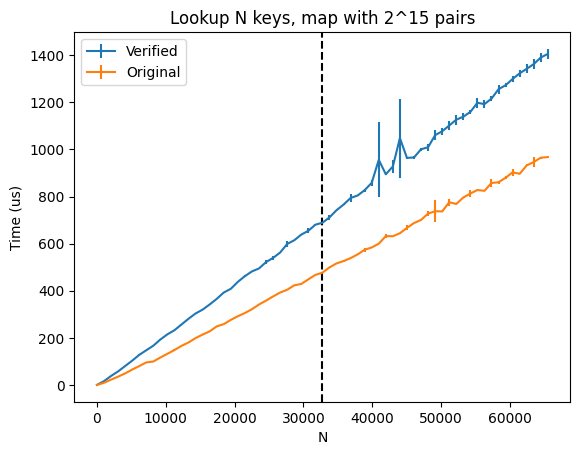

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


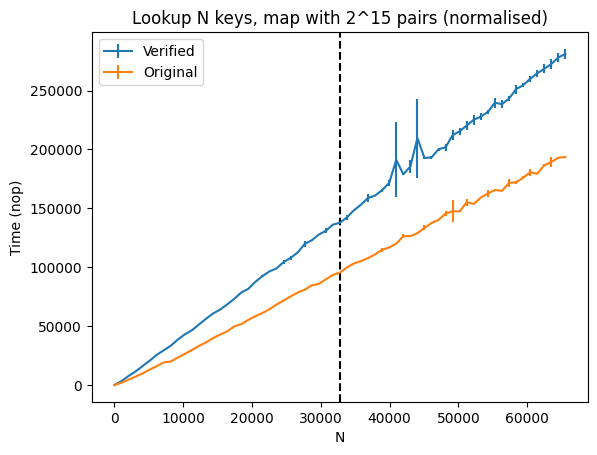

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average of Verified: 0.0210992647502723
Average of Original: 0.014176157918923887


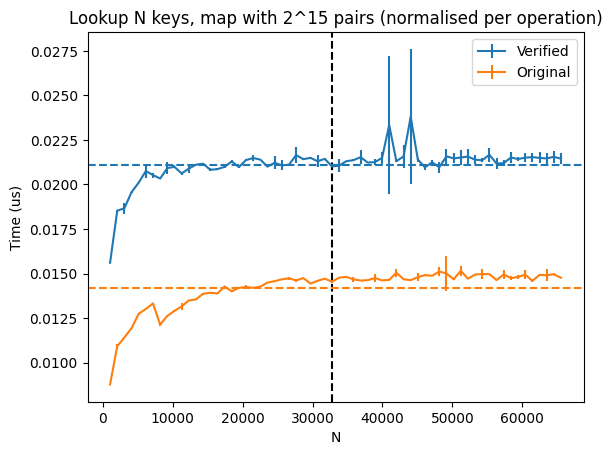

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average of Verified: 1.4883627052508144
Average of Original: 1.0


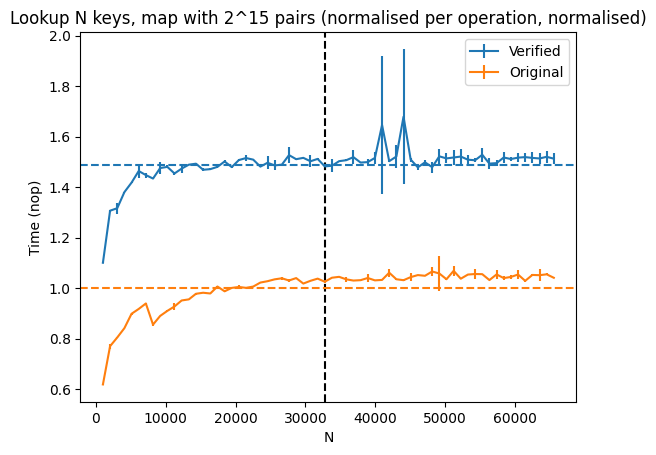

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


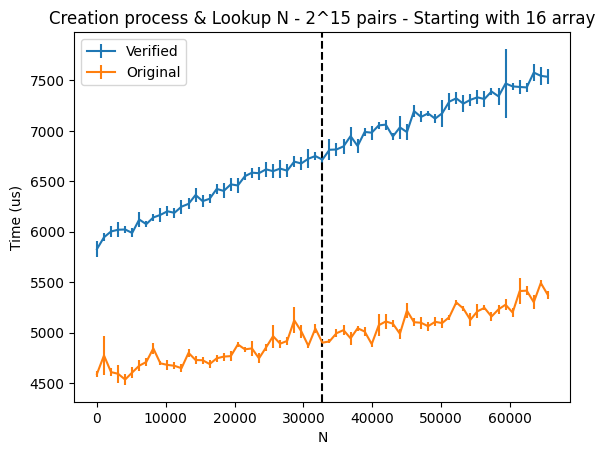

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


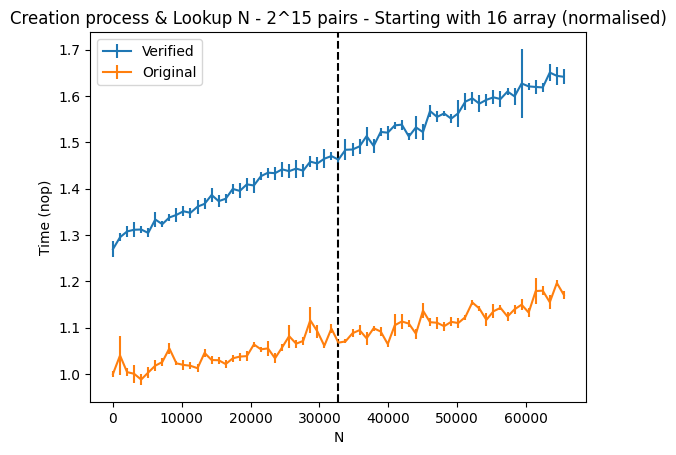

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


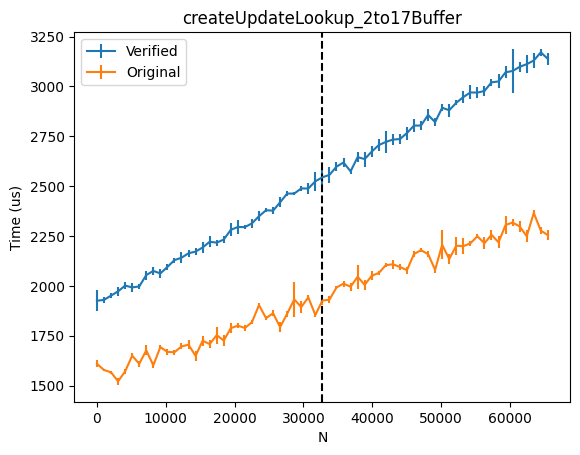

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


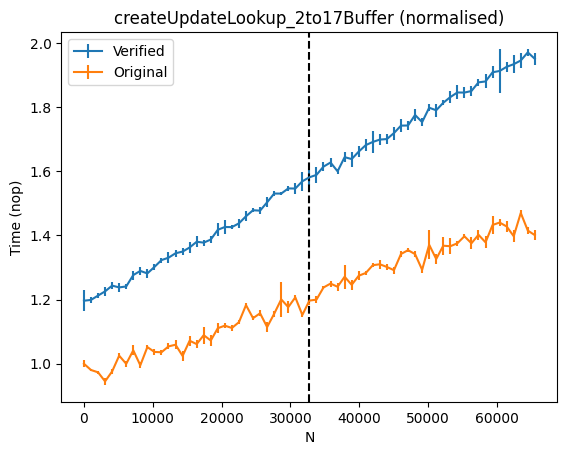

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


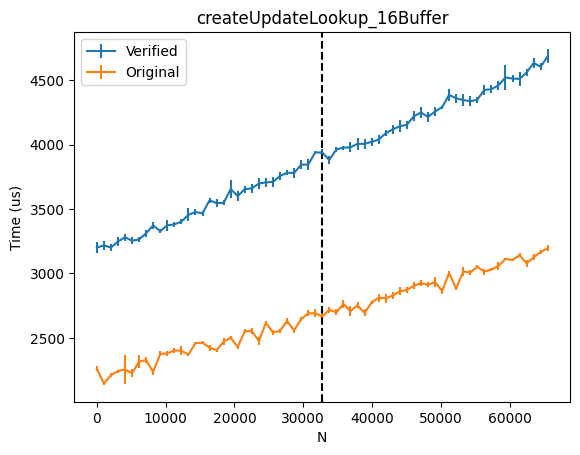

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


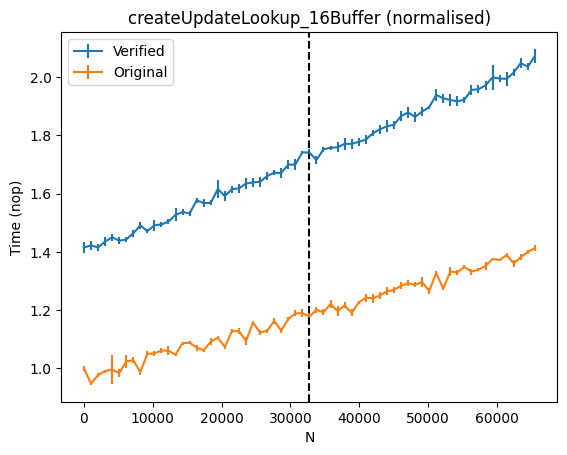

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


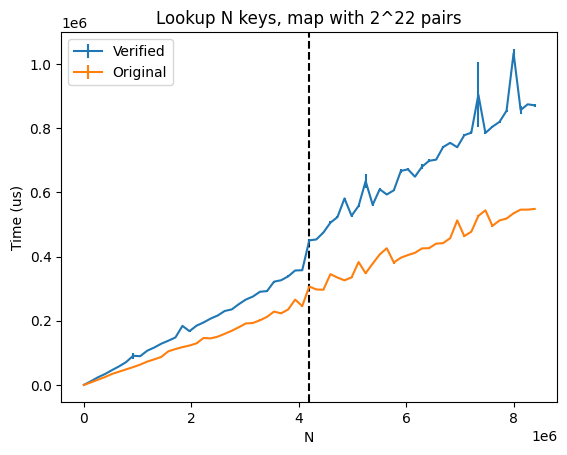

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


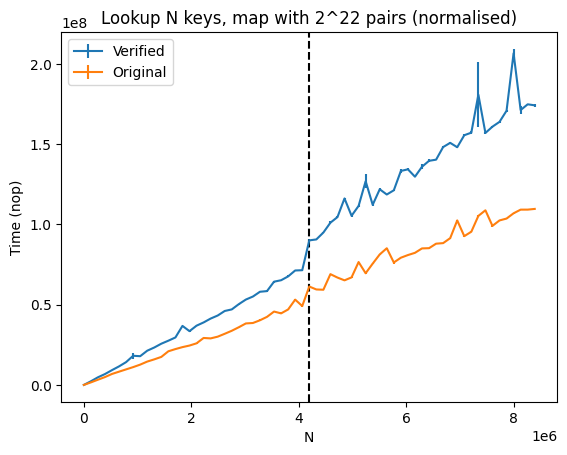

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average of Verified: 0.0994364674635309
Average of Original: 0.06559039766145304


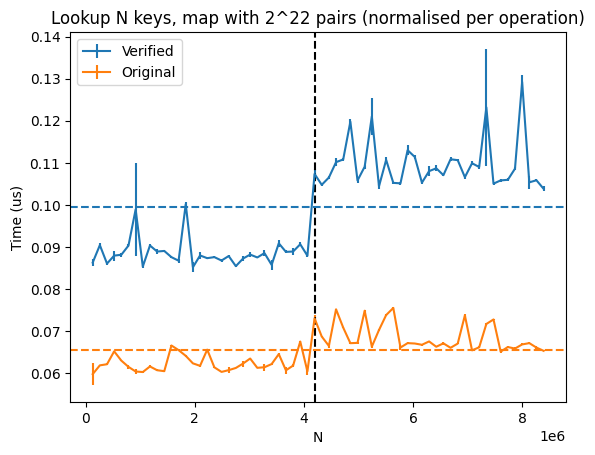

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Average of Verified: 1.5160217197763535
Average of Original: 1.0000000000000004


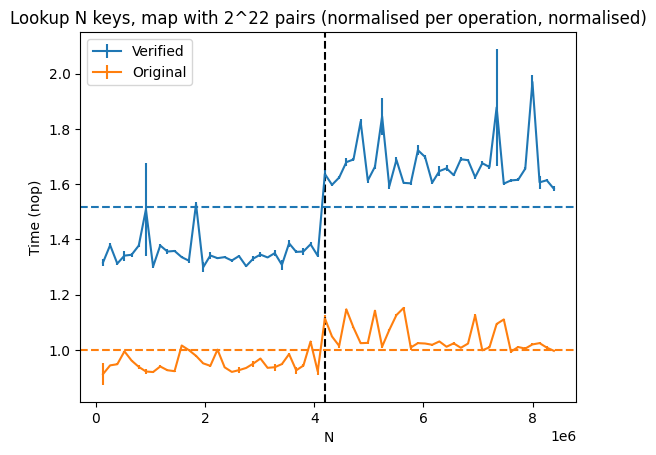

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


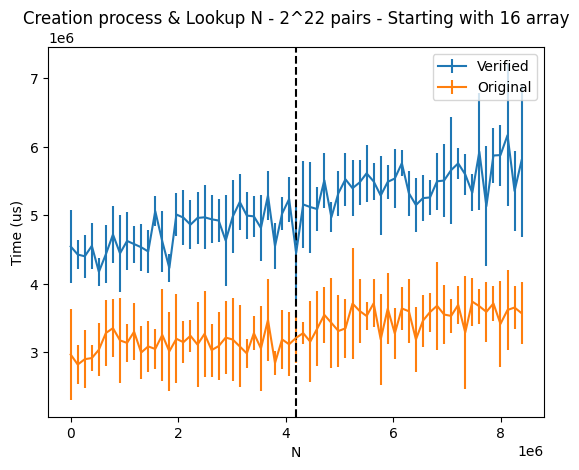

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


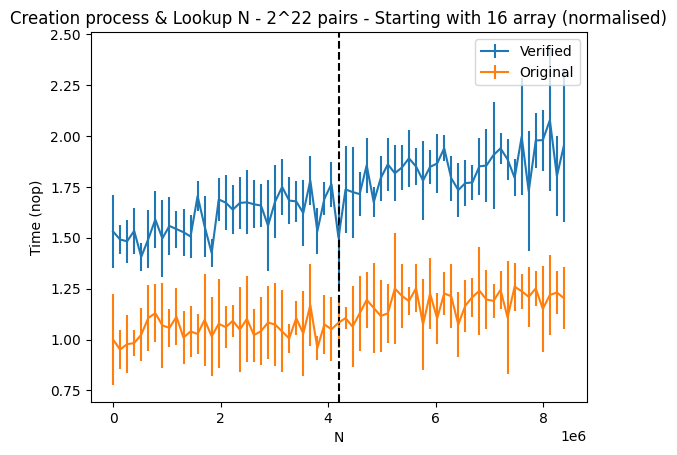

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


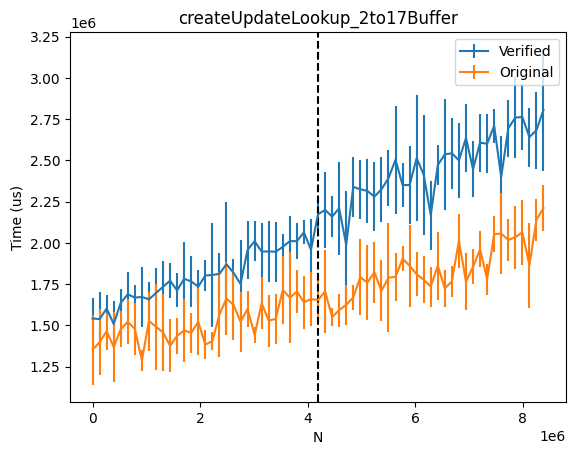

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


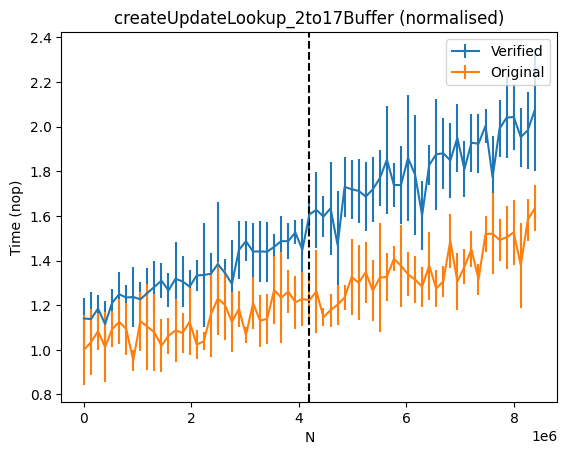

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


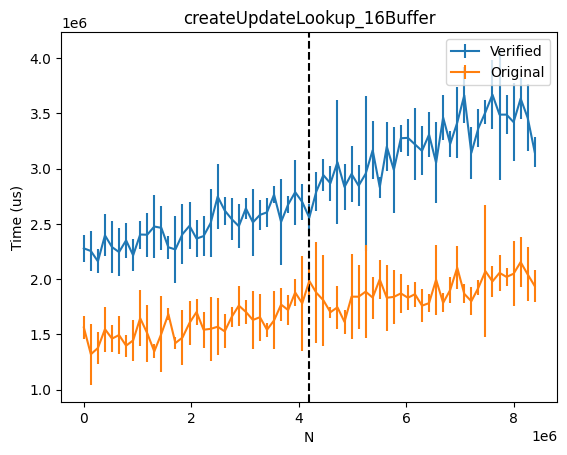

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


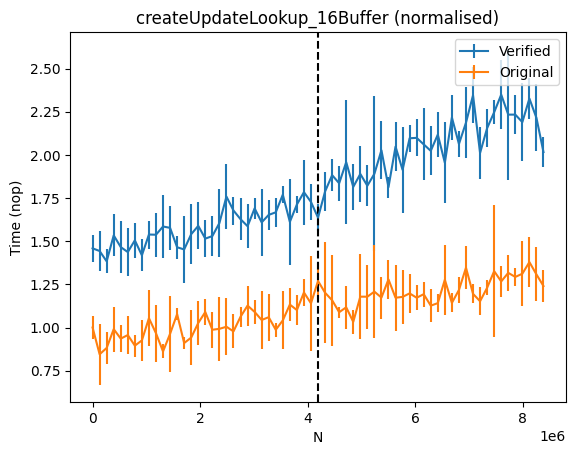

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


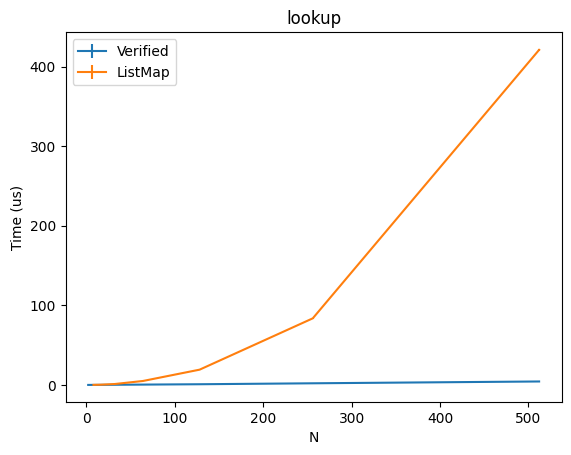

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


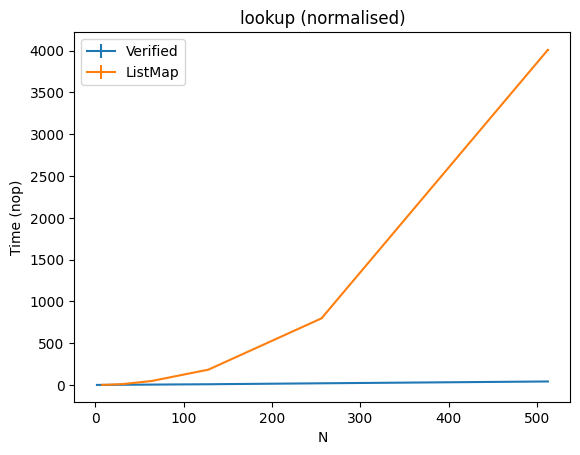

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


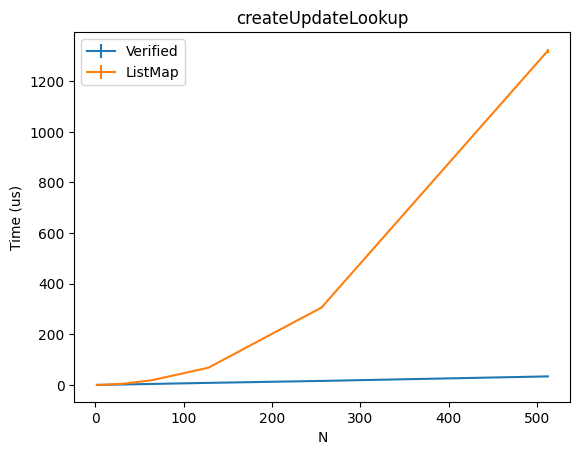

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


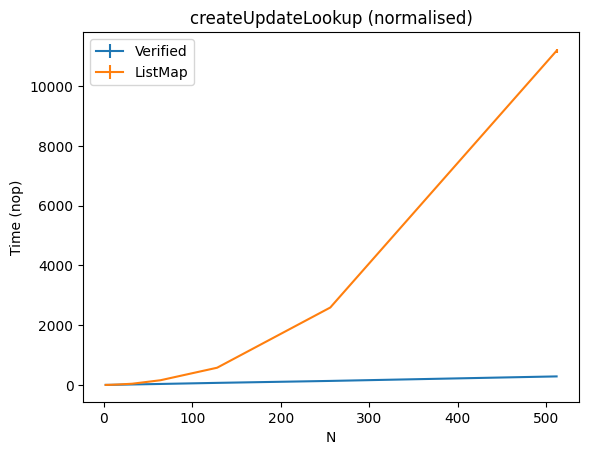

In [437]:
create_plots(benchmark_classes, benchmark_names, df, variable_names, show_avg_for="normalised", pretty_benchmark_names=benchmark_pretty_names, output_folder="./plots")